In [1]:
from utils import spark_session

session = spark_session("purchase-suppression-tmp")

24/11/10 06:53:25 INFO SecurityManager: Changing view acls to: olivyatan,b_perso,*
24/11/10 06:53:25 INFO SecurityManager: Changing modify acls to: olivyatan,b_perso
24/11/10 06:53:25 INFO SecurityManager: Changing view acls groups to: 
24/11/10 06:53:25 INFO SecurityManager: Changing modify acls groups to: 
24/11/10 06:53:25 INFO SecurityManager: SecurityManager: authentication disabled; ui acls disabled; users  with view permissions: Set(olivyatan, b_perso, *); groups with view permissions: Set(); users  with modify permissions: Set(olivyatan, b_perso); groups with modify permissions: Set()
24/11/10 06:53:25 INFO deprecation: mapred.reduce.tasks is deprecated. Instead, use mapreduce.job.reduces
24/11/10 06:53:25 INFO SparkContext: Running Spark version 3.1.1.0.1.0
24/11/10 06:53:25 INFO ResourceUtils: ==============================================================
24/11/10 06:53:25 INFO ResourceUtils: No custom resources configured for spark.driver.
24/11/10 06:53:25 INFO ResourceUtil

# Train/eval model

## Load train test data

In [43]:
import pandas as pd

In [3]:
#train_df = session.table("bx_ps_features_train_1") #views and purchases
#eval_df = session.table("bx_ps_features_test_1")

In [ ]:

#save_table(session, train, "bx_ps_features_train_actions_wtch_all_1")
#save_table(session, validation, "bx_ps_features_valid_actions_wtch_all_1")
#save_table(session, test, "bx_ps_features_test_actions__wtch_all_1")

In [3]:
train_df = session.table("bx_ps_features_train_actions_wtch_all_1")
eval_df = session.table( "bx_ps_features_test_actions__wtch_all_1")

In [4]:
from features import filter_inactive_buyers

config = dict()
config['sampling'] = {
    'ref_dt': '2024-05-01'
}

df_vi = session.table("bx_ps_user_vi_hist_1")
train_df = filter_inactive_buyers(session, config, train_df, df_vi)

In [5]:
from features import vi_label

train_df = vi_label(session, config, train_df, df_vi)
eval_df = vi_label(session, config, eval_df, df_vi)

In [6]:
train_df = train_df.toPandas()
eval_df = eval_df.toPandas()

/apache/spark/python/pyspark/sql/pandas/conversion.py:186: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


In [7]:
train_df.shape, eval_df.shape #  of srchs prchs vis  

((54765, 1497), (19961, 1497))

In [8]:
#train_df.shape, eval_df.shape # prev of prchs vis 

In [9]:
!pwd

/data/shpx/notebooks/olivyatan/purchase_suppression/norm_behave_watch


In [10]:
train_df = train_df.fillna(-1)
eval_df = eval_df.fillna(-1)
len(train_df)

54765

In [11]:
train_df.columns

Index(['BUYER_ID', 'LEAF_CATEG_ID', 'f_time_since_last_purchase_from_LEAF_cat',
       'f_time_since_last_purchase_from_LVL2_cat',
       'f_time_since_last_purchase_from_META_cat',
       'f_time_since_last_view_from_LEAF_cat',
       'f_time_since_last_view_from_LVL2_cat',
       'f_time_since_last_view_from_META_cat',
       'f_num_purchases_from_LEAF_cat_in_last_1_days',
       'f_num_purchases_from_LEAF_cat_in_last_2_days',
       ...
       'f_watch_to_view_ratio_from_META_cat_in_last_90_days',
       'f_watch_to_view_ratio_from_META_cat_in_last_180_days',
       'f_watch_to_view_ratio_from_META_cat_in_last_360_days',
       'f_weighted_num_watchs_from_LEAF_cat',
       'f_weighted_num_watchs_from_LVL2_cat',
       'f_weighted_num_watchs_from_META_cat', 'EVENT_TIMESTAMP', 'label',
       'num_repurchases', 'vi_label'],
      dtype='object', length=1497)

In [12]:
# we don't supress buyers with no activity in a given leaf
train_df = train_df[train_df["f_num_purchases_from_LEAF_cat_in_last_360_days"] > 0]
eval_df = eval_df[eval_df["f_num_purchases_from_LEAF_cat_in_last_360_days"] > 0]
len(train_df)

53737

In [14]:
#train_df.to_parquet('/data/shpx/data/olivyatan/traindf_vi_51024.parquet') 
#eval_df.to_parquet('/data/shpx/data/olivyatan/evaldf_vi_51024.parquet')

### save train eval df parquet

In [13]:
#train_df.to_parquet('/data/shpx/data/olivyatan/traindf_user_behave_311024_top20.parquet') 
#eval_df.to_parquet('/data/shpx/data/olivyatan/evaldf_user_behave_311024_top20.parquet')

train_df.to_parquet('/data/shpx/data/olivyatan/traindf_user_actions_wtch_all_1.parquet') 
eval_df.to_parquet('/data/shpx/data/olivyatan/evaldf__user_actions_wtch_all_1.parquet')

In [16]:
#import pandas as pd
#train_df=pd.read_parquet('/data/shpx/data/olivyatan/traindf_vi_51024.parquet') 
#eval_df=pd.read_parquet(('/data/shpx/data/olivyatan/evaldf_vi_51024.parquet')) *\

In [14]:
train_df.shape, eval_df.shape

((53737, 1497), (19555, 1497))

In [15]:
label_counts = train_df['vi_label'].value_counts()
print("VI Label counts:")
print(label_counts)

VI Label counts:
0    39839
1    13898
Name: vi_label, dtype: int64


### Features list and label, prepare features list:

In [17]:
#origin 832 features 
df_origin=session.table( "bx_ps_features_1")# 832 Original features. 

#1501 features of user behaviour , watch all 
df_wtch_all=session.table("bx_ps_features_actions_wtch_all_1")

In [16]:
df_actions_norm=session.table( "bx_ps_features_actions_norm_1")# 979 

In [ ]:
### user beahve+ watch + mvp: 

In [110]:
action_f_columns = [col for col in df_wtch_all.columns if col.startswith('f_')]
origin_f_columns = [col for col in df_origin.columns if col.startswith('f_')]

features_actions_watch_user_behave = list(set(action_f_columns) - set(origin_f_columns))
features_actions_watch_user_behave

['f_p75_META_cat_watch_propensity_jaccard_sim_in_last_30_days',
 'f_mean_LEAF_cat_watch_propensity_cosine_sim_in_last_14_days',
 'f_p75_LVL2_cat_watch_propensity_jaccard_sim_in_last_7_days',
 'f_p75_LVL2_cat_watch_propensity_cosine_sim_in_last_60_days',
 'f_view_to_purchase_ratio_from_META_cat_in_last_360_days',
 'f_poisson_LVL2_cat_watch_propensity_cosine_sim_in_last_60_days',
 'f_user_vs_mean_watch_from_META_cat_in_last_360_days',
 'f_scoreratio_META_cat_watch_propensity_cosine_sim_in_last_90_days',
 'f_num_watchs_from_META_cat_in_last_14_days',
 'f_min_LEAF_cat_watch_propensity_jaccard_sim_in_last_60_days',
 'f_p75_LEAF_cat_watch_propensity_jaccard_sim_in_last_7_days',
 'f_var_LVL2_cat_watch_propensity_cosine_sim_in_last_14_days',
 'f_scoreratio_LVL2_cat_watch_propensity_cosine_sim_in_last_180_days',
 'f_norm_num_purchases_from_LEAF_cat_in_last_2_days',
 'f_user_vs_mean_watch_from_LVL2_cat_in_last_360_days',
 'f_norm_num_purchases_from_LEAF_cat_in_last_14_days',
 'f_scoreratio_LEAF_

In [111]:
len(features_actions_watch_user_behave)

669

In [112]:
combined_features_mvp_user_behave_watch = list(set(features_actions_watch_user_behave + mvp_features))
len(combined_features_mvp_user_behave_watch)

689

In [18]:
# Get a list of column names that start with "f_" and contain "watch", "wtch", or "watches"
watch_features = [
    col for col in df_wtch_all.columns 
    if col.startswith("f_") and any(keyword in col.lower() for keyword in ["watch", "wtch", "watches"])
]

# Display the list of matching column names
print(watch_features)


['f_time_since_last_watch_from_LEAF_cat', 'f_time_since_last_watch_from_LVL2_cat', 'f_time_since_last_watch_from_META_cat', 'f_num_watchs_from_LEAF_cat_in_last_1_days', 'f_num_watchs_from_LEAF_cat_in_last_2_days', 'f_num_watchs_from_LEAF_cat_in_last_5_days', 'f_num_watchs_from_LEAF_cat_in_last_7_days', 'f_num_watchs_from_LEAF_cat_in_last_14_days', 'f_num_watchs_from_LEAF_cat_in_last_30_days', 'f_num_watchs_from_LEAF_cat_in_last_60_days', 'f_num_watchs_from_LEAF_cat_in_last_90_days', 'f_num_watchs_from_LEAF_cat_in_last_180_days', 'f_num_watchs_from_LEAF_cat_in_last_360_days', 'f_num_watchs_from_LVL2_cat_in_last_1_days', 'f_num_watchs_from_LVL2_cat_in_last_2_days', 'f_num_watchs_from_LVL2_cat_in_last_5_days', 'f_num_watchs_from_LVL2_cat_in_last_7_days', 'f_num_watchs_from_LVL2_cat_in_last_14_days', 'f_num_watchs_from_LVL2_cat_in_last_30_days', 'f_num_watchs_from_LVL2_cat_in_last_60_days', 'f_num_watchs_from_LVL2_cat_in_last_90_days', 'f_num_watchs_from_LVL2_cat_in_last_180_days', 'f_num_

In [19]:
len(watch_features)

501

In [21]:
action_f_columns = [col for col in df_actions_norm.columns if col.startswith('f_')]
origin_f_columns = [col for col in df_origin.columns if col.startswith('f_')]

features_actions_norm_user_behave = list(set(action_f_columns) - set(origin_f_columns))
features_actions_norm_user_behave

['f_user_vs_mean_view_from_META_cat_in_last_30_days',
 'f_user_vs_mean_view_from_META_cat_in_last_14_days',
 'f_norm_num_views_from_LVL2_cat_in_last_5_days',
 'f_norm_num_views_from_LVL2_cat_in_last_30_days',
 'f_user_vs_mean_view_from_LEAF_cat_in_last_2_days',
 'f_norm_num_purchases_from_LEAF_cat_in_last_14_days',
 'f_norm_num_views_from_META_cat_in_last_90_days',
 'f_user_vs_mean_purchase_from_LVL2_cat_in_last_60_days',
 'f_norm_num_views_from_LVL2_cat_in_last_14_days',
 'f_user_vs_mean_purchase_from_LEAF_cat_in_last_360_days',
 'f_norm_num_purchases_from_LVL2_cat_in_last_5_days',
 'f_max_num_views_between_purchases_in_LVL2_cat',
 'f_min_time_since_first_view_after_purchase_in_LEAF_cat',
 'f_user_vs_mean_view_from_LEAF_cat_in_last_7_days',
 'f_user_vs_mean_view_from_LVL2_cat_in_last_7_days',
 'f_num_views_since_last_purchase_in_LVL2_cat',
 'f_norm_num_views_from_META_cat_in_last_5_days',
 'f_norm_num_purchases_from_LVL2_cat_in_last_180_days',
 'f_norm_num_purchases_from_META_cat_in_l

In [22]:
len(features_actions_norm_user_behave) #60 +87

147

In [23]:
behave_f_columns = [col for col in df_behave.columns if col.startswith('f_')]
action_f_columns = [col for col in df_actions_norm.columns if col.startswith('f_')]

# Find columns in df_behave but not in df_origin
features_actions_norm = list(set(action_f_columns) - set(behave_f_columns))
features_actions_norm

['f_norm_num_views_from_META_cat_in_last_360_days',
 'f_norm_num_purchases_from_LEAF_cat_in_last_7_days',
 'f_norm_num_views_from_LVL2_cat_in_last_5_days',
 'f_norm_num_purchases_from_META_cat_in_last_180_days',
 'f_norm_num_views_from_LVL2_cat_in_last_30_days',
 'f_norm_num_views_from_META_cat_in_last_60_days',
 'f_norm_num_purchases_from_LEAF_cat_in_last_5_days',
 'f_norm_num_purchases_from_LVL2_cat_in_last_14_days',
 'f_norm_num_views_from_LVL2_cat_in_last_1_days',
 'f_norm_num_purchases_from_LEAF_cat_in_last_14_days',
 'f_norm_num_purchases_from_META_cat_in_last_5_days',
 'f_norm_num_views_from_META_cat_in_last_90_days',
 'f_norm_num_views_from_LVL2_cat_in_last_7_days',
 'f_norm_num_purchases_from_LVL2_cat_in_last_2_days',
 'f_norm_num_views_from_LVL2_cat_in_last_14_days',
 'f_norm_num_purchases_from_LVL2_cat_in_last_5_days',
 'f_norm_num_views_from_LEAF_cat_in_last_14_days',
 'f_norm_num_purchases_from_LVL2_cat_in_last_360_days',
 'f_norm_num_views_from_LEAF_cat_in_last_1_days',
 

In [24]:
len(features_actions_norm)

60

In [25]:
# Get feature columns from each DataFrame
behave_f_columns = [col for col in df_behave.columns if col.startswith('f_')]
origin_f_columns = [col for col in df_origin.columns if col.startswith('f_')]

# Find columns in df_behave but not in df_origin
features_user_behave = list(set(behave_f_columns) - set(origin_f_columns))
features_user_behave

['f_user_vs_mean_view_from_META_cat_in_last_30_days',
 'f_user_vs_mean_view_from_META_cat_in_last_14_days',
 'f_user_vs_mean_view_from_LEAF_cat_in_last_2_days',
 'f_user_vs_mean_purchase_from_LVL2_cat_in_last_60_days',
 'f_user_vs_mean_purchase_from_LEAF_cat_in_last_360_days',
 'f_max_num_views_between_purchases_in_LVL2_cat',
 'f_min_time_since_first_view_after_purchase_in_LEAF_cat',
 'f_user_vs_mean_view_from_LEAF_cat_in_last_7_days',
 'f_user_vs_mean_view_from_LVL2_cat_in_last_7_days',
 'f_num_views_since_last_purchase_in_LVL2_cat',
 'f_user_vs_mean_purchase_from_LEAF_cat_in_last_30_days',
 'f_mean_views_between_purchases_per_days_in_LEAF_cat',
 'f_user_vs_mean_view_from_META_cat_in_last_360_days',
 'f_max_time_since_first_view_after_purchase_in_LVL2_cat',
 'f_max_time_since_first_view_after_purchase_in_LEAF_cat',
 'f_user_vs_mean_view_from_LEAF_cat_in_last_60_days',
 'f_user_vs_mean_view_from_META_cat_in_last_7_days',
 'f_entropy_for_LEAF_cat_purchases',
 'f_user_vs_mean_view_from_M

In [26]:
len(features_user_behave)

87

In [27]:
len(features_user_behave) , len(features_actions_norm) , len(features_actions_norm_user_behave)

(87, 60, 147)

In [20]:
# Provided list of features
mvp_features = ['f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days',
 'f_num_views_from_LEAF_cat_in_last_30_days',
 'f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days',
 'f_num_purchases_from_LEAF_cat_in_last_360_days',
 'f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days',
 'f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days',
 'f_num_views_from_LEAF_cat_in_last_14_days',
 'f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days',
 'f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days',
 'f_num_views_from_LEAF_cat_in_last_2_days',
 'f_num_purchases_from_LVL2_cat_in_last_360_days',
 'f_num_views_from_LEAF_cat_in_last_360_days',
 'f_max_LEAF_cat_view_propensity_cosine_sim_in_last_90_days',
 'f_max_LEAF_cat_view_propensity_cosine_sim_in_last_60_days',
 'f_num_views_from_LEAF_cat_in_last_180_days',
 'f_num_purchases_from_LEAF_cat_in_last_180_days',
 'f_num_views_from_LEAF_cat_in_last_7_days',
 'f_time_since_last_view_from_LEAF_cat',
 'f_num_purchases_from_LEAF_cat_in_last_30_days',
 'f_time_since_last_view_from_LVL2_cat'] 
# Combine `new_features` and `provided_features` into a single list without duplicates
combined_features = list(set(watch_features + mvp_features))
combined_features

['f_p75_META_cat_watch_propensity_jaccard_sim_in_last_30_days',
 'f_mean_LEAF_cat_watch_propensity_cosine_sim_in_last_14_days',
 'f_num_views_from_LEAF_cat_in_last_180_days',
 'f_p75_LVL2_cat_watch_propensity_jaccard_sim_in_last_7_days',
 'f_p75_LVL2_cat_watch_propensity_cosine_sim_in_last_60_days',
 'f_poisson_LVL2_cat_watch_propensity_cosine_sim_in_last_60_days',
 'f_user_vs_mean_watch_from_META_cat_in_last_360_days',
 'f_scoreratio_META_cat_watch_propensity_cosine_sim_in_last_90_days',
 'f_num_watchs_from_META_cat_in_last_14_days',
 'f_min_LEAF_cat_watch_propensity_jaccard_sim_in_last_60_days',
 'f_p75_LEAF_cat_watch_propensity_jaccard_sim_in_last_7_days',
 'f_scoreratio_LEAF_cat_watch_propensity_cosine_sim_in_last_180_days',
 'f_var_LVL2_cat_watch_propensity_cosine_sim_in_last_14_days',
 'f_scoreratio_LVL2_cat_watch_propensity_cosine_sim_in_last_180_days',
 'f_user_vs_mean_watch_from_LVL2_cat_in_last_360_days',
 'f_scoreratio_LEAF_cat_watch_propensity_jaccard_sim_in_last_30_days',


In [29]:
 
combined_features_actions_norm_mvp = list(set(features_actions_norm + mvp_features))
len(combined_features_actions_norm_mvp)

80

In [21]:
len(combined_features) #20+147=87+60

521

In [31]:
len(mvp_features), len(features_actions_norm_user_behave), len(combined_features)

(20, 147, 167)

##### all features with new features:

In [32]:
combined_features_all_new = list(set(features_actions_norm_user_behave + origin_f_columns))
len(combined_features_all_new) #822+87+60

969

In [33]:
 

combined_features_all_new = list(set(features_actions_norm + origin_f_columns))
len(combined_features_all_new) #822+60

882

### Set label and features: 

In [25]:
#feature_list = [f for f in train_df.columns if f.startswith("f_")]
feature_list = mvp_features 
label = "vi_label"#"label"

#### features dist:

In [22]:
# Initialize an empty dictionary to store results
results = {}

# Loop through each feature column in combined_features and calculate metrics
for col in mvp_features:
    total_count = len(train_df[col])
    pos_count = (train_df[col] > 0).sum()  # Count of values > 0
    zero_count = (train_df[col] == 0).sum()  # Count of values == 0
    neg_one_count = (train_df[col] == -1).sum()  # Count of values == -1
    below_zero_not_neg_one_count = ((train_df[col] < 0) & (train_df[col] != -1)).sum()  # Count of values < 0 and not -1

    # Calculate percentages
    pos_percent = (pos_count / total_count) * 100
    zero_percent = (zero_count / total_count) * 100
    neg_one_percent = (neg_one_count / total_count) * 100
    below_zero_not_neg_one_percent = (below_zero_not_neg_one_count / total_count) * 100

    # Calculate mean and std for values above 0
    pos_values = train_df[col][train_df[col] > 0]
    pos_mean = pos_values.mean() if not pos_values.empty else None
    pos_std = pos_values.std() if not pos_values.empty else None

    # Store results for this feature
    results[col] = {
        '> 0 %': pos_percent,
        '== 0 %': zero_percent,
        '== -1 %': neg_one_percent,
        '< 0 and != -1 %': below_zero_not_neg_one_percent,
        'Mean (> 0)': pos_mean,
        'Std (> 0)': pos_std
    }

# Convert results to a DataFrame for better readability
results_df = pd.DataFrame(results).T



In [23]:
results_df.head(30)

,> 0 %,== 0 %,== -1 %,< 0 and != -1 %,Mean (> 0),Std (> 0)
f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days,89.841264,10.158736,0.000000,0.0,0.978542,0.100561
f_num_views_from_LEAF_cat_in_last_30_days,21.523345,78.476655,0.000000,0.0,16.596576,36.654258
f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days,89.830098,10.169902,0.000000,0.0,0.955891,0.136575
f_num_purchases_from_LEAF_cat_in_last_360_days,100.000000,0.000000,0.000000,0.0,2.409792,11.069578
f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days,89.841264,10.158736,0.000000,0.0,0.973728,0.070561
f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days,81.621602,18.378398,0.000000,0.0,0.905937,0.092469
f_num_views_from_LEAF_cat_in_last_14_days,13.821017,86.178983,0.000000,0.0,12.585297,25.805292
f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days,73.524759,26.475241,0.000000,0.0,0.884543,0.099050
f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days,81.621602,18.378398,0.000000,0.0,0.850307,0.137508
f_num_views_from_LEAF_cat_in_last_2_days,3.844651,96.155349,0.000000,0.0,6.346079,11.399748


### Downsample majority class

In [26]:
#perform downsampling
from sklearn.utils import resample
import pandas as pd

_train_df = train_df#train_no_entu_df
# Assuming df is your DataFrame and 'class' is your target variable
majority_class = _train_df[_train_df[label] == 0]
minority_class = _train_df[_train_df[label] == 1]

# Downsample majority class
majority_downsampled = resample(majority_class, 
                                replace=False,    # sample without replacement
                                n_samples=len(minority_class),     # to match minority class
                                random_state=123) # reproducible results

# Combine minority class with downsampled majority class
df_balanced = pd.concat([majority_downsampled, minority_class])

# Display new class counts
print(df_balanced[label].value_counts())

0    13898
1    13898
Name: vi_label, dtype: int64


In [27]:
_train_df = df_balanced
_eval_df = eval_df

### Train xgb 

In [12]:
#!pip install xgboost --user --proxy=httpproxy-tcop.vip.ebay.com:80


[notice] A new release of pip is available: 23.0 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Basline: Mvp model

In [28]:
len(mvp_features)

20

In [29]:
feature_list = mvp_features 

In [30]:
feature_list

['f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days',
 'f_num_views_from_LEAF_cat_in_last_30_days',
 'f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days',
 'f_num_purchases_from_LEAF_cat_in_last_360_days',
 'f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days',
 'f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days',
 'f_num_views_from_LEAF_cat_in_last_14_days',
 'f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days',
 'f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days',
 'f_num_views_from_LEAF_cat_in_last_2_days',
 'f_num_purchases_from_LVL2_cat_in_last_360_days',
 'f_num_views_from_LEAF_cat_in_last_360_days',
 'f_max_LEAF_cat_view_propensity_cosine_sim_in_last_90_days',
 'f_max_LEAF_cat_view_propensity_cosine_sim_in_last_60_days',
 'f_num_views_from_LEAF_cat_in_last_180_days',
 'f_num_purchases_from_LEAF_cat_in_last_180_days',
 'f_num_views_from_LEAF_cat_in_last_7_days',
 'f_time_since_last_view_from_LEAF_cat',
 'f_num_purchases_from_LEAF

In [31]:
import xgboost as xgb
import numpy as np

def train_eval_model(hyperp, feature_list, label, train_df, eval_df, preds_col='preds', verbose=True):
    model = xgb.XGBClassifier(
        **hyperp
    )
    
    model = model.fit(train_df[feature_list], train_df[label], verbose=verbose)
    eval_df[preds_col] = model.predict(eval_df[feature_list])
    return model, eval_df

hyperp = {
    'tree_method': 'hist',
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'random_state': 42, 
    'learning_rate': 0.01,
    'colsample_bytree': 0.5, 
    'eta': 0.05, 
    'max_depth': 20,#12,
    'n_estimators': 500,#500
    'subsample': 0.75,
    'lambda': 100
}


In [32]:
model, eval_df = train_eval_model(hyperp, feature_list, label, _train_df, _eval_df, preds_col='preds')

In [33]:
# feature importance
import numpy as np
print(f"Feature importance of ranker:")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_num_views_from_LEAF_cat_in_last_30_days 0.188566
 2) f_num_purchases_from_LEAF_cat_in_last_360_days 0.113186
 3) f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days 0.100998
 4) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days 0.080074
 5) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.075769
 6) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.049426
 7) f_num_views_from_LEAF_cat_in_last_14_days 0.042647
 8) f_num_purchases_from_LVL2_cat_in_last_360_days 0.037652
 9) f_num_views_from_LEAF_cat_in_last_2_days 0.034407
10) f_num_views_from_LEAF_cat_in_last_360_days 0.033464
11) f_num_views_from_LEAF_cat_in_last_7_days 0.032961
12) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days 0.029901
13) f_num_purchases_from_LEAF_cat_in_last_30_days 0.029703
14) f_time_since_last_view_from_LEAF_cat 0.028057
15) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days 0.022823
16) f_num_purchases_from_LEAF_cat_

#### save model params

In [34]:
#model.save_model('/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_51024.model')  
#model.save_model('/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_srchs_81024.model')  
#model.save_model('/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_291024.model') 
#model.save_model('/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_301024_mvp.model') 
model.save_model('/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_311024_mvp.model') 

In [35]:
import pickle

#file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_51024.pkl'
#file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_srchs_81024.pkl'
#file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_291024.pkl'
#file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_301024_mvp.pkl' 
file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_311024_mvp.pkl' 

# save
pickle.dump(model, open(file_name, "wb"))

In [119]:
#import pickle
#file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_51024.pkl'
file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_291024.pkl'
model_xgb = pickle.load(open(file_name, "rb"))

In [28]:
# Step 1: Get the previous model's feature names
previous_model_features = model_xgb.get_booster().feature_names

# Step 2: Filter eval_df to only include the features present in the previous model
common_features = [col for col in eval_df.columns if col in previous_model_features]

# Step 3: Predict using the previous model on the new data with the common features
eval_df['prev_model_preds'] = model_xgb.predict(eval_df[common_features])

# Now eval_df will have a new column 'prev_model_preds' containing predictions


#### Model results metrics

#### Baseline mvp- top 20 features

In [36]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15589
1     3966
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7829711071337254
ROC AUC: 0.7573789698808465
Precision (micro): 0.7829711071337254
Recall (micro): 0.7829711071337254
Precision (macro): 0.6966867890876403
Recall (macro): 0.7573789698808465
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15589
           1       0.48      0.71      0.57      3966

    accuracy                           0.78     19555
   macro avg       0.70      0.76      0.71     19555
weighted avg       0.83      0.78      0.80     19555



### New features model: watch features of all 

In [76]:
feature_list = combined_features 

In [77]:
len(feature_list) # 501 watch features 

521

In [44]:
model_new, eval_df = train_eval_model(hyperp, feature_list, label, _train_df, _eval_df, preds_col='preds_new')

#### results new model

In [45]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_new'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15589
1     3966
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7927384300690361
ROC AUC: 0.7734688417524972
Precision (micro): 0.7927384300690361
Recall (micro): 0.7927384300690361
Precision (macro): 0.7085685939626976
Recall (macro): 0.7734688417524971
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     15589
           1       0.49      0.74      0.59      3966

    accuracy                           0.79     19555
   macro avg       0.71      0.77      0.73     19555
weighted avg       0.84      0.79      0.81     19555



In [46]:
#model.save_model('/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_301024_new_features.model')
model_new.save_model('/data/shpx/data/olivyatan/purchase_suppression/ps_xgb_wtch_mvp_101124.model')

In [47]:
#file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_user_behave_301024_new_features.pkl' 
file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_xgb_wtch_mvp_101124.pkl' 

# save
pickle.dump(model_new, open(file_name, "wb"))

#### compare: 

In [48]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

def get_metrics(eval_df, label, preds):
    y_test = eval_df[label].values
    y_pred = preds
    
    # Calculate metrics
    acc = sum(y_test == y_pred) / len(y_test)
    roc_auc = roc_auc_score(y_test, y_pred)
    precision_micro = precision_score(y_test, y_pred, average='micro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')

    # Print metrics
    print("Metrics:")
    print(f'Accuracy: {round(acc, 3)}')
    print(f'ROC AUC: {round(roc_auc, 3)}')
    print(f'Precision (micro): {round(precision_micro, 3)}')
    print(f'Recall (micro): {round(recall_micro, 3)}')
    print(f'Precision (macro): {round(precision_macro, 3)}')
    print(f'Recall (macro): {round(recall_macro, 3)}')

    # Generate classification report
    report = classification_report(y_test, y_pred, target_names=['0', '1'])
    print("Classification Report:")
    print(report)
    
    # Return metrics as a dictionary
    metrics = {
        'accuracy': acc,
        'roc_auc': roc_auc,
        'precision_micro': precision_micro,
        'recall_micro': recall_micro,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro
    }
    
    return metrics


In [49]:

# Example usage with baseline and new model predictions
baseline_metrics = get_metrics(_eval_df, label, _eval_df['preds'].values) 

Metrics:
Accuracy: 0.783
ROC AUC: 0.757
Precision (micro): 0.783
Recall (micro): 0.783
Precision (macro): 0.697
Recall (macro): 0.757
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15589
           1       0.48      0.71      0.57      3966

    accuracy                           0.78     19555
   macro avg       0.70      0.76      0.71     19555
weighted avg       0.83      0.78      0.80     19555



In [50]:
new_metrics = get_metrics(_eval_df, label, _eval_df['preds_new'].values )

Metrics:
Accuracy: 0.793
ROC AUC: 0.773
Precision (micro): 0.793
Recall (micro): 0.793
Precision (macro): 0.709
Recall (macro): 0.773
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     15589
           1       0.49      0.74      0.59      3966

    accuracy                           0.79     19555
   macro avg       0.71      0.77      0.73     19555
weighted avg       0.84      0.79      0.81     19555



In [51]:
# Function to compare metrics remains unchanged
def compare_metrics(baseline_metrics, new_metrics):
    diff_results = {}
    
    for metric in baseline_metrics:
        baseline_val = baseline_metrics[metric]
        new_val = new_metrics[metric]
        abs_diff = new_val - baseline_val
        perc_change = (abs_diff / baseline_val) * 100 if baseline_val != 0 else float('inf')
        
        diff_results[metric] = {
            'Baseline': round(baseline_val, 3),
            'New': round(new_val, 3),
            'Absolute Difference': round(abs_diff, 3),
            'Percentage Change (%)': round(perc_change, 3)
        }

    # Convert to DataFrame
    comparison_df = pd.DataFrame.from_dict(diff_results, orient='index')
    return comparison_df 




In [52]:
# Comparison results
comparison_results = compare_metrics(baseline_metrics, new_metrics)

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)


Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.783  0.793                0.010                  1.247
roc_auc             0.757  0.773                0.016                  2.124
precision_micro     0.783  0.793                0.010                  1.247
recall_micro        0.783  0.793                0.010                  1.247
precision_macro     0.697  0.709                0.012                  1.705
recall_macro        0.757  0.773                0.016                  2.124


#### Feature importance - new model

In [78]:
import numpy as np
print(f"Feature importance of ranker:")
importances = model_new.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_max_LEAF_cat_watch_propensity_cosine_sim_in_last_60_days 0.099716
 2) f_weighted_num_watchs_from_LEAF_cat 0.066209
 3) f_watch_to_view_ratio_from_LEAF_cat_in_last_30_days 0.048108
 4) f_num_views_from_LEAF_cat_in_last_30_days 0.028053
 5) f_watch_to_view_ratio_from_LEAF_cat_in_last_60_days 0.025947
 6) f_max_LEAF_cat_watch_propensity_cosine_sim_in_last_90_days 0.024218
 7) f_num_purchases_from_LEAF_cat_in_last_360_days 0.020560
 8) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.016075
 9) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.014812
10) f_max_LVL2_cat_watch_propensity_jaccard_sim_in_last_60_days 0.014492
11) f_num_watchs_from_LEAF_cat_in_last_360_days 0.012603
12) f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days 0.012366
13) f_max_LEAF_cat_watch_propensity_jaccard_sim_in_last_60_days 0.010611
14) f_num_watchs_from_LVL2_cat_in_last_60_days 0.009499
15) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14

In [56]:
# Safely create a list of the top 20 features (or fewer if there are less than 20 available)
top20_features_from_mvp_watches = [feature_list[i] for i in indices[:min(20, len(indices), len(feature_list))]]

In [57]:
top30_features_from_mvp_watches = [feature_list[i] for i in indices[:min(30, len(indices), len(feature_list))]]

In [79]:
top40_features_from_mvp_watches = [feature_list[i] for i in indices[:min(40, len(indices), len(feature_list))]]

In [80]:
top50_features_from_mvp_watches = [feature_list[i] for i in indices[:min(50, len(indices), len(feature_list))]]

In [81]:
top60_features_from_mvp_watches = [feature_list[i] for i in indices[:min(60, len(indices), len(feature_list))]]

In [82]:
top80_features_from_mvp_watches = [feature_list[i] for i in indices[:min(80, len(indices), len(feature_list))]]

In [83]:
top100_features_from_mvp_watches = [feature_list[i] for i in indices[:min(100, len(indices), len(feature_list))]]

### Train top 20  of ( mvp+ watches all 501) 

In [60]:
feature_list=top20_features_from_mvp_watches  #top30_features_from_mvp_watches

In [61]:
model_top20_from_watch_mvp, eval_df = train_eval_model(hyperp, feature_list, label, _train_df,
                                                       _eval_df, preds_col='preds_top20_mvp_watch')

In [62]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_top20_mvp_watch'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15589
1     3966
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.79785221171056
ROC AUC: 0.7610726116502426
Precision (micro): 0.79785221171056
Recall (micro): 0.79785221171056
Precision (macro): 0.7080470909582249
Recall (macro): 0.7610726116502426
              precision    recall  f1-score   support

           0       0.91      0.82      0.87     15589
           1       0.50      0.70      0.58      3966

    accuracy                           0.80     19555
   macro avg       0.71      0.76      0.73     19555
weighted avg       0.83      0.80      0.81     19555



In [64]:
# feature importance
import numpy as np
print(f"Feature importance of ranker:")
importances = model_top20_from_watch_mvp.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_watch_to_view_ratio_from_LEAF_cat_in_last_30_days 0.160587
 2) f_num_purchases_from_LEAF_cat_in_last_360_days 0.154245
 3) f_watch_to_view_ratio_from_LEAF_cat_in_last_60_days 0.078964
 4) f_weighted_num_watchs_from_LEAF_cat 0.075709
 5) f_num_views_from_LEAF_cat_in_last_30_days 0.072775
 6) f_num_views_from_LEAF_cat_in_last_7_days 0.066191
 7) f_num_watchs_from_LEAF_cat_in_last_360_days 0.049989
 8) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.047726
 9) f_max_LEAF_cat_watch_propensity_cosine_sim_in_last_60_days 0.044314
10) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.038773
11) f_watch_to_view_ratio_from_LEAF_cat_in_last_90_days 0.033730
12) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days 0.031785
13) f_max_LEAF_cat_watch_propensity_cosine_sim_in_last_90_days 0.028011
14) f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days 0.027213
15) f_num_views_from_LEAF_cat_in_last_14_days 0.022149
16) f_max_L

In [65]:
baseline_metrics = get_metrics(_eval_df, label, _eval_df['preds'].values) 

Metrics:
Accuracy: 0.783
ROC AUC: 0.757
Precision (micro): 0.783
Recall (micro): 0.783
Precision (macro): 0.697
Recall (macro): 0.757
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15589
           1       0.48      0.71      0.57      3966

    accuracy                           0.78     19555
   macro avg       0.70      0.76      0.71     19555
weighted avg       0.83      0.78      0.80     19555



In [66]:
new_metrics = get_metrics(_eval_df, label, _eval_df['preds_top20_mvp_watch'].values )

Metrics:
Accuracy: 0.798
ROC AUC: 0.761
Precision (micro): 0.798
Recall (micro): 0.798
Precision (macro): 0.708
Recall (macro): 0.761
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.82      0.87     15589
           1       0.50      0.70      0.58      3966

    accuracy                           0.80     19555
   macro avg       0.71      0.76      0.73     19555
weighted avg       0.83      0.80      0.81     19555



In [67]:
comparison_results = compare_metrics(baseline_metrics, new_metrics)

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)

Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.783  0.798                0.015                  1.901
roc_auc             0.757  0.761                0.004                  0.488
precision_micro     0.783  0.798                0.015                  1.901
recall_micro        0.783  0.798                0.015                  1.901
precision_macro     0.697  0.708                0.011                  1.631
recall_macro        0.757  0.761                0.004                  0.488


### Train top 30  of ( mvp+ watches all 501) 

In [68]:
feature_list=top30_features_from_mvp_watches 

In [69]:
model_top30_from_watch_mvp, eval_df = train_eval_model(hyperp, feature_list, label, _train_df,
                                                       _eval_df, preds_col='preds_top30_mvp_watch')

In [70]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_top30_mvp_watch'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15589
1     3966
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7979544873433905
ROC AUC: 0.7693145602526213
Precision (micro): 0.7979544873433905
Recall (micro): 0.7979544873433905
Precision (macro): 0.7107295203080457
Recall (macro): 0.7693145602526213
              precision    recall  f1-score   support

           0       0.92      0.82      0.87     15589
           1       0.50      0.72      0.59      3966

    accuracy                           0.80     19555
   macro avg       0.71      0.77      0.73     19555
weighted avg       0.84      0.80      0.81     19555



In [75]:
# feature importance
import numpy as np
print(f"Feature importance of ranker:")
importances = model_top30_from_watch_mvp.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_watch_to_view_ratio_from_LEAF_cat_in_last_30_days 0.206213
 2) f_weighted_num_watchs_from_LEAF_cat 0.088859
 3) f_num_purchases_from_LEAF_cat_in_last_360_days 0.070245
 4) f_max_LEAF_cat_watch_propensity_cosine_sim_in_last_60_days 0.054929
 5) f_watch_to_view_ratio_from_LEAF_cat_in_last_60_days 0.052054
 6) f_num_views_from_LEAF_cat_in_last_7_days 0.041935
 7) f_num_views_from_LEAF_cat_in_last_30_days 0.041030
 8) f_num_views_from_LEAF_cat_in_last_2_days 0.038565
 9) f_num_watchs_from_LEAF_cat_in_last_360_days 0.035353
10) f_num_views_from_LEAF_cat_in_last_360_days 0.027987
11) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.027596
12) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.026249
13) f_num_purchases_from_LVL2_cat_in_last_360_days 0.026031
14) f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days 0.025961
15) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days 0.024628
16) f_max_LEAF_cat_view_propensity_

In [72]:
baseline_metrics = get_metrics(_eval_df, label, _eval_df['preds'].values) 

Metrics:
Accuracy: 0.783
ROC AUC: 0.757
Precision (micro): 0.783
Recall (micro): 0.783
Precision (macro): 0.697
Recall (macro): 0.757
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15589
           1       0.48      0.71      0.57      3966

    accuracy                           0.78     19555
   macro avg       0.70      0.76      0.71     19555
weighted avg       0.83      0.78      0.80     19555



In [73]:
new_metrics = get_metrics(_eval_df, label, _eval_df['preds_top30_mvp_watch'].values )

Metrics:
Accuracy: 0.798
ROC AUC: 0.769
Precision (micro): 0.798
Recall (micro): 0.798
Precision (macro): 0.711
Recall (macro): 0.769
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87     15589
           1       0.50      0.72      0.59      3966

    accuracy                           0.80     19555
   macro avg       0.71      0.77      0.73     19555
weighted avg       0.84      0.80      0.81     19555



In [74]:
comparison_results = compare_metrics(baseline_metrics, new_metrics)

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)

Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.783  0.798                0.015                  1.914
roc_auc             0.757  0.769                0.012                  1.576
precision_micro     0.783  0.798                0.015                  1.914
recall_micro        0.783  0.798                0.015                  1.914
precision_macro     0.697  0.711                0.014                  2.016
recall_macro        0.757  0.769                0.012                  1.576


 ### Train top 50  of ( mvp+ watches all 501) 

In [86]:
feature_list=top50_features_from_mvp_watches   #top50_features_from_mvp_watches

In [87]:
model_top50_from_watch_mvp, eval_df = train_eval_model(hyperp, feature_list, label, _train_df,
                                                       _eval_df, preds_col='preds_top50_mvp_watch')

In [88]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_top50_mvp_watch'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15589
1     3966
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7955510099718742
ROC AUC: 0.7727889656861693
Precision (micro): 0.7955510099718742
Recall (micro): 0.7955510099718742
Precision (macro): 0.7101952719434043
Recall (macro): 0.7727889656861693
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     15589
           1       0.50      0.73      0.59      3966

    accuracy                           0.80     19555
   macro avg       0.71      0.77      0.73     19555
weighted avg       0.84      0.80      0.81     19555



In [89]:
# feature importance
import numpy as np
print(f"Feature importance of ranker:")
importances = model_top50_from_watch_mvp.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_watch_to_view_ratio_from_LEAF_cat_in_last_30_days 0.182147
 2) f_weighted_num_watchs_from_LEAF_cat 0.070746
 3) f_num_purchases_from_LEAF_cat_in_last_360_days 0.068103
 4) f_max_LEAF_cat_watch_propensity_cosine_sim_in_last_60_days 0.061683
 5) f_num_views_from_LEAF_cat_in_last_30_days 0.041231
 6) f_watch_to_view_ratio_from_LEAF_cat_in_last_60_days 0.040198
 7) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.031132
 8) f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days 0.028880
 9) f_num_views_from_LEAF_cat_in_last_7_days 0.028632
10) f_num_views_from_LEAF_cat_in_last_14_days 0.027625
11) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days 0.021907
12) f_num_watchs_from_LEAF_cat_in_last_360_days 0.021606
13) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.021543
14) f_num_views_from_LEAF_cat_in_last_2_days 0.021262
15) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days 0.017582
16) f_time_since_last_v

In [90]:
baseline_metrics = get_metrics(_eval_df, label, _eval_df['preds'].values) 

Metrics:
Accuracy: 0.783
ROC AUC: 0.757
Precision (micro): 0.783
Recall (micro): 0.783
Precision (macro): 0.697
Recall (macro): 0.757
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15589
           1       0.48      0.71      0.57      3966

    accuracy                           0.78     19555
   macro avg       0.70      0.76      0.71     19555
weighted avg       0.83      0.78      0.80     19555



In [91]:
new_metrics = get_metrics(_eval_df, label, _eval_df['preds_top50_mvp_watch'].values )

Metrics:
Accuracy: 0.796
ROC AUC: 0.773
Precision (micro): 0.796
Recall (micro): 0.796
Precision (macro): 0.71
Recall (macro): 0.773
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     15589
           1       0.50      0.73      0.59      3966

    accuracy                           0.80     19555
   macro avg       0.71      0.77      0.73     19555
weighted avg       0.84      0.80      0.81     19555



In [92]:
comparison_results = compare_metrics(baseline_metrics, new_metrics)

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)

Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.783  0.796                0.013                  1.607
roc_auc             0.757  0.773                0.015                  2.035
precision_micro     0.783  0.796                0.013                  1.607
recall_micro        0.783  0.796                0.013                  1.607
precision_macro     0.697  0.710                0.014                  1.939
recall_macro        0.757  0.773                0.015                  2.035


 ### Train top 100  of ( mvp+ watches all 501) 

In [93]:
feature_list=top100_features_from_mvp_watches 

In [94]:
model_top100_from_watch_mvp, eval_df = train_eval_model(hyperp, feature_list, label, _train_df,
                                                       _eval_df, preds_col='preds_top100_mvp_watch')

In [95]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_top100_mvp_watch'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15589
1     3966
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7946816670928152
ROC AUC: 0.7730896888094315
Precision (micro): 0.7946816670928152
Recall (micro): 0.7946816670928152
Precision (macro): 0.7097130938718968
Recall (macro): 0.7730896888094314
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     15589
           1       0.50      0.74      0.59      3966

    accuracy                           0.79     19555
   macro avg       0.71      0.77      0.73     19555
weighted avg       0.84      0.79      0.81     19555



In [96]:
# feature importance
import numpy as np
print(f"Feature importance of ranker:")
importances = model_top100_from_watch_mvp.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_watch_to_view_ratio_from_LEAF_cat_in_last_30_days 0.180124
 2) f_max_LEAF_cat_watch_propensity_cosine_sim_in_last_60_days 0.076290
 3) f_weighted_num_watchs_from_LEAF_cat 0.066238
 4) f_watch_to_view_ratio_from_LEAF_cat_in_last_60_days 0.054261
 5) f_num_purchases_from_LEAF_cat_in_last_360_days 0.044810
 6) f_num_views_from_LEAF_cat_in_last_30_days 0.028757
 7) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.022902
 8) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.020457
 9) f_num_watchs_from_LEAF_cat_in_last_360_days 0.020202
10) f_num_views_from_LEAF_cat_in_last_7_days 0.018834
11) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days 0.016578
12) f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days 0.016565
13) f_num_views_from_LEAF_cat_in_last_14_days 0.016464
14) f_num_views_from_LEAF_cat_in_last_2_days 0.015358
15) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days 0.014275
16) f_max_LEAF_cat_watc

In [97]:
baseline_metrics = get_metrics(_eval_df, label, _eval_df['preds'].values) 

Metrics:
Accuracy: 0.783
ROC AUC: 0.757
Precision (micro): 0.783
Recall (micro): 0.783
Precision (macro): 0.697
Recall (macro): 0.757
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15589
           1       0.48      0.71      0.57      3966

    accuracy                           0.78     19555
   macro avg       0.70      0.76      0.71     19555
weighted avg       0.83      0.78      0.80     19555



In [98]:
new_metrics = get_metrics(_eval_df, label, _eval_df['preds_top100_mvp_watch'].values )

Metrics:
Accuracy: 0.795
ROC AUC: 0.773
Precision (micro): 0.795
Recall (micro): 0.795
Precision (macro): 0.71
Recall (macro): 0.773
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     15589
           1       0.50      0.74      0.59      3966

    accuracy                           0.79     19555
   macro avg       0.71      0.77      0.73     19555
weighted avg       0.84      0.79      0.81     19555



In [99]:
comparison_results = compare_metrics(baseline_metrics, new_metrics)

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)

Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.783  0.795                0.012                  1.496
roc_auc             0.757  0.773                0.016                  2.074
precision_micro     0.783  0.795                0.012                  1.496
recall_micro        0.783  0.795                0.012                  1.496
precision_macro     0.697  0.710                0.013                  1.870
recall_macro        0.757  0.773                0.016                  2.074


### Train top 80  of ( mvp+ watches all 501) 

In [100]:
feature_list=top80_features_from_mvp_watches 

In [101]:
model_top80_from_watch_mvp, eval_df = train_eval_model(hyperp, feature_list, label, _train_df,
                                                       _eval_df, preds_col='preds_top80_mvp_watch')

In [102]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_top80_mvp_watch'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15589
1     3966
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7946305292763999
ROC AUC: 0.773151612621582
Precision (micro): 0.7946305292763999
Recall (micro): 0.7946305292763999
Precision (macro): 0.7096999639801909
Recall (macro): 0.773151612621582
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     15589
           1       0.50      0.74      0.59      3966

    accuracy                           0.79     19555
   macro avg       0.71      0.77      0.73     19555
weighted avg       0.84      0.79      0.81     19555



In [103]:
# feature importance
import numpy as np
print(f"Feature importance of ranker:")
importances = model_top80_from_watch_mvp.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_watch_to_view_ratio_from_LEAF_cat_in_last_30_days 0.164889
 2) f_weighted_num_watchs_from_LEAF_cat 0.072902
 3) f_max_LEAF_cat_watch_propensity_cosine_sim_in_last_60_days 0.065687
 4) f_num_purchases_from_LEAF_cat_in_last_360_days 0.054655
 5) f_watch_to_view_ratio_from_LEAF_cat_in_last_60_days 0.048100
 6) f_num_views_from_LEAF_cat_in_last_30_days 0.036695
 7) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.027703
 8) f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days 0.026753
 9) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days 0.023360
10) f_num_views_from_LEAF_cat_in_last_14_days 0.021541
11) f_num_views_from_LEAF_cat_in_last_7_days 0.019985
12) f_num_watchs_from_LEAF_cat_in_last_360_days 0.019655
13) f_num_views_from_LEAF_cat_in_last_2_days 0.015713
14) f_max_LEAF_cat_watch_propensity_cosine_sim_in_last_90_days 0.015705
15) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.015406
16) f_max_LEAF_cat_vie

In [104]:
baseline_metrics = get_metrics(_eval_df, label, _eval_df['preds'].values) 

Metrics:
Accuracy: 0.783
ROC AUC: 0.757
Precision (micro): 0.783
Recall (micro): 0.783
Precision (macro): 0.697
Recall (macro): 0.757
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15589
           1       0.48      0.71      0.57      3966

    accuracy                           0.78     19555
   macro avg       0.70      0.76      0.71     19555
weighted avg       0.83      0.78      0.80     19555



In [105]:
new_metrics = get_metrics(_eval_df, label, _eval_df['preds_top80_mvp_watch'].values )

Metrics:
Accuracy: 0.795
ROC AUC: 0.773
Precision (micro): 0.795
Recall (micro): 0.795
Precision (macro): 0.71
Recall (macro): 0.773
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     15589
           1       0.50      0.74      0.59      3966

    accuracy                           0.79     19555
   macro avg       0.71      0.77      0.73     19555
weighted avg       0.84      0.79      0.81     19555



In [106]:
comparison_results = compare_metrics(baseline_metrics, new_metrics)

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)

Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.783  0.795                0.012                  1.489
roc_auc             0.757  0.773                0.016                  2.083
precision_micro     0.783  0.795                0.012                  1.489
recall_micro        0.783  0.795                0.012                  1.489
precision_macro     0.697  0.710                0.013                  1.868
recall_macro        0.757  0.773                0.016                  2.083


In [107]:
baseline_metrics = get_metrics(_eval_df, label, _eval_df['preds_top50_mvp_watch'].values )

Metrics:
Accuracy: 0.796
ROC AUC: 0.773
Precision (micro): 0.796
Recall (micro): 0.796
Precision (macro): 0.71
Recall (macro): 0.773
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     15589
           1       0.50      0.73      0.59      3966

    accuracy                           0.80     19555
   macro avg       0.71      0.77      0.73     19555
weighted avg       0.84      0.80      0.81     19555



In [108]:
new_metrics = get_metrics(_eval_df, label, _eval_df['preds_top80_mvp_watch'].values )

Metrics:
Accuracy: 0.795
ROC AUC: 0.773
Precision (micro): 0.795
Recall (micro): 0.795
Precision (macro): 0.71
Recall (macro): 0.773
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     15589
           1       0.50      0.74      0.59      3966

    accuracy                           0.79     19555
   macro avg       0.71      0.77      0.73     19555
weighted avg       0.84      0.79      0.81     19555



In [109]:
comparison_results = compare_metrics(baseline_metrics, new_metrics)

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)

Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.796  0.795               -0.001                 -0.116
roc_auc             0.773  0.773                0.000                  0.047
precision_micro     0.796  0.795               -0.001                 -0.116
recall_micro        0.796  0.795               -0.001                 -0.116
precision_macro     0.710  0.710               -0.000                 -0.070
recall_macro        0.773  0.773                0.000                  0.047


## Train mvp + user beahve+ watch: 

In [113]:
feature_list=combined_features_mvp_user_behave_watch

In [114]:
model_mvp_user_behave_watch, eval_df = train_eval_model(hyperp, feature_list, label, _train_df,
                                                       _eval_df, preds_col='preds_mvp_user_behave_watch')

In [115]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_mvp_user_behave_watch'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15589
1     3966
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7893633341856303
ROC AUC: 0.7737019072275351
Precision (micro): 0.7893633341856303
Recall (micro): 0.7893633341856303
Precision (macro): 0.7065271938522686
Recall (macro): 0.7737019072275351
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     15589
           1       0.49      0.75      0.59      3966

    accuracy                           0.79     19555
   macro avg       0.71      0.77      0.72     19555
weighted avg       0.84      0.79      0.80     19555



In [116]:
# feature importance
import numpy as np
print(f"Feature importance of ranker:")
importances = model_mvp_user_behave_watch.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_max_LEAF_cat_watch_propensity_cosine_sim_in_last_60_days 0.087795
 2) f_weighted_num_watchs_from_LEAF_cat 0.069517
 3) f_watch_to_view_ratio_from_LEAF_cat_in_last_30_days 0.064554
 4) f_num_views_from_LEAF_cat_in_last_30_days 0.040678
 5) f_max_LEAF_cat_watch_propensity_cosine_sim_in_last_90_days 0.026797
 6) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.018547
 7) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.015306
 8) f_max_LVL2_cat_watch_propensity_jaccard_sim_in_last_60_days 0.014257
 9) f_num_purchases_from_LEAF_cat_in_last_360_days 0.013978
10) f_watch_to_view_ratio_from_LEAF_cat_in_last_60_days 0.013246
11) f_norm_num_watchs_from_LVL2_cat_in_last_60_days 0.011339
12) f_max_num_views_between_purchases_in_LEAF_cat 0.010965
13) f_num_watchs_from_LEAF_cat_in_last_360_days 0.010857
14) f_num_views_from_LEAF_cat_in_last_14_days 0.010544
15) f_max_LEAF_cat_watch_propensity_jaccard_sim_in_last_60_days 0.010443
16) f_max_

In [120]:
top20_features_from_mvp_watches_user_beahve = [feature_list[i] for i in indices[:min(20, len(indices), len(feature_list))]]

In [123]:
top30_features_from_mvp_watches_user_beahve = [feature_list[i] for i in indices[:min(30, len(indices), len(feature_list))]]

In [124]:
top50_features_from_mvp_watches_user_beahve = [feature_list[i] for i in indices[:min(50, len(indices), len(feature_list))]]

In [125]:
top60_features_from_mvp_watches_user_beahve = [feature_list[i] for i in indices[:min(60, len(indices), len(feature_list))]]

In [126]:
top80_features_from_mvp_watches_user_beahve = [feature_list[i] for i in indices[:min(80, len(indices), len(feature_list))]]

In [127]:
top100_features_from_mvp_watches_user_beahve = [feature_list[i] for i in indices[:min(100, len(indices), len(feature_list))]]

In [117]:
baseline_metrics = get_metrics(_eval_df, label, _eval_df['preds'].values) 

Metrics:
Accuracy: 0.783
ROC AUC: 0.757
Precision (micro): 0.783
Recall (micro): 0.783
Precision (macro): 0.697
Recall (macro): 0.757
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15589
           1       0.48      0.71      0.57      3966

    accuracy                           0.78     19555
   macro avg       0.70      0.76      0.71     19555
weighted avg       0.83      0.78      0.80     19555



In [118]:
new_metrics = get_metrics(_eval_df, label, _eval_df['preds_mvp_user_behave_watch'].values )

Metrics:
Accuracy: 0.789
ROC AUC: 0.774
Precision (micro): 0.789
Recall (micro): 0.789
Precision (macro): 0.707
Recall (macro): 0.774
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     15589
           1       0.49      0.75      0.59      3966

    accuracy                           0.79     19555
   macro avg       0.71      0.77      0.72     19555
weighted avg       0.84      0.79      0.80     19555



In [119]:
comparison_results = compare_metrics(baseline_metrics, new_metrics)

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)

Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.783  0.789                0.006                  0.816
roc_auc             0.757  0.774                0.016                  2.155
precision_micro     0.783  0.789                0.006                  0.816
recall_micro        0.783  0.789                0.006                  0.816
precision_macro     0.697  0.707                0.010                  1.412
recall_macro        0.757  0.774                0.016                  2.155


### Train top 20  of ( mvp+ watches all 501+ user behave ) 

In [128]:
feature_list=top20_features_from_mvp_watches_user_beahve     

In [129]:
model_top20_mvp_user_behave_watch, eval_df = train_eval_model(hyperp, feature_list, label, _train_df,
                                                       _eval_df, preds_col='preds_top20_mvp_user_behave_watch')

In [130]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_top20_mvp_user_behave_watch'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15589
1     3966
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.8040398874968039
ROC AUC: 0.7689014571772053
Precision (micro): 0.8040398874968039
Recall (micro): 0.8040398874968039
Precision (macro): 0.7151607094472836
Recall (macro): 0.7689014571772053
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     15589
           1       0.51      0.71      0.60      3966

    accuracy                           0.80     19555
   macro avg       0.72      0.77      0.73     19555
weighted avg       0.84      0.80      0.81     19555



In [131]:
# feature importance
import numpy as np
print(f"Feature importance of ranker:")
importances = model_top20_mvp_user_behave_watch.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_watch_to_view_ratio_from_LEAF_cat_in_last_30_days 0.146350
 2) f_num_purchases_from_LEAF_cat_in_last_360_days 0.124884
 3) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.082325
 4) f_num_views_from_LEAF_cat_in_last_7_days 0.081268
 5) f_weighted_num_watchs_from_LEAF_cat 0.081128
 6) f_max_num_views_between_purchases_in_LEAF_cat 0.058102
 7) f_max_LEAF_cat_watch_propensity_cosine_sim_in_last_60_days 0.055974
 8) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.053307
 9) f_num_views_from_LEAF_cat_in_last_30_days 0.049608
10) f_num_watchs_from_LEAF_cat_in_last_360_days 0.037525
11) f_watch_to_view_ratio_from_LEAF_cat_in_last_60_days 0.037117
12) f_num_views_from_LEAF_cat_in_last_14_days 0.034724
13) f_norm_num_views_from_LEAF_cat_in_last_60_days 0.031670
14) f_max_LEAF_cat_watch_propensity_cosine_sim_in_last_90_days 0.028836
15) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days 0.024543
16) f_max_LVL2_cat_watch_propens

In [132]:
baseline_metrics = get_metrics(_eval_df, label, _eval_df['preds'].values) 

Metrics:
Accuracy: 0.783
ROC AUC: 0.757
Precision (micro): 0.783
Recall (micro): 0.783
Precision (macro): 0.697
Recall (macro): 0.757
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15589
           1       0.48      0.71      0.57      3966

    accuracy                           0.78     19555
   macro avg       0.70      0.76      0.71     19555
weighted avg       0.83      0.78      0.80     19555



In [133]:
new_metrics = get_metrics(_eval_df, label, _eval_df['preds_top20_mvp_user_behave_watch'].values )

Metrics:
Accuracy: 0.804
ROC AUC: 0.769
Precision (micro): 0.804
Recall (micro): 0.804
Precision (macro): 0.715
Recall (macro): 0.769
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     15589
           1       0.51      0.71      0.60      3966

    accuracy                           0.80     19555
   macro avg       0.72      0.77      0.73     19555
weighted avg       0.84      0.80      0.81     19555



In [134]:
comparison_results = compare_metrics(baseline_metrics, new_metrics)

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)

Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.783  0.804                0.021                  2.691
roc_auc             0.757  0.769                0.012                  1.521
precision_micro     0.783  0.804                0.021                  2.691
recall_micro        0.783  0.804                0.021                  2.691
precision_macro     0.697  0.715                0.018                  2.652
recall_macro        0.757  0.769                0.012                  1.521


### Train top 30  of ( mvp+ watches all 501+ user behave ) 

In [135]:
feature_list=top30_features_from_mvp_watches_user_beahve     

In [136]:
model_top30_mvp_user_behave_watch, eval_df = train_eval_model(hyperp, feature_list, label, _train_df,
                                                       _eval_df, preds_col='preds_top30_mvp_user_behave_watch')

In [137]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_top30_mvp_user_behave_watch'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15589
1     3966
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7995908974686781
ROC AUC: 0.7731608563093563
Precision (micro): 0.7995908974686781
Recall (micro): 0.7995908974686781
Precision (macro): 0.7131260824028048
Recall (macro): 0.7731608563093564
              precision    recall  f1-score   support

           0       0.92      0.82      0.87     15589
           1       0.50      0.73      0.60      3966

    accuracy                           0.80     19555
   macro avg       0.71      0.77      0.73     19555
weighted avg       0.84      0.80      0.81     19555



In [138]:
# feature importance
import numpy as np
print(f"Feature importance of ranker:")
importances = model_top30_mvp_user_behave_watch.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_watch_to_view_ratio_from_LEAF_cat_in_last_30_days 0.175968
 2) f_weighted_num_watchs_from_LEAF_cat 0.093542
 3) f_max_LEAF_cat_watch_propensity_cosine_sim_in_last_60_days 0.062550
 4) f_num_views_from_LEAF_cat_in_last_30_days 0.056275
 5) f_num_purchases_from_LEAF_cat_in_last_360_days 0.053555
 6) f_num_watchs_from_LEAF_cat_in_last_360_days 0.037576
 7) f_max_num_views_between_purchases_in_LEAF_cat 0.032299
 8) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.030445
 9) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days 0.030221
10) f_max_LEAF_cat_watch_propensity_cosine_sim_in_last_90_days 0.030111
11) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.029806
12) f_norm_num_views_from_LEAF_cat_in_last_60_days 0.027953
13) f_time_from_last_view_to_last_purchase_in_LEAF_cat 0.027934
14) f_time_since_last_view_from_LEAF_cat 0.026527
15) f_watch_to_view_ratio_from_LEAF_cat_in_last_60_days 0.026046
16) f_max_META_cat_view_p

In [139]:
baseline_metrics = get_metrics(_eval_df, label, _eval_df['preds'].values) 

Metrics:
Accuracy: 0.783
ROC AUC: 0.757
Precision (micro): 0.783
Recall (micro): 0.783
Precision (macro): 0.697
Recall (macro): 0.757
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15589
           1       0.48      0.71      0.57      3966

    accuracy                           0.78     19555
   macro avg       0.70      0.76      0.71     19555
weighted avg       0.83      0.78      0.80     19555



In [150]:
new_metrics = get_metrics(_eval_df, label, _eval_df['preds_top30_mvp_user_behave_watch'].values )

Metrics:
Accuracy: 0.8
ROC AUC: 0.773
Precision (micro): 0.8
Recall (micro): 0.8
Precision (macro): 0.713
Recall (macro): 0.773
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.82      0.87     15589
           1       0.50      0.73      0.60      3966

    accuracy                           0.80     19555
   macro avg       0.71      0.77      0.73     19555
weighted avg       0.84      0.80      0.81     19555



In [141]:
comparison_results = compare_metrics(baseline_metrics, new_metrics)

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)

Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.783  0.800                0.017                  2.123
roc_auc             0.757  0.773                0.016                  2.084
precision_micro     0.783  0.800                0.017                  2.123
recall_micro        0.783  0.800                0.017                  2.123
precision_macro     0.697  0.713                0.016                  2.360
recall_macro        0.757  0.773                0.016                  2.084


In [152]:
metrics_top20 = get_metrics(_eval_df, label, _eval_df['preds_top20_mvp_user_behave_watch'].values )

Metrics:
Accuracy: 0.804
ROC AUC: 0.769
Precision (micro): 0.804
Recall (micro): 0.804
Precision (macro): 0.715
Recall (macro): 0.769
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.83      0.87     15589
           1       0.51      0.71      0.60      3966

    accuracy                           0.80     19555
   macro avg       0.72      0.77      0.73     19555
weighted avg       0.84      0.80      0.81     19555



In [153]:
comparison_results = compare_metrics(metrics_top20, new_metrics)

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)

Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.804  0.800               -0.004                 -0.553
roc_auc             0.769  0.773                0.004                  0.554
precision_micro     0.804  0.800               -0.004                 -0.553
recall_micro        0.804  0.800               -0.004                 -0.553
precision_macro     0.715  0.713               -0.002                 -0.284
recall_macro        0.769  0.773                0.004                  0.554


### Train top 50  of ( mvp+ watches all 501+ user behave ) 

In [142]:
feature_list=top50_features_from_mvp_watches_user_beahve 

In [143]:
model_top50_mvp_user_behave_watch, eval_df = train_eval_model(hyperp, feature_list, label, _train_df,
                                                       _eval_df, preds_col='preds_top50_mvp_user_behave_watch')

In [144]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_top50_mvp_user_behave_watch'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15589
1     3966
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7934032216824342
ROC AUC: 0.7765177383214374
Precision (micro): 0.7934032216824342
Recall (micro): 0.7934032216824342
Precision (macro): 0.7100491402079283
Recall (macro): 0.7765177383214374
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     15589
           1       0.49      0.75      0.59      3966

    accuracy                           0.79     19555
   macro avg       0.71      0.78      0.73     19555
weighted avg       0.84      0.79      0.81     19555



In [145]:
# feature importance
import numpy as np
print(f"Feature importance of ranker:")
importances = model_top50_mvp_user_behave_watch.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_watch_to_view_ratio_from_LEAF_cat_in_last_30_days 0.150999
 2) f_weighted_num_watchs_from_LEAF_cat 0.074606
 3) f_max_LEAF_cat_watch_propensity_cosine_sim_in_last_60_days 0.068991
 4) f_num_purchases_from_LEAF_cat_in_last_360_days 0.040240
 5) f_num_views_from_LEAF_cat_in_last_30_days 0.036096
 6) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.029856
 7) f_watch_to_view_ratio_from_LEAF_cat_in_last_60_days 0.028787
 8) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.027410
 9) f_num_views_from_LEAF_cat_in_last_14_days 0.027272
10) f_num_views_from_LEAF_cat_in_last_7_days 0.024896
11) f_max_num_views_between_purchases_in_LEAF_cat 0.022707
12) f_num_views_from_LEAF_cat_in_last_2_days 0.021688
13) f_time_since_last_view_from_LEAF_cat 0.020961
14) f_num_watchs_from_LEAF_cat_in_last_360_days 0.020565
15) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days 0.020168
16) f_max_META_cat_view_propensity_jaccard_sim_in_last_360

In [146]:
baseline_metrics = get_metrics(_eval_df, label, _eval_df['preds'].values) 

Metrics:
Accuracy: 0.783
ROC AUC: 0.757
Precision (micro): 0.783
Recall (micro): 0.783
Precision (macro): 0.697
Recall (macro): 0.757
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.80      0.85     15589
           1       0.48      0.71      0.57      3966

    accuracy                           0.78     19555
   macro avg       0.70      0.76      0.71     19555
weighted avg       0.83      0.78      0.80     19555



In [149]:
new_metrics = get_metrics(_eval_df, label, _eval_df['preds_top50_mvp_user_behave_watch'].values )

Metrics:
Accuracy: 0.793
ROC AUC: 0.777
Precision (micro): 0.793
Recall (micro): 0.793
Precision (macro): 0.71
Recall (macro): 0.777
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86     15589
           1       0.49      0.75      0.59      3966

    accuracy                           0.79     19555
   macro avg       0.71      0.78      0.73     19555
weighted avg       0.84      0.79      0.81     19555



In [148]:
comparison_results = compare_metrics(baseline_metrics, new_metrics)

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)

Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.783  0.793                0.010                  1.332
roc_auc             0.757  0.777                0.019                  2.527
precision_micro     0.783  0.793                0.010                  1.332
recall_micro        0.783  0.793                0.010                  1.332
precision_macro     0.697  0.710                0.013                  1.918
recall_macro        0.757  0.777                0.019                  2.527


## train only f_num_watchs_from_LEAF_cat_in_last_360_days 

In [155]:
feature_list=["f_num_watchs_from_LEAF_cat_in_last_360_days" ] 

In [156]:
model_watch_360d, eval_df = train_eval_model(hyperp, feature_list, label, _train_df,
                                                       _eval_df, preds_col='preds_num_watch_360d')

In [157]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_num_watch_360d'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15589
1     3966
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7680900025568909
ROC AUC: 0.6783931620713327
Precision (micro): 0.7680900025568909
Recall (micro): 0.7680900025568909
Precision (macro): 0.6567692773163156
Recall (macro): 0.6783931620713327
              precision    recall  f1-score   support

           0       0.87      0.83      0.85     15589
           1       0.44      0.53      0.48      3966

    accuracy                           0.77     19555
   macro avg       0.66      0.68      0.67     19555
weighted avg       0.79      0.77      0.78     19555



###  Train all origin 822 features with new features 87 of user_behave+60 of norm 

In [61]:
len(combined_features_all_new )

969

In [62]:
feature_list=combined_features_all_new

### Train xgb all features origin with new

In [63]:
model_all, eval_df = train_eval_model(hyperp, feature_list, label, _train_df, _eval_df, preds_col='preds_all')

#### results all features model

In [64]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_all'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15812
1     3844
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7724867724867724
ROC AUC: 0.7606293827604425
Precision (micro): 0.7724867724867724
Recall (micro): 0.7724867724867724
Precision (macro): 0.6878599589827903
Recall (macro): 0.7606293827604425
              precision    recall  f1-score   support

           0       0.93      0.78      0.85     15812
           1       0.45      0.74      0.56      3844

    accuracy                           0.77     19656
   macro avg       0.69      0.76      0.70     19656
weighted avg       0.83      0.77      0.79     19656



In [65]:
# feature importance
import numpy as np
print(f"Feature importance of ranker:")
importances = model_all.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.057375
 2) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.055895
 3) f_max_LVL2_cat_view_propensity_cosine_sim_in_last_360_days 0.053955
 4) f_num_views_from_LEAF_cat_in_last_30_days 0.047178
 5) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days 0.034600
 6) f_norm_num_views_from_LEAF_cat_in_last_30_days 0.027288
 7) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days 0.026102
 8) f_num_purchases_from_LEAF_cat_in_last_360_days 0.023260
 9) f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days 0.022102
10) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days 0.017594
11) f_max_num_views_between_purchases_in_LEAF_cat 0.014105
12) f_num_purchases_from_LVL2_cat_in_last_360_days 0.010887
13) f_time_from_last_view_to_last_purchase_in_LEAF_cat 0.007992
14) f_time_since_last_view_from_LEAF_cat 0.007288
15) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_14

In [86]:
importances = model_all.feature_importances_

In [66]:
import numpy as np

# Get the feature importances and their indices sorted by importance
importances = model_all.feature_importances_
indices = np.argsort(importances)[::-1]

# Safely create a list of the top 20 features (or fewer if there are less than 20 available)
top_features_from_all = [feature_list[i] for i in indices[:min(20, len(indices), len(feature_list))]]

In [67]:
top_30_features_from_all = [feature_list[i] for i in indices[:min(30, len(indices), len(feature_list))]]

In [68]:
top_35_features_from_all = [feature_list[i] for i in indices[:min(35, len(indices), len(feature_list))]]

#### save model

In [71]:
model_all.save_model('/data/shpx/data/olivyatan/purchase_suppression/ps_xgb_user_behave_norml.model') 

In [72]:
file_name = '/data/shpx/data/olivyatan/purchase_suppression/ps_xgb_user_behave_norm.pkl' 

# save
pickle.dump(model_all, open(file_name, "wb"))

### Metrics compare:

In [69]:
all_metrics = get_metrics(_eval_df, label, _eval_df['preds_all'].values )
all_metrics

Metrics:
Accuracy: 0.772
ROC AUC: 0.761
Precision (micro): 0.772
Recall (micro): 0.772
Precision (macro): 0.688
Recall (macro): 0.761
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85     15812
           1       0.45      0.74      0.56      3844

    accuracy                           0.77     19656
   macro avg       0.69      0.76      0.70     19656
weighted avg       0.83      0.77      0.79     19656



{'accuracy': 0.7724867724867724,
 'roc_auc': 0.7606293827604425,
 'precision_micro': 0.7724867724867724,
 'recall_micro': 0.7724867724867724,
 'precision_macro': 0.6878599589827903,
 'recall_macro': 0.7606293827604425}

In [70]:
new_metrics = get_metrics(_eval_df, label, _eval_df['preds_new'].values )
new_metrics

Metrics:
Accuracy: 0.766
ROC AUC: 0.756
Precision (micro): 0.766
Recall (micro): 0.766
Precision (macro): 0.682
Recall (macro): 0.756
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.77      0.84     15812
           1       0.44      0.74      0.55      3844

    accuracy                           0.77     19656
   macro avg       0.68      0.76      0.70     19656
weighted avg       0.83      0.77      0.78     19656



{'accuracy': 0.7655168905168905,
 'roc_auc': 0.7557065222398563,
 'precision_micro': 0.7655168905168905,
 'recall_micro': 0.7655168905168905,
 'precision_macro': 0.6824511238450273,
 'recall_macro': 0.7557065222398562}

In [74]:
comparison_results = compare_metrics(new_metrics, all_metrics )

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)

Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.766  0.772                0.007                  0.910
roc_auc             0.756  0.761                0.005                  0.651
precision_micro     0.766  0.772                0.007                  0.910
recall_micro        0.766  0.772                0.007                  0.910
precision_macro     0.682  0.688                0.005                  0.793
recall_macro        0.756  0.761                0.005                  0.651


#### Top 20 from all: 

In [75]:
feature_list=top_features_from_all

In [ ]:
import xgboost as xgb
import numpy as np
def train_eval_model(hyperp, feature_list, label, train_df, eval_df, verbose=True):
    model = xgb.XGBClassifier(
        **hyperp
    )
    
    model = model.fit(train_df[feature_list], train_df[label], verbose=verbose)
    eval_df['preds_top50_new'] = model.predict(eval_df[feature_list])
    return model, eval_df

hyperp = {
    'tree_method': 'hist',
    'booster': 'gbtree',
    'objective': 'binary:logistic',
    'random_state': 42, 
    'learning_rate': 0.01,
    'colsample_bytree': 0.5, 
    'eta': 0.05, 
    'max_depth': 20,#12,
    'n_estimators': 500,#500
    'subsample': 0.75,
    'lambda': 100
}

model_top20_from_all, eval_df = train_eval_model(hyperp, feature_list, label, _train_df, _eval_df)

In [76]:
model_top20_from_all, eval_df = train_eval_model(hyperp, feature_list,\
                                                 label, _train_df, _eval_df, preds_col='preds_top20_from_all')

In [77]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_top20_from_all'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15812
1     3844
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7748270248270248
ROC AUC: 0.7536171634815217
Precision (micro): 0.7748270248270248
Recall (micro): 0.7748270248270248
Precision (macro): 0.6862835944437967
Recall (macro): 0.7536171634815219
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     15812
           1       0.45      0.72      0.56      3844

    accuracy                           0.77     19656
   macro avg       0.69      0.75      0.70     19656
weighted avg       0.83      0.77      0.79     19656



In [78]:
baseline_metrics = get_metrics(_eval_df, label, _eval_df['preds'].values) 

Metrics:
Accuracy: 0.787
ROC AUC: 0.758
Precision (micro): 0.787
Recall (micro): 0.787
Precision (macro): 0.695
Recall (macro): 0.758
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     15812
           1       0.47      0.71      0.57      3844

    accuracy                           0.79     19656
   macro avg       0.70      0.76      0.71     19656
weighted avg       0.83      0.79      0.80     19656



In [79]:
top20_from_all_metrics = get_metrics(_eval_df, label, _eval_df['preds_top20_from_all'].values) 

Metrics:
Accuracy: 0.775
ROC AUC: 0.754
Precision (micro): 0.775
Recall (micro): 0.775
Precision (macro): 0.686
Recall (macro): 0.754
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     15812
           1       0.45      0.72      0.56      3844

    accuracy                           0.77     19656
   macro avg       0.69      0.75      0.70     19656
weighted avg       0.83      0.77      0.79     19656



In [80]:
# Comparison results
comparison_results = compare_metrics(baseline_metrics, top20_from_all_metrics)

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)

Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.787  0.775               -0.012                 -1.564
roc_auc             0.758  0.754               -0.005                 -0.607
precision_micro     0.787  0.775               -0.012                 -1.564
recall_micro        0.787  0.775               -0.012                 -1.564
precision_macro     0.695  0.686               -0.009                 -1.285
recall_macro        0.758  0.754               -0.005                 -0.607


In [81]:
import numpy as np
print(f"Feature importance of ranker:")
importances = model_top20_from_all.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_num_purchases_from_LEAF_cat_in_last_360_days 0.114768
 2) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.107929
 3) f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days 0.085624
 4) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days 0.075002
 5) f_num_views_from_LEAF_cat_in_last_30_days 0.070969
 6) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.067764
 7) f_num_views_from_LEAF_cat_in_last_5_days 0.054621
 8) f_max_LVL2_cat_view_propensity_cosine_sim_in_last_360_days 0.053715
 9) f_max_num_views_between_purchases_in_LEAF_cat 0.047590
10) f_num_views_from_LEAF_cat_in_last_7_days 0.037928
11) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days 0.037353
12) f_norm_num_views_from_LEAF_cat_in_last_30_days 0.034792
13) f_time_since_last_view_from_LEAF_cat 0.034756
14) f_time_from_last_view_to_last_purchase_in_LEAF_cat 0.033425
15) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days 0.033349
16) f_num

#### Top 30 from all: 

In [82]:
model_top30_from_all, eval_df = train_eval_model(hyperp, feature_list,\
                                                 label, _train_df, _eval_df, preds_col='top_30_features_from_all')

In [83]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['top_30_features_from_all'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15812
1     3844
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7748270248270248
ROC AUC: 0.7536171634815217
Precision (micro): 0.7748270248270248
Recall (micro): 0.7748270248270248
Precision (macro): 0.6862835944437967
Recall (macro): 0.7536171634815219
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     15812
           1       0.45      0.72      0.56      3844

    accuracy                           0.77     19656
   macro avg       0.69      0.75      0.70     19656
weighted avg       0.83      0.77      0.79     19656



In [84]:
model_top35_from_all, eval_df = train_eval_model(hyperp, feature_list,\
                                                 label, _train_df, _eval_df, preds_col='top_35_features_from_all')

In [85]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['top_35_features_from_all'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15812
1     3844
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7748270248270248
ROC AUC: 0.7536171634815217
Precision (micro): 0.7748270248270248
Recall (micro): 0.7748270248270248
Precision (macro): 0.6862835944437967
Recall (macro): 0.7536171634815219
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     15812
           1       0.45      0.72      0.56      3844

    accuracy                           0.77     19656
   macro avg       0.69      0.75      0.70     19656
weighted avg       0.83      0.77      0.79     19656



### Top 20 + Actions norm 

In [ ]:
combined_features_actions_norm_mvp

In [101]:
feature_list=combined_features_actions_norm_mvp

In [102]:
len(combined_features_actions_norm_mvp)

80

In [103]:
model_top20_actions_norm, eval_df = train_eval_model(hyperp, feature_list,\
                                                 label, _train_df, _eval_df, preds_col='preds_top20_mvp_norm')

In [104]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_top20_mvp_norm'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15812
1     3844
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7774725274725275
ROC AUC: 0.7547692278128573
Precision (micro): 0.7774725274725275
Recall (micro): 0.7774725274725275
Precision (macro): 0.6881875496286978
Recall (macro): 0.7547692278128573
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     15812
           1       0.46      0.72      0.56      3844

    accuracy                           0.78     19656
   macro avg       0.69      0.75      0.70     19656
weighted avg       0.83      0.78      0.79     19656



In [105]:
# feature importance
import numpy as np
print(f"Feature importance of ranker:")
importances = model_top20_actions_norm.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_num_views_from_LEAF_cat_in_last_30_days 0.097792
 2) f_num_purchases_from_LEAF_cat_in_last_360_days 0.091000
 3) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.090055
 4) f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days 0.076621
 5) f_norm_num_views_from_LEAF_cat_in_last_30_days 0.054038
 6) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.053365
 7) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days 0.040610
 8) f_num_views_from_LEAF_cat_in_last_14_days 0.032276
 9) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days 0.026956
10) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days 0.025745
11) f_num_views_from_LEAF_cat_in_last_360_days 0.025392
12) f_num_views_from_LEAF_cat_in_last_7_days 0.022048
13) f_num_purchases_from_LVL2_cat_in_last_360_days 0.018107
14) f_time_since_last_view_from_LEAF_cat 0.017275
15) f_time_since_last_view_from_LVL2_cat 0.012679
16) f_num_views_from_LEAF_cat_in_last

In [106]:
import numpy as np

# Get the feature importances and their indices sorted by importance
importances = model_top20_actions_norm.feature_importances_
indices = np.argsort(importances)[::-1]

# Safely create a list of the top 20 features (or fewer if there are less than 20 available)
top_features_from_top20_actions_norm = [feature_list[i] for i in indices[:min(20, len(indices), len(feature_list))]]

In [107]:
feature_list=top_features_from_top20_actions_norm

In [108]:
model_top20_from_mvp_actions, eval_df = train_eval_model(hyperp, feature_list,\
                                                 label, _train_df, _eval_df,\
                                                         preds_col='preds_top20_from_mvp_actioncs')

In [109]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_top20_from_mvp_actioncs'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15812
1     3844
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7883597883597884
ROC AUC: 0.7578935425695208
Precision (micro): 0.7883597883597884
Recall (micro): 0.7883597883597884
Precision (macro): 0.6958784617006423
Recall (macro): 0.7578935425695207
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     15812
           1       0.47      0.71      0.57      3844

    accuracy                           0.79     19656
   macro avg       0.70      0.76      0.71     19656
weighted avg       0.83      0.79      0.80     19656



In [110]:
baseline_metrics = get_metrics(_eval_df, label, _eval_df['preds'].values) 
baseline_metrics

Metrics:
Accuracy: 0.787
ROC AUC: 0.758
Precision (micro): 0.787
Recall (micro): 0.787
Precision (macro): 0.695
Recall (macro): 0.758
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     15812
           1       0.47      0.71      0.57      3844

    accuracy                           0.79     19656
   macro avg       0.70      0.76      0.71     19656
weighted avg       0.83      0.79      0.80     19656



{'accuracy': 0.7871387871387872,
 'roc_auc': 0.7582175894544456,
 'precision_micro': 0.7871387871387872,
 'recall_micro': 0.7871387871387872,
 'precision_macro': 0.6952163194928846,
 'recall_macro': 0.7582175894544456}

In [111]:
mvp_actions_top20_metrics = get_metrics(_eval_df, label, _eval_df['preds_top20_from_mvp_actioncs'].values) 
mvp_actions_top20_metrics

Metrics:
Accuracy: 0.788
ROC AUC: 0.758
Precision (micro): 0.788
Recall (micro): 0.788
Precision (macro): 0.696
Recall (macro): 0.758
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86     15812
           1       0.47      0.71      0.57      3844

    accuracy                           0.79     19656
   macro avg       0.70      0.76      0.71     19656
weighted avg       0.83      0.79      0.80     19656



{'accuracy': 0.7883597883597884,
 'roc_auc': 0.7578935425695208,
 'precision_micro': 0.7883597883597884,
 'recall_micro': 0.7883597883597884,
 'precision_macro': 0.6958784617006423,
 'recall_macro': 0.7578935425695207}

In [112]:
comparison_results = compare_metrics( baseline_metrics, mvp_actions_top20_metrics )

# Printing comparison as DataFrame
print("Comparison of Metrics:")
print(comparison_results)

Comparison of Metrics:
                 Baseline    New  Absolute Difference  Percentage Change (%)
accuracy            0.787  0.788                0.001                  0.155
roc_auc             0.758  0.758               -0.000                 -0.043
precision_micro     0.787  0.788                0.001                  0.155
recall_micro        0.787  0.788                0.001                  0.155
precision_macro     0.695  0.696                0.001                  0.095
recall_macro        0.758  0.758               -0.000                 -0.043


In [113]:
import numpy as np
print(f"Feature importance of ranker:")
importances = model_top20_from_mvp_actions.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_num_purchases_from_LEAF_cat_in_last_360_days 0.132423
 2) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.100602
 3) f_num_views_from_LEAF_cat_in_last_30_days 0.092967
 4) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days 0.084153
 5) f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days 0.077199
 6) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.075525
 7) f_num_views_from_LEAF_cat_in_last_14_days 0.054090
 8) f_num_views_from_LEAF_cat_in_last_360_days 0.043795
 9) f_num_purchases_from_LVL2_cat_in_last_360_days 0.043081
10) f_norm_num_views_from_LEAF_cat_in_last_30_days 0.042040
11) f_time_since_last_view_from_LEAF_cat 0.035892
12) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days 0.034936
13) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days 0.033729
14) f_num_purchases_from_LEAF_cat_in_last_30_days 0.026825
15) f_time_since_last_view_from_LVL2_cat 0.025599
16) f_num_purchases_from_LEAF_ca

### Compare mvp to all original features + 60 features of user norm 

In [115]:
len(combined_features_all_new)

882

In [116]:
feature_list=combined_features_all_new

In [117]:
model_all_norm, eval_df = train_eval_model(hyperp, feature_list,\
                                                 label, _train_df, _eval_df, preds_col='preds_all_norm')

In [118]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_all_norm'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15812
1     3844
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7824582824582824
ROC AUC: 0.7590495554819072
Precision (micro): 0.7824582824582824
Recall (micro): 0.7824582824582824
Precision (macro): 0.6926726947326831
Recall (macro): 0.7590495554819072
              precision    recall  f1-score   support

           0       0.92      0.80      0.86     15812
           1       0.46      0.72      0.56      3844

    accuracy                           0.78     19656
   macro avg       0.69      0.76      0.71     19656
weighted avg       0.83      0.78      0.80     19656



In [119]:
# feature importance
import numpy as np
print(f"Feature importance of ranker:")
importances = model_all_norm.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.057644
 2) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.052075
 3) f_num_views_from_LEAF_cat_in_last_30_days 0.047526
 4) f_num_purchases_from_LEAF_cat_in_last_360_days 0.033327
 5) f_norm_num_views_from_LEAF_cat_in_last_30_days 0.031107
 6) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days 0.031096
 7) f_max_LVL2_cat_view_propensity_cosine_sim_in_last_360_days 0.028002
 8) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days 0.025135
 9) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days 0.024831
10) f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days 0.020054
11) f_num_purchases_from_LVL2_cat_in_last_360_days 0.008584
12) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_14_days 0.008294
13) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_60_days 0.008169
14) f_num_views_from_LEAF_cat_in_last_360_days 0.007497
15) f_num_views_from_LEAF_cat_i

In [120]:
import numpy as np

# Get the feature importances and their indices sorted by importance
importances = model_all_norm.feature_importances_
indices = np.argsort(importances)[::-1]

# Safely create a list of the top 20 features (or fewer if there are less than 20 available)
top_features_from_model_all_norm = [feature_list[i] for i in indices[:min(20, len(indices), len(feature_list))]]

#### compare mvp to top 20 from norm actions+ all 

In [121]:
feature_list=top_features_from_model_all_norm

In [122]:
model_top20_from_all_norm, eval_df = train_eval_model(hyperp, feature_list,\
                                                 label, _train_df, _eval_df, preds_col='preds_top20_all_norm')

In [123]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

_eval_df = eval_df   #[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
y_test, y_pred = _eval_df[label].values, _eval_df['preds_top20_all_norm'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15812
1     3844
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7738603988603988
ROC AUC: 0.7505550717812549
Precision (micro): 0.7738603988603988
Recall (micro): 0.7738603988603988
Precision (macro): 0.6845509810683362
Recall (macro): 0.7505550717812549
              precision    recall  f1-score   support

           0       0.92      0.79      0.85     15812
           1       0.45      0.71      0.55      3844

    accuracy                           0.77     19656
   macro avg       0.68      0.75      0.70     19656
weighted avg       0.83      0.77      0.79     19656



In [ ]:

loaded_model = xgb.Booster()
loaded_model.load_model('/data/shpx/data/olivyatan/purchase_suppression/ps_vi_xgb_51024.model') 

# Metrics

In [94]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report

#_eval_df = eval_df#[eval_df["f_num_views_from_LEAF_cat_in_last_360_days"] >= 50]
#_eval_df = eval_df[eval_df["f_num_views_from_LEAF_cat_in_last_90_days"] >= 1]
_eval_df = eval_df
y_test, y_pred = _eval_df[label].values, _eval_df['preds_new'].values
acc = sum(y_test == y_pred) / len(y_test)
roc_auc = roc_auc_score(y_test, y_pred)
precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')

label_counts = eval_df[label].value_counts()
print("Label counts:")
print(label_counts)

print("Metrics:")
print(f'Accuracy: {acc}')
print(f'ROC AUC: {roc_auc}')
print(f'Precision (micro): {precision_micro}')
print(f'Recall (micro): {recall_micro}')
print(f'Precision (macro): {precision_macro}')
print(f'Recall (macro): {recall_macro}')
report = classification_report(y_test, y_pred, target_names=['0', '1'])
print(report)

Label counts:
0    15707
1     3938
Name: vi_label, dtype: int64
Metrics:
Accuracy: 0.7671672181216594
ROC AUC: 0.7570729593217699
Precision (micro): 0.7671672181216594
Recall (micro): 0.7671672181216594
Precision (macro): 0.6865980901060927
Recall (macro): 0.7570729593217699
              precision    recall  f1-score   support

           0       0.92      0.77      0.84     15707
           1       0.45      0.74      0.56      3938

    accuracy                           0.77     19645
   macro avg       0.69      0.76      0.70     19645
weighted avg       0.83      0.77      0.79     19645



In [95]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# Initialize a list to store results
results = []

# Define the number of views to check
views_thresholds = [1, 2, 5, 10]
time_frames = [30, 90, 180, 360]

# Total number of observations in the original eval_df
total_observations = len(eval_df)

# Prepare the true and predicted labels for the entire eval_df
y_test_full = eval_df[label].values
y_pred_full = eval_df['preds_new'].values

# Calculate True Positives (TP), False Positives (FP), and False Negatives (FN) for the entire eval_df
TP_full = ((y_test_full == 1) & (y_pred_full == 1)).sum()
FP_full = ((y_test_full == 0) & (y_pred_full == 1)).sum()
FN_full = ((y_test_full == 1) & (y_pred_full == 0)).sum()

# Calculate precision and recall for the entire eval_df
precision_full = TP_full / (TP_full + FP_full) if (TP_full + FP_full) > 0 else 0  # Handle division by zero
recall_full = TP_full / (TP_full + FN_full) if (TP_full + FN_full) > 0 else 0  # Handle division by zero

# Calculate accuracy and ROC AUC for the entire eval_df
acc_full = sum(y_test_full == y_pred_full) / len(y_test_full)
roc_auc_full = roc_auc_score(y_test_full, y_pred_full)

# Append results for eval_df metrics
results.append({
    'Days': 'All',
    'Views': 'All',
    'Count of Observations': total_observations,
    'ROC AUC': roc_auc_full,
    'Accuracy': acc_full,
    'Precision': precision_full,
    'Recall': recall_full,
    'Class 1 Count': (y_test_full == 1).sum(),
    'Correct Predictions': TP_full,
    'Positive Predictions': (y_pred_full == 1).sum(),
    'Percent of Observations': 100.00  # Since this is for the whole dataset
})

# Iterate over each threshold and time frame
for views in views_thresholds:
    for days in time_frames:
        # Filter the eval_df based on the number of views in the specified time frame
        filtered_df = eval_df[eval_df[f'f_num_views_from_LEAF_cat_in_last_{days}_days'] >= views]

        # If filtered_df is empty, skip to the next iteration
        if filtered_df.empty:
            continue
        
        # Prepare the true and predicted labels
        y_test = filtered_df[label].values
        y_pred = filtered_df['preds_new'].values
        
        # Calculate accuracy
        acc = sum(y_test == y_pred) / len(y_test)
        
        # Calculate ROC AUC
        roc_auc = roc_auc_score(y_test, y_pred)

        # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
        TP = ((y_test == 1) & (y_pred == 1)).sum()
        FP = ((y_test == 0) & (y_pred == 1)).sum()
        FN = ((y_test == 1) & (y_pred == 0)).sum()

        # Calculate precision and recall
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Handle division by zero
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Handle division by zero

        # Count instances for label == 1
        class_1_count = (y_test == 1).sum()
        correct_predictions = TP  # Correct predictions are the same as True Positives
        predictions_1 = (y_pred == 1).sum()

        # Calculate the percentage of observations in the filtered group
        percent_observations = (len(filtered_df) / total_observations) * 100

        # Append results with the new order, including the count of observations
        results.append({
            'Days': days,
            'Views': views,
            'Count of Observations': len(filtered_df),  # Add count of observations
            'ROC AUC': roc_auc,  # Add ROC AUC to the results
            'Accuracy': acc,  # Add accuracy to the results
            'Precision': precision,
            'Recall': recall,
            'Class 1 Count': class_1_count,
            'Correct Predictions': correct_predictions,
            'Positive Predictions': predictions_1,
            'Percent of Observations': percent_observations  # Add percentage to the results
        })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Display the results DataFrame
results_df


,Days,Views,Count of Observations,ROC AUC,Accuracy,Precision,Recall,Class 1 Count,Correct Predictions,Positive Predictions,Percent of Observations
0,All,All,19645,0.757073,0.767167,0.450820,0.740223,3938,2915,6466,100.000000
1,30,1,3526,0.623961,0.630743,0.584438,0.956087,1799,1720,2943,17.948587
2,90,1,6877,0.709197,0.662934,0.515629,0.869636,2447,2128,4127,35.006363
3,180,1,10624,0.754611,0.737764,0.497379,0.789721,2763,2182,4387,54.079919
4,360,1,13780,0.771923,0.784253,0.494253,0.750513,2922,2193,4437,70.145075
5,30,2,2848,0.621427,0.648525,0.610561,0.962915,1537,1480,2424,14.497328
6,90,2,5920,0.706027,0.661824,0.530881,0.885753,2232,1977,3724,30.134894
7,180,2,9417,0.749779,0.726452,0.502774,0.801847,2599,2084,4145,47.935862
8,360,2,12449,0.766758,0.771950,0.494739,0.757337,2794,2116,4277,63.369814
9,30,5,1885,0.585614,0.683820,0.671145,0.972081,1182,1149,1712,9.595317


In [21]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# Initialize a list to store results
results = []

# Define the number of views to check
views_thresholds = [1, 2, 5, 10]
time_frames = [30, 90, 180, 360]

# Total number of observations in the original eval_df
total_observations = len(eval_df)

# Iterate over each threshold and time frame
for views in views_thresholds:
    for days in time_frames:
        # Filter the eval_df based on the number of views in the specified time frame
        filtered_df = eval_df[eval_df[f'f_num_views_from_LEAF_cat_in_last_{days}_days'] >= views]

        # If filtered_df is empty, skip to the next iteration
        if filtered_df.empty:
            continue
        
        # Prepare the true and predicted labels
        y_test = filtered_df[label].values
        y_pred = filtered_df['preds'].values
        
        # Calculate accuracy
        acc = sum(y_test == y_pred) / len(y_test)
        
        # Calculate ROC AUC
        roc_auc = roc_auc_score(y_test, y_pred)

        # Calculate True Positives (TP), False Positives (FP), and False Negatives (FN)
        TP = ((y_test == 1) & (y_pred == 1)).sum()
        FP = ((y_test == 0) & (y_pred == 1)).sum()
        FN = ((y_test == 1) & (y_pred == 0)).sum()

        # Calculate precision and recall using the custom formulas
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0  # Handle division by zero
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Handle division by zero

        # Count instances for label == 1
        class_1_count = (y_test == 1).sum()
        correct_predictions = TP  # Correct predictions are the same as True Positives
        predictions_1 = (y_pred == 1).sum()

        # Calculate the percentage of observations in the filtered group
        percent_observations = (len(filtered_df) / total_observations) * 100

        # Append results with the new order, including the count of observations
        results.append({
            'Days': days,
            'Views': views,
            'Count of Observations': len(filtered_df),  # Add count of observations
            'ROC AUC': roc_auc,  # Add ROC AUC to the results
            'Accuracy': acc,  # Add accuracy to the results
            'Precision ': precision,
            'Recall': recall,
            'Class 1 Count': class_1_count,
            'Correct Predictions': correct_predictions,
            'Positive Predictions': predictions_1,
            'Percent of Observations': percent_observations  # Add percentage to the results
        })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

results_df


,Days,Views,Count of Observations,ROC AUC,Accuracy,Precision,Recall,Class 1 Count,Correct Predictions,Positive Predictions,Percent of Observations
0,30,1,3441,0.622539,0.632374,0.586800,0.964407,1770,1707,2909,17.688788
1,90,1,6770,0.700112,0.652880,0.507546,0.864428,2412,2085,4108,34.801830
2,180,1,10463,0.747356,0.732868,0.492461,0.777656,2730,2123,4311,53.786048
3,360,1,13665,0.761047,0.776875,0.483197,0.733540,2901,2128,4404,70.246235
4,30,2,2756,0.627519,0.661103,0.622250,0.972884,1512,1471,2364,14.167481
5,90,2,5812,0.698335,0.654508,0.526616,0.879764,2204,1939,3682,29.877140
6,180,2,9248,0.746431,0.725238,0.501855,0.793818,2556,2029,4043,47.540225
7,360,2,12303,0.758003,0.767049,0.489063,0.741528,2774,2057,4206,63.244744
8,30,5,1780,0.587838,0.691573,0.674178,0.987511,1121,1107,1642,9.150260
9,90,5,4004,0.663670,0.637862,0.559122,0.919444,1800,1655,2960,20.582944


In [13]:
_eval_df.shape

(19530, 829)

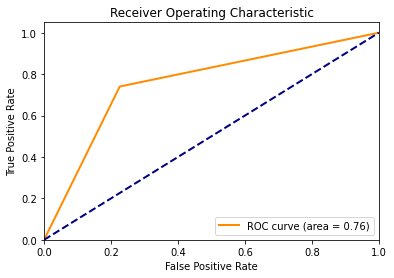

In [97]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Feature analysis

In [124]:
feature_list = mvp_features 

In [125]:
# feature importance
import numpy as np
print(f"Feature importance of ranker:")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = []
for f in range(_train_df.shape[1]):
    if f < len(indices):
        print(
            "%2d) %-*s %f" % (f + 1, 30, feature_list[indices[f]], importances[indices[f]])
        )
        feature_order.append(feature_list[indices[f]])

Feature importance of ranker:
 1) f_num_purchases_from_LEAF_cat_in_last_360_days 0.130000
 2) f_num_views_from_LEAF_cat_in_last_30_days 0.129347
 3) f_max_META_cat_view_propensity_jaccard_sim_in_last_360_days 0.103288
 4) f_max_LVL2_cat_view_propensity_jaccard_sim_in_last_360_days 0.085370
 5) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_360_days 0.072261
 6) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days 0.071416
 7) f_num_views_from_LEAF_cat_in_last_14_days 0.045144
 8) f_num_purchases_from_LVL2_cat_in_last_360_days 0.038388
 9) f_max_LEAF_cat_view_propensity_jaccard_sim_in_last_30_days 0.036690
10) f_num_views_from_LEAF_cat_in_last_360_days 0.036167
11) f_num_purchases_from_LEAF_cat_in_last_30_days 0.034847
12) f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days 0.034173
13) f_num_views_from_LEAF_cat_in_last_7_days 0.033016
14) f_time_since_last_view_from_LVL2_cat 0.027259
15) f_time_since_last_view_from_LEAF_cat 0.024496
16) f_num_purchases_from_LEAF_cat_in_l

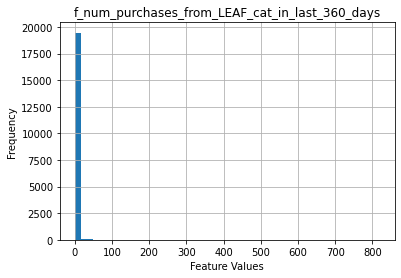

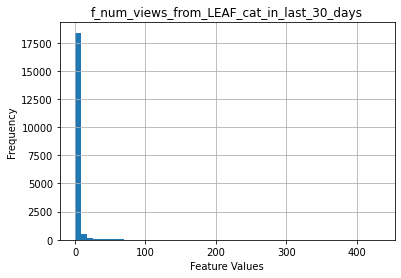

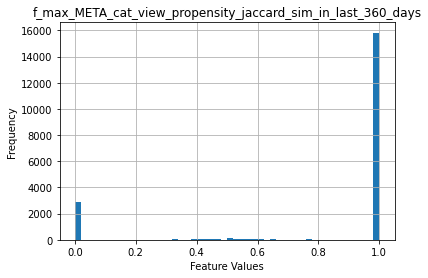

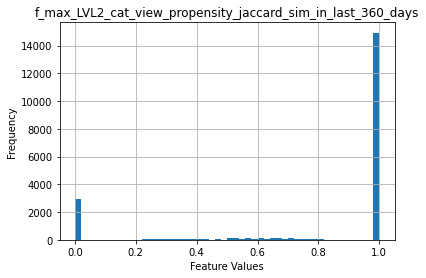

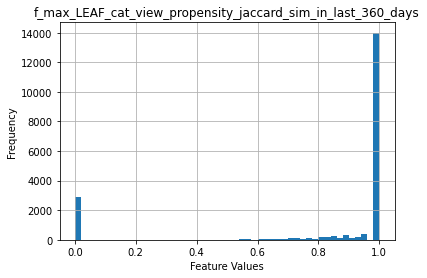

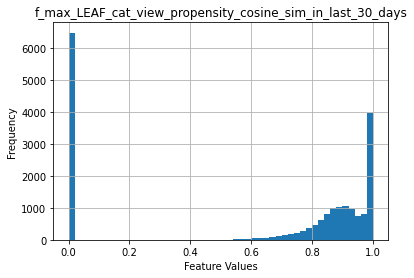

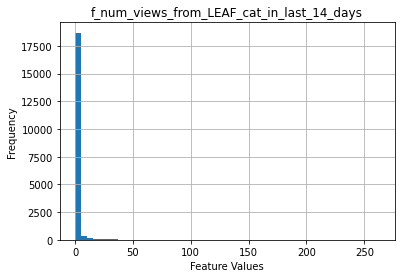

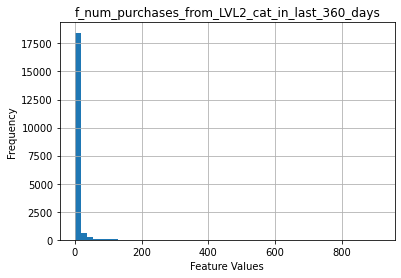

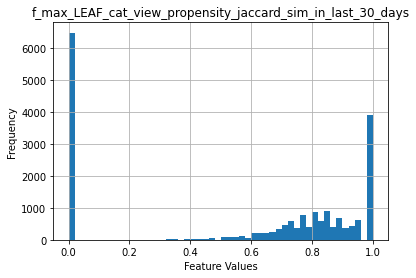

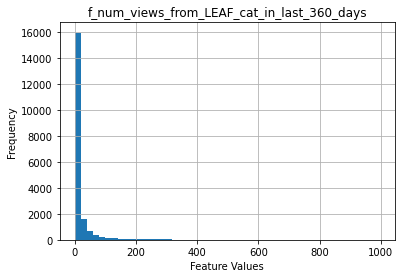

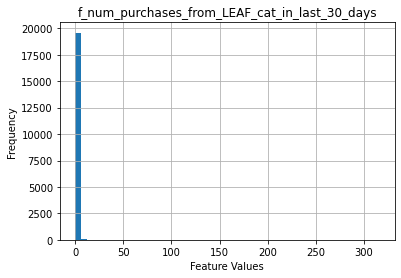

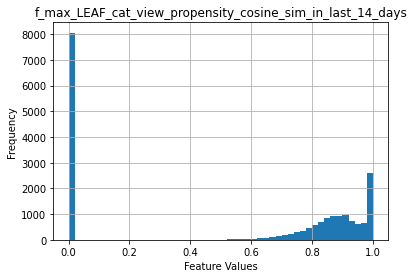

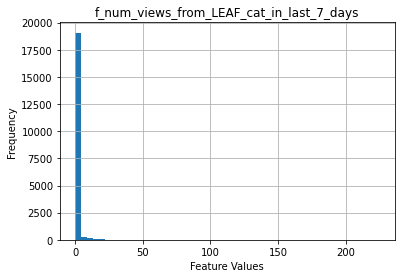

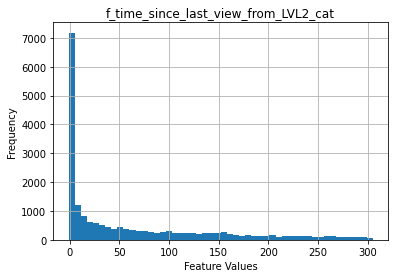

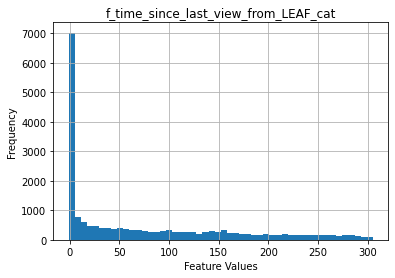

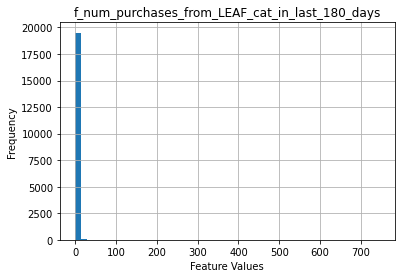

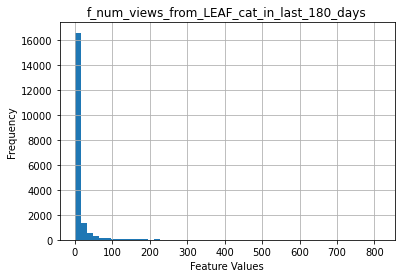

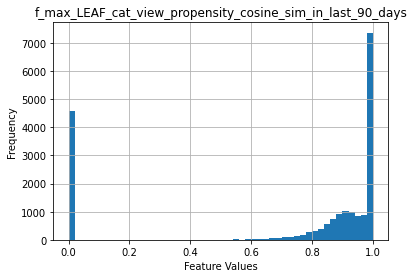

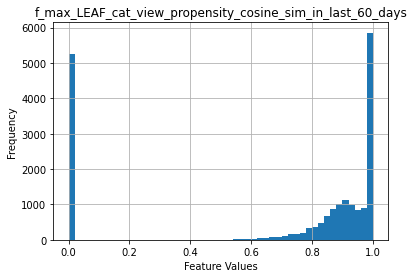

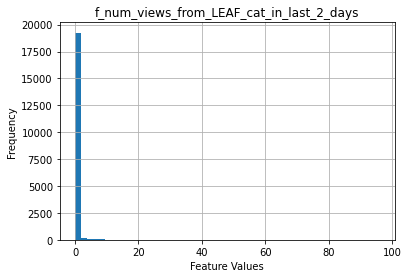

In [126]:
# feature distributions
import matplotlib.pyplot as plt

top_30_features = feature_order[0:30]
for i, feature_name in enumerate(top_30_features):
    eval_df[feature_name].hist(bins=50)
    plt.title(feature_name)
    plt.xlabel('Feature Values')
    plt.ylabel('Frequency')
    plt.show()

In [27]:
#!pip install shap --user --proxy=httpproxy-tcop.vip.ebay.com:80 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 545.7/545.7 kB 14.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 116.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 24.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
import shap 
import matplotlib.pyplot as plt
# Create the explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(_train_df[feature_list])

# Set the figure size
plt.figure(figsize=(20, 10))

shap.summary_plot(shap_values, _train_df[feature_list], plot_size=[30,20])

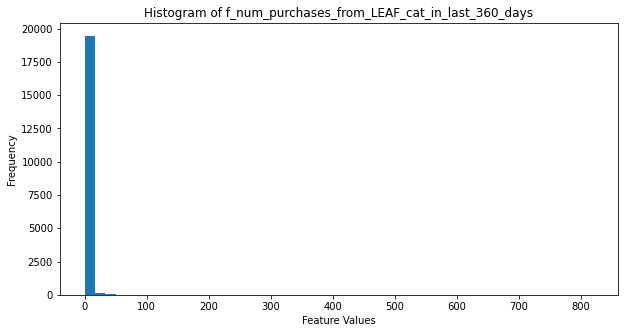

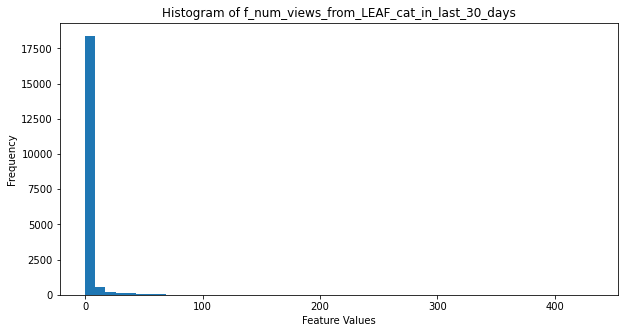

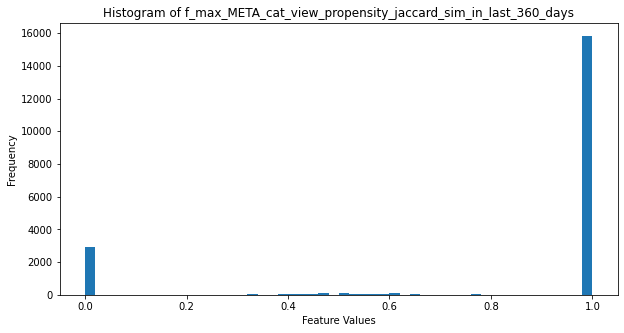

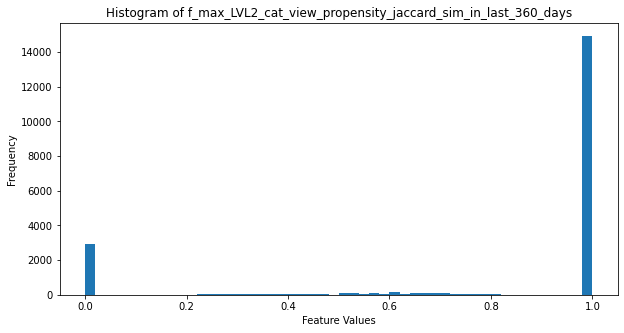

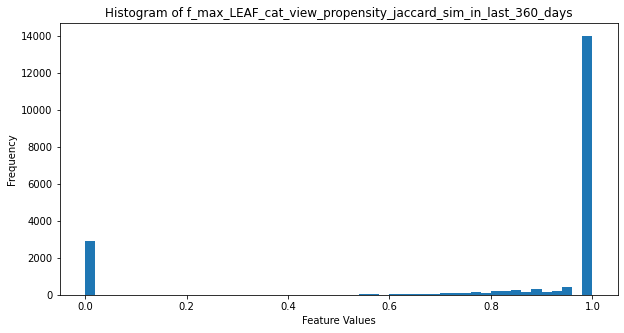

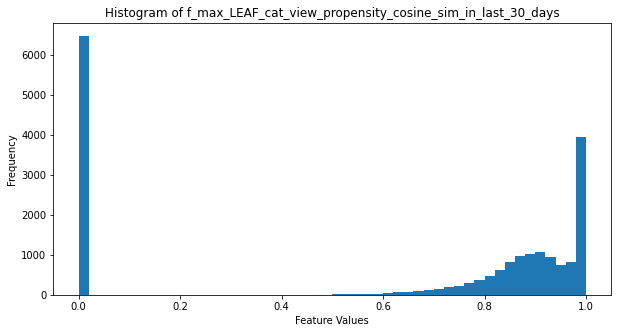

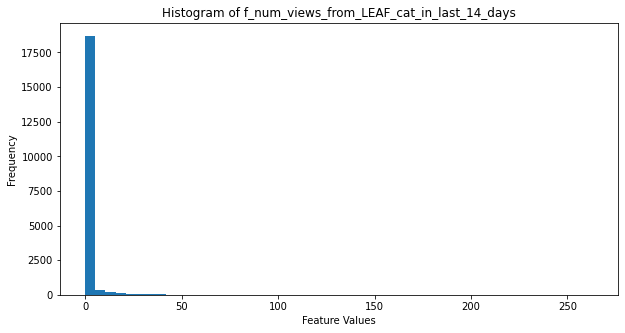

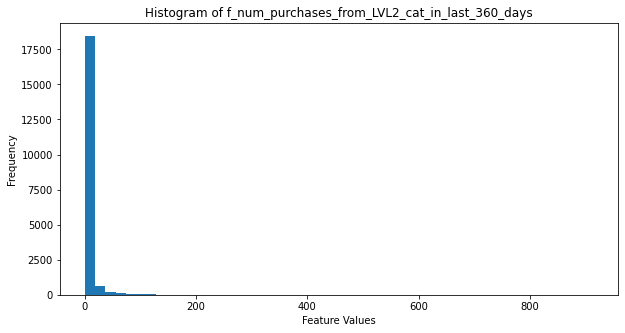

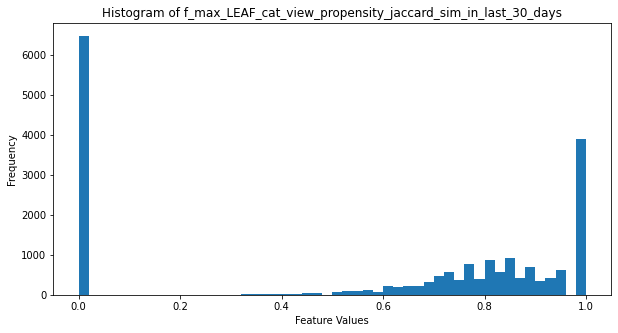

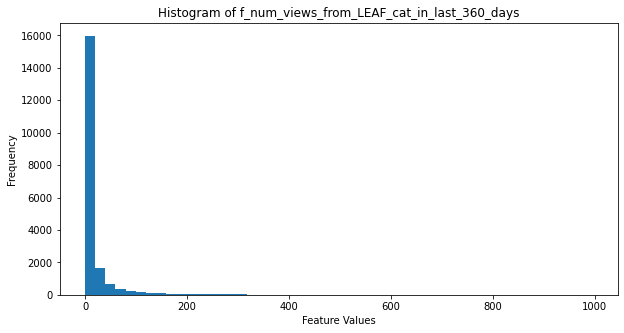

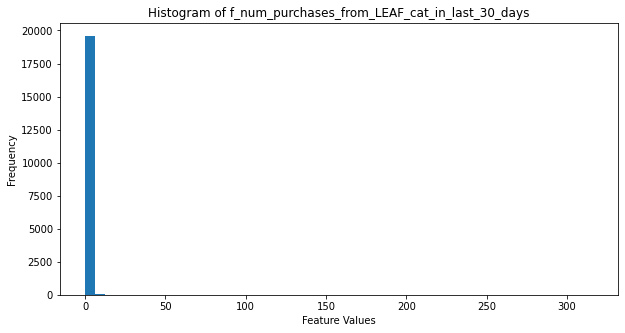

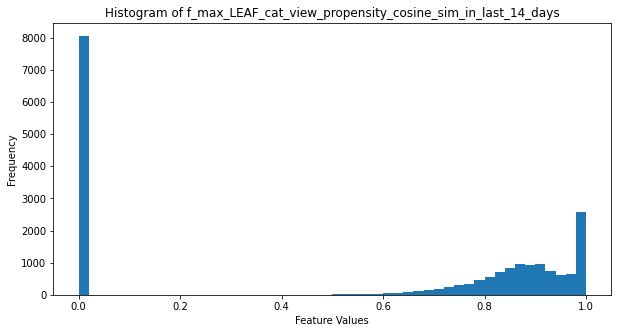

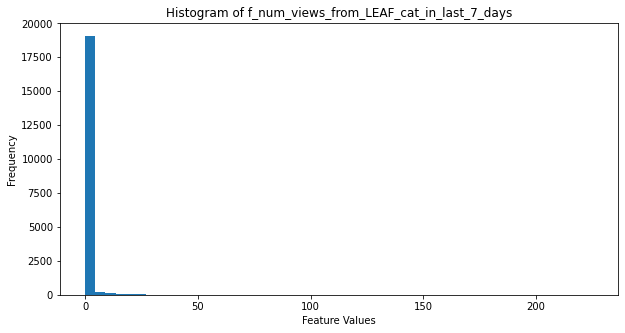

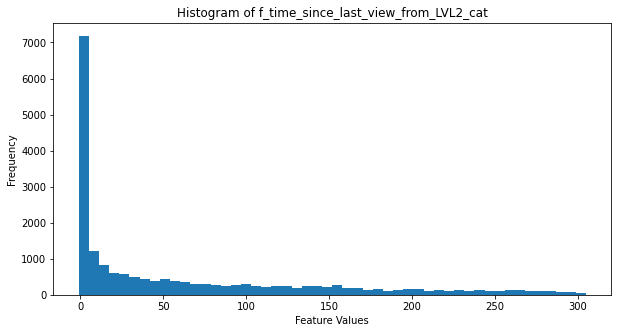

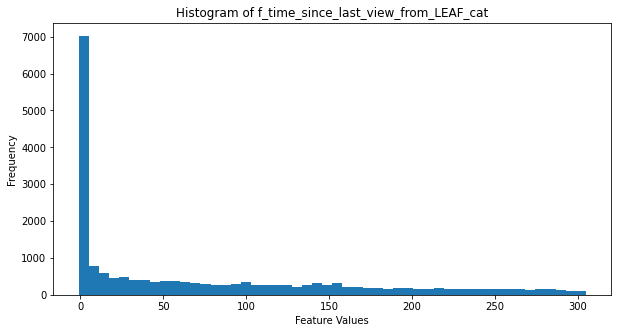

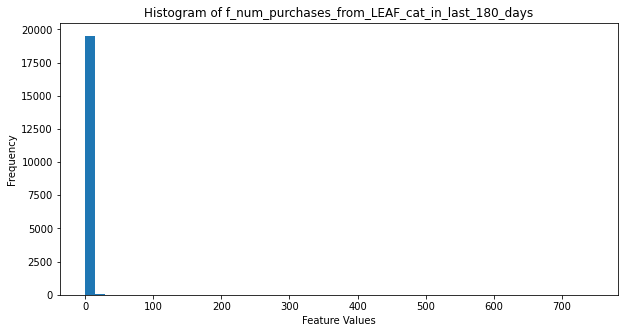

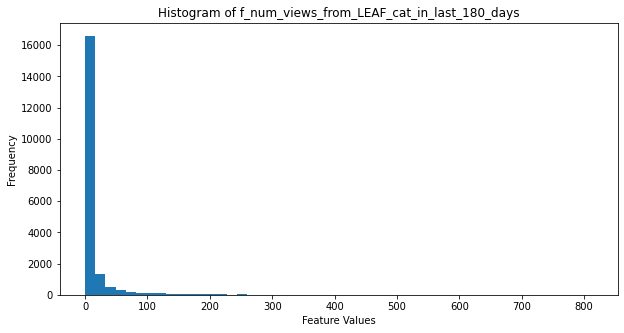

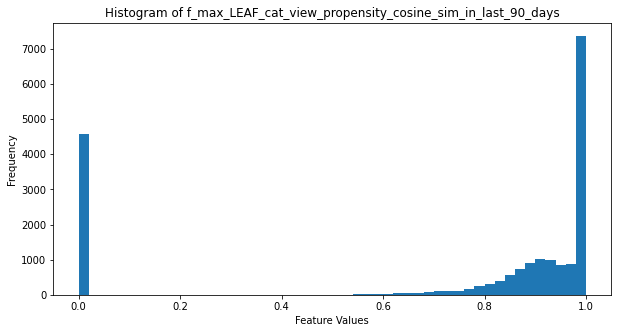

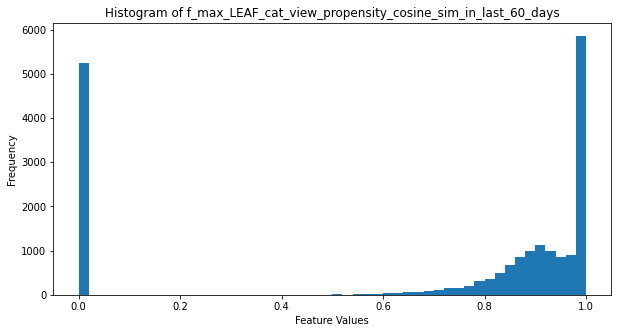

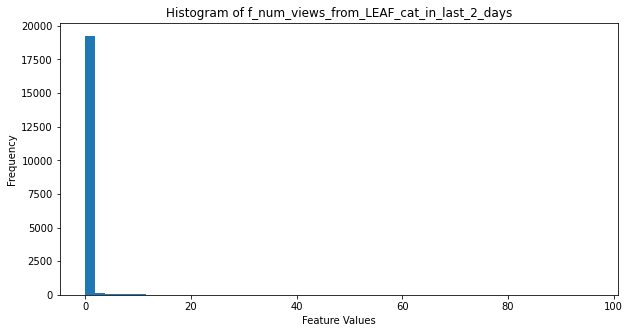

                                         Feature Name  Percent -1  Percent 0  \
0      f_num_purchases_from_LEAF_cat_in_last_360_days    0.000000   0.000000   
1           f_num_views_from_LEAF_cat_in_last_30_days    0.000000  82.310745   
2   f_max_META_cat_view_propensity_jaccard_sim_in_...    0.000000  14.860602   
3   f_max_LVL2_cat_view_propensity_jaccard_sim_in_...    0.000000  14.896215   
4   f_max_LEAF_cat_view_propensity_jaccard_sim_in_...    0.000000  14.860602   
5   f_max_LEAF_cat_view_propensity_cosine_sim_in_l...    0.000000  32.936508   
6           f_num_views_from_LEAF_cat_in_last_14_days    0.000000  88.817664   
7      f_num_purchases_from_LVL2_cat_in_last_360_days    0.000000   0.000000   
8   f_max_LEAF_cat_view_propensity_jaccard_sim_in_...    0.000000  32.936508   
9          f_num_views_from_LEAF_cat_in_last_360_days    0.000000  30.077330   
10      f_num_purchases_from_LEAF_cat_in_last_30_days    0.000000  87.657713   
11  f_max_LEAF_cat_view_propensity_cosin

In [127]:
import pandas as pd
import matplotlib.pyplot as plt

top_30_features = feature_order[0:30]  # Select the top 30 features

# Initialize a list to store the results
results = []

for feature_name in top_30_features:
    # Calculate counts
    total_count = eval_df[feature_name].count()  # Counts non-NaN values
    count_na = eval_df[feature_name].isna().sum()  # Count NaN values
    count_minus_one = (eval_df[feature_name] == -1).sum()
    count_zero = (eval_df[feature_name] == 0).sum()
    count_above_zero = (eval_df[feature_name] > 0).sum()
    
    # Calculate percentages
    percent_minus_one = (count_minus_one / total_count) * 100 if total_count > 0 else 0
    percent_zero = (count_zero / total_count) * 100 if total_count > 0 else 0
    percent_above_zero = (count_above_zero / total_count) * 100 if total_count > 0 else 0
    percent_na = (count_na / (total_count + count_na)) * 100 if (total_count + count_na) > 0 else 0  # Percentage of NaNs
    
    # Calculate average value excluding NaNs, -1, and 0
    average_value = eval_df[eval_df[feature_name] > 0][feature_name].mean()
    
    # Append the results to the list
    results.append({
        'Feature Name': feature_name,
        'Percent -1': percent_minus_one,
        'Percent 0': percent_zero,
        'Percent > 0': percent_above_zero,
        'Percent NA': percent_na,
        'Average Value (excluding -1 and 0)': average_value
    })
    
    # Plot histogram
    plt.figure(figsize=(10, 5))
    eval_df[feature_name].hist(bins=50)
    plt.title(f'Histogram of {feature_name}')
    plt.xlabel('Feature Values')
    plt.ylabel('Frequency')
    plt.grid(False)  # Optionally disable the grid
    plt.show()  # Display the plot

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Print the results
print(results_df)


In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kl_div

# Function to calculate Jensen-Shannon Divergence
def jensen_shannon_divergence(p, q):
    """Calculate the Jensen-Shannon divergence between two distributions."""
    p = p / np.sum(p)  # Normalize
    q = q / np.sum(q)  # Normalize
    m = 0.5 * (p + q)  # Average distribution
    return 0.5 * (kl_div(p, m).sum() + kl_div(q, m).sum())

# Function to calculate Overlap Coefficient
def overlap_coefficient(p, q):
    """Calculate the overlap coefficient between two distributions."""
    return np.sum(np.minimum(p, q))

# Initialize a list to store the results
results = []

# Loop through the top 30 features
for feature_name in top_30_features:
    # Calculate histograms for label 0 and label 1
    hist_0, bin_edges_0 = np.histogram(eval_df[eval_df['label'] == 0][feature_name], bins=50, density=True)
    hist_1, bin_edges_1 = np.histogram(eval_df[eval_df['label'] == 1][feature_name], bins=50, density=True)

    # Calculate JSD and Overlap
    jsd = jensen_shannon_divergence(hist_0, hist_1)
    overlap = overlap_coefficient(hist_0, hist_1)

    # Append the results to the list
    results.append({
        'Feature Name': feature_name,
        'Jensen-Shannon Divergence': jsd,
        'Overlap Coefficient': overlap
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Print the results
results_df


,Feature Name,Jensen-Shannon Divergence,Overlap Coefficient
0,f_num_purchases_from_LEAF_cat_in_last_360_days,0.013226,0.059886
1,f_num_views_from_LEAF_cat_in_last_30_days,0.053915,0.108261
2,f_max_META_cat_view_propensity_jaccard_sim_in_...,0.008792,46.401565
3,f_max_LVL2_cat_view_propensity_jaccard_sim_in_...,0.012480,46.514336
4,f_max_LEAF_cat_view_propensity_jaccard_sim_in_...,0.009501,46.357498
5,f_max_LEAF_cat_view_propensity_cosine_sim_in_l...,0.052997,36.304692
6,f_num_views_from_LEAF_cat_in_last_14_days,0.040445,0.157228
7,f_num_purchases_from_LVL2_cat_in_last_360_days,0.049335,0.046483
8,f_max_LEAF_cat_view_propensity_jaccard_sim_in_...,0.054478,36.234701
9,f_num_views_from_LEAF_cat_in_last_360_days,0.042438,0.044270


In [139]:
eval_df.columns

Index(['BUYER_ID', 'LEAF_CATEG_ID', 'f_time_since_last_purchase_from_LEAF_cat',
       'f_time_since_last_purchase_from_LVL2_cat',
       'f_time_since_last_purchase_from_META_cat',
       'f_time_since_last_view_from_LEAF_cat',
       'f_time_since_last_view_from_LVL2_cat',
       'f_time_since_last_view_from_META_cat',
       'f_num_purchases_from_LEAF_cat_in_last_1_days',
       'f_num_purchases_from_LEAF_cat_in_last_2_days',
       ...
       'EVENT_TIMESTAMP', 'label', 'num_repurchases', 'vi_label', 'preds',
       'preds_new', 'preds_top20_mvp_norm', 'preds_top20_from_mvp_actioncs',
       'preds_all_norm', 'preds_top20_all_norm'],
      dtype='object', length=981)

In [165]:

columns_to_show = [
    'preds', 'label', 'LEAF_CATEG_ID', 'BUYER_ID', 
    'f_num_purchases_from_LEAF_cat_in_last_360_days',
    'f_num_purchases_from_LEAF_cat_in_last_30_days',
    
    'f_num_purchases_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_14_days',
    'f_num_purchases_from_LVL2_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_7_days',
    
    'f_num_views_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_2_days'
]



filtered_df = eval_df[(eval_df['label'] == 1) & (eval_df['preds'] == 0)][columns_to_show]

filtered_df.head()


,preds,label,LEAF_CATEG_ID,BUYER_ID,f_num_purchases_from_LEAF_cat_in_last_360_days,f_num_purchases_from_LEAF_cat_in_last_30_days,f_num_purchases_from_LEAF_cat_in_last_180_days,f_num_views_from_LEAF_cat_in_last_30_days,f_num_views_from_LEAF_cat_in_last_14_days,f_num_purchases_from_LVL2_cat_in_last_360_days,f_num_views_from_LEAF_cat_in_last_360_days,f_num_views_from_LEAF_cat_in_last_7_days,f_num_views_from_LEAF_cat_in_last_180_days,f_num_views_from_LEAF_cat_in_last_2_days
0,0,1,259104,2326,1,0,1,0,0,1,0,0,0,0
13,0,1,28162,413827,2,1,2,0,0,2,7,0,7,0
73,0,1,126396,2939231,1,0,1,0,0,2,0,0,0,0
235,0,1,139973,14754203,2,1,2,3,0,2,3,0,3,0
291,0,1,19264,21528843,2,0,0,0,0,4,0,0,0,0


In [163]:

columns_to_show = [
    'preds', 'label', 'LEAF_CATEG_ID', 'BUYER_ID', 
    'f_num_purchases_from_LEAF_cat_in_last_360_days',
    'f_num_purchases_from_LEAF_cat_in_last_30_days',
    
    'f_num_purchases_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_14_days',
    'f_num_purchases_from_LVL2_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_7_days',
    
    'f_num_views_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_2_days'
]


filtered_df = eval_df[(eval_df['label'] == 1) & (eval_df['preds'] == 1)][columns_to_show]

filtered_df.head()

,preds,label,LEAF_CATEG_ID,BUYER_ID,f_num_purchases_from_LEAF_cat_in_last_360_days,f_num_purchases_from_LEAF_cat_in_last_30_days,f_num_purchases_from_LEAF_cat_in_last_180_days,f_num_views_from_LEAF_cat_in_last_30_days,f_num_views_from_LEAF_cat_in_last_14_days,f_num_purchases_from_LVL2_cat_in_last_360_days,f_num_views_from_LEAF_cat_in_last_360_days,f_num_views_from_LEAF_cat_in_last_7_days,f_num_views_from_LEAF_cat_in_last_180_days,f_num_views_from_LEAF_cat_in_last_2_days
5,1,1,11484,223332,15,0,11,0,0,79,0,0,0,0
27,1,1,36028,730662,1,1,1,0,0,3,0,0,0,0
28,1,1,262023,738292,2,0,2,0,0,2,0,0,0,0
36,1,1,62107,1181598,4,1,1,24,5,7,45,3,45,1
37,1,1,234,1264085,12,0,9,0,0,208,0,0,0,0


In [195]:
# Import necessary library
import pandas as pd

# Define the features to analyze
features_to_analyze = [
    'f_num_purchases_from_LEAF_cat_in_last_360_days',
    'f_num_purchases_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_14_days',
    'f_num_purchases_from_LVL2_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_7_days',
    'f_time_since_last_view_from_LVL2_cat',
    'f_time_since_last_view_from_LEAF_cat',
    'f_num_purchases_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_2_days',
    'f_norm_num_views_from_LEAF_cat_in_last_30_days',
    'f_norm_num_purchases_from_LEAF_cat_in_last_30_days',
    'f_norm_num_views_from_LEAF_cat_in_last_7_days'
    
] 
# Filter the data for cases where label == 1
label_1_df = eval_df[eval_df['label'] == 1]

# Separate data for label == 1 into two groups based on prediction
pred_0 = label_1_df[label_1_df['preds'] == 0]
pred_1 = label_1_df[label_1_df['preds'] == 1]

# Initialize dictionaries to store results
mean_pred_0, mean_pred_1 = {}, {}
std_pred_0, std_pred_1 = {}, {}

# Calculate mean and standard deviation only for values > -1
for feature in features_to_analyze:
    # Filter values > -1 for each feature
    pred_0_filtered = pred_0[feature][pred_0[feature] > -1]
    pred_1_filtered = pred_1[feature][pred_1[feature] > -1]

    # Calculate mean and standard deviation
    mean_pred_0[feature] = pred_0_filtered.mean()
    std_pred_0[feature] = pred_0_filtered.std()
    mean_pred_1[feature] = pred_1_filtered.mean()
    std_pred_1[feature] = pred_1_filtered.std()

# Calculate the difference and ratio between the means
difference = {feature: mean_pred_1[feature] - mean_pred_0[feature] for feature in features_to_analyze}
ratio = {feature: mean_pred_1[feature] / (mean_pred_0[feature] + 1e-10) for feature in features_to_analyze}  # Avoid division by zero

# Create a DataFrame to display results
comparison_df = pd.DataFrame({
    'Feature': features_to_analyze,
    'Mean (Pred = 0)': pd.Series(mean_pred_0),
    'Std (Pred = 0)': pd.Series(std_pred_0),
    'Mean (Pred = 1)': pd.Series(mean_pred_1),
    'Std (Pred = 1)': pd.Series(std_pred_1),
    'Difference': pd.Series(difference),
    'Ratio (Pred = 1 / Pred = 0)': pd.Series(ratio)
})

# Round all numeric columns to 2 decimal places
comparison_df = comparison_df.round(2)

# Convert ratio to fixed-point format and round
comparison_df['Ratio (Pred = 1 / Pred = 0)'] = comparison_df['Ratio (Pred = 1 / Pred = 0)'].apply(lambda x: f"{x:.2f}")

# Sort the DataFrame by the original order of features
comparison_df['Importance Order'] = comparison_df['Feature'].apply(lambda x: features_to_analyze.index(x))
comparison_df.sort_values(by='Importance Order', ascending=True, inplace=True)
comparison_df.reset_index(drop=True, inplace=True)

# Table title
table_title = "Feature's Values for label == 1, TP pred == 1, FN pred == 0"
print(table_title)

# Display the comparison DataFrame
comparison_df[['Feature', 'Mean (Pred = 0)', 'Std (Pred = 0)', 'Mean (Pred = 1)', 'Std (Pred = 1)'
               , 'Difference', 'Ratio (Pred = 1 / Pred = 0)']]


Feature's Values for label == 1, TP pred == 1, FN pred == 0


,Feature,Mean (Pred = 0),Std (Pred = 0),Mean (Pred = 1),Std (Pred = 1),Difference,Ratio (Pred = 1 / Pred = 0)
0,f_num_purchases_from_LEAF_cat_in_last_360_days,1.52,1.01,14.47,49.78,12.95,9.52
1,f_num_purchases_from_LEAF_cat_in_last_30_days,0.06,0.27,2.63,16.21,2.57,41.28
2,f_num_views_from_LEAF_cat_in_last_30_days,0.16,1.00,18.53,41.12,18.37,112.91
3,f_num_views_from_LEAF_cat_in_last_14_days,0.01,0.13,10.05,25.68,10.03,826.35
4,f_num_purchases_from_LVL2_cat_in_last_360_days,4.73,11.11,32.17,76.10,27.44,6.80
5,f_num_views_from_LEAF_cat_in_last_360_days,8.40,21.40,66.38,122.06,57.98,7.90
6,f_num_views_from_LEAF_cat_in_last_7_days,0.01,0.08,5.09,14.65,5.08,837.05
7,f_time_since_last_view_from_LVL2_cat,80.32,72.23,12.17,20.98,-68.16,0.15
8,f_time_since_last_view_from_LEAF_cat,130.79,75.74,17.61,25.59,-113.17,0.13
9,f_num_purchases_from_LEAF_cat_in_last_180_days,0.83,0.79,9.96,40.16,9.13,12.04


In [200]:
import pandas as pd

# Data for label == 0 (FP pred == 1, TN pred == 0)
data_label_0 = {
    'Feature': [
        'f_num_purchases_from_LEAF_cat_in_last_360_days',
        'f_num_purchases_from_LEAF_cat_in_last_30_days',
        'f_num_views_from_LEAF_cat_in_last_30_days',
        'f_num_views_from_LEAF_cat_in_last_14_days',
        'f_num_purchases_from_LVL2_cat_in_last_360_days',
        'f_num_views_from_LEAF_cat_in_last_360_days',
        'f_num_views_from_LEAF_cat_in_last_7_days',
        'f_time_since_last_view_from_LVL2_cat',
        'f_time_since_last_view_from_LEAF_cat',
        'f_num_purchases_from_LEAF_cat_in_last_180_days',
        'f_num_views_from_LEAF_cat_in_last_180_days',
        'f_num_views_from_LEAF_cat_in_last_2_days'
    ],
    'Mean (Pred = 0)': [1.21, 0.05, 0.14, 0.03, 2.59, 7.17, 0.00, 112.31, 144.34, 0.67, 3.83, 0.00],
    'Std (Pred = 0)': [0.67, 0.22, 0.86, 0.31, 6.45, 15.23, 0.09, 82.85, 78.79, 0.68, 9.15, 0.01],
    'Mean (Pred = 1)': [2.99, 0.43, 7.31, 3.44, 13.01, 43.70, 1.61, 18.11, 28.86, 1.95, 33.04, 0.40],
    'Std (Pred = 1)': [7.13, 1.72, 22.37, 12.19, 35.07, 91.05, 7.72, 27.58, 33.44, 4.66, 70.82, 2.69],
}

# Data for label == 1 (TP pred == 1, FN pred == 0)
data_label_1 = {
    'Feature': [
        'f_num_purchases_from_LEAF_cat_in_last_360_days',
        'f_num_purchases_from_LEAF_cat_in_last_30_days',
        'f_num_views_from_LEAF_cat_in_last_30_days',
        'f_num_views_from_LEAF_cat_in_last_14_days',
        'f_num_purchases_from_LVL2_cat_in_last_360_days',
        'f_num_views_from_LEAF_cat_in_last_360_days',
        'f_num_views_from_LEAF_cat_in_last_7_days',
        'f_time_since_last_view_from_LVL2_cat',
        'f_time_since_last_view_from_LEAF_cat',
        'f_num_purchases_from_LEAF_cat_in_last_180_days',
        'f_num_views_from_LEAF_cat_in_last_180_days',
        'f_num_views_from_LEAF_cat_in_last_2_days'
    ],
    'Mean (Pred = 0)': [1.52, 0.06, 0.16, 0.01, 4.73, 8.40, 0.01, 80.32, 130.79, 0.83, 4.12, 0.00],
    'Std (Pred = 0)': [1.01, 0.27, 1.00, 0.13, 11.11, 21.40, 0.08, 72.23, 75.74, 0.79, 12.50, 0.00],
    'Mean (Pred = 1)': [14.47, 2.63, 18.53, 10.05, 32.17, 66.38, 5.09, 12.17, 17.61, 9.96, 55.18, 1.50],
    'Std (Pred = 1)': [49.78, 16.21, 41.12, 25.68, 76.10, 122.06, 14.65, 20.98, 25.59, 40.16, 106.75, 5.46],
}

# Creating DataFrames
df_label_0 = pd.DataFrame(data_label_0)
df_label_1 = pd.DataFrame(data_label_1)

# Merging DataFrames on the 'Feature' column
df_diff = pd.merge(df_label_0, df_label_1, on='Feature', suffixes=('_0', '_1'))

# Display the columns of the merged DataFrame to check naming
print("Merged DataFrame columns:", df_diff.columns)

# Calculating differences for Mean and Std values
df_diff['Difference Mean (Pred = 0)'] = df_diff['Mean (Pred = 0)_1'] - df_diff['Mean (Pred = 0)_0']
df_diff['Difference Std (Pred = 0)'] = df_diff['Std (Pred = 0)_1'] - df_diff['Std (Pred = 0)_0']
df_diff['Difference Mean (Pred = 1)'] = df_diff['Mean (Pred = 1)_1'] - df_diff['Mean (Pred = 1)_0']
df_diff['Difference Std (Pred = 1)'] = df_diff['Std (Pred = 1)_1'] - df_diff['Std (Pred = 1)_0']

# Displaying the final differences DataFrame
print("\nDifferences between label == 1 and label ==0 values:")
df_diff


Merged DataFrame columns: Index(['Feature', 'Mean (Pred = 0)_0', 'Std (Pred = 0)_0', 'Mean (Pred = 1)_0',
       'Std (Pred = 1)_0', 'Mean (Pred = 0)_1', 'Std (Pred = 0)_1',
       'Mean (Pred = 1)_1', 'Std (Pred = 1)_1'],
      dtype='object')

Differences between label == 1 and label ==0 values:


,Feature,Mean (Pred = 0)_0,Std (Pred = 0)_0,Mean (Pred = 1)_0,Std (Pred = 1)_0,Mean (Pred = 0)_1,Std (Pred = 0)_1,Mean (Pred = 1)_1,Std (Pred = 1)_1,Difference Mean (Pred = 0),Difference Std (Pred = 0),Difference Mean (Pred = 1),Difference Std (Pred = 1)
0,f_num_purchases_from_LEAF_cat_in_last_360_days,1.21,0.67,2.99,7.13,1.52,1.01,14.47,49.78,0.31,0.34,11.48,42.65
1,f_num_purchases_from_LEAF_cat_in_last_30_days,0.05,0.22,0.43,1.72,0.06,0.27,2.63,16.21,0.01,0.05,2.20,14.49
2,f_num_views_from_LEAF_cat_in_last_30_days,0.14,0.86,7.31,22.37,0.16,1.00,18.53,41.12,0.02,0.14,11.22,18.75
3,f_num_views_from_LEAF_cat_in_last_14_days,0.03,0.31,3.44,12.19,0.01,0.13,10.05,25.68,-0.02,-0.18,6.61,13.49
4,f_num_purchases_from_LVL2_cat_in_last_360_days,2.59,6.45,13.01,35.07,4.73,11.11,32.17,76.10,2.14,4.66,19.16,41.03
5,f_num_views_from_LEAF_cat_in_last_360_days,7.17,15.23,43.70,91.05,8.40,21.40,66.38,122.06,1.23,6.17,22.68,31.01
6,f_num_views_from_LEAF_cat_in_last_7_days,0.00,0.09,1.61,7.72,0.01,0.08,5.09,14.65,0.01,-0.01,3.48,6.93
7,f_time_since_last_view_from_LVL2_cat,112.31,82.85,18.11,27.58,80.32,72.23,12.17,20.98,-31.99,-10.62,-5.94,-6.60
8,f_time_since_last_view_from_LEAF_cat,144.34,78.79,28.86,33.44,130.79,75.74,17.61,25.59,-13.55,-3.05,-11.25,-7.85
9,f_num_purchases_from_LEAF_cat_in_last_180_days,0.67,0.68,1.95,4.66,0.83,0.79,9.96,40.16,0.16,0.11,8.01,35.50


In [198]:
# Import necessary library
import pandas as pd

# Define the features to analyze
features_to_analyze = [
    'f_num_purchases_from_LEAF_cat_in_last_360_days',
    'f_num_purchases_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_14_days',
    'f_num_purchases_from_LVL2_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_7_days',
    'f_time_since_last_view_from_LVL2_cat',
    'f_time_since_last_view_from_LEAF_cat',
    'f_num_purchases_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_2_days',
    'f_norm_num_views_from_LEAF_cat_in_last_30_days',
    'f_norm_num_purchases_from_LEAF_cat_in_last_30_days',
    'f_norm_num_views_from_LEAF_cat_in_last_7_days'
    
] 


# Filter the data for cases where label == 1
label_1_df = eval_df[eval_df['label'] == 0]

# Separate data for label == 1 into two groups based on prediction
pred_0 = label_1_df[label_1_df['preds'] == 0]
pred_1 = label_1_df[label_1_df['preds'] == 1]

# Initialize dictionaries to store results
mean_pred_0, mean_pred_1 = {}, {}
std_pred_0, std_pred_1 = {}, {}

# Calculate mean and standard deviation only for values > -1
for feature in features_to_analyze:
    # Filter values > -1 for each feature
    pred_0_filtered = pred_0[feature][pred_0[feature] > -1]
    pred_1_filtered = pred_1[feature][pred_1[feature] > -1]

    # Calculate mean and standard deviation
    mean_pred_0[feature] = pred_0_filtered.mean()
    std_pred_0[feature] = pred_0_filtered.std()
    mean_pred_1[feature] = pred_1_filtered.mean()
    std_pred_1[feature] = pred_1_filtered.std()

# Calculate the difference and ratio between the means
difference = {feature: mean_pred_1[feature] - mean_pred_0[feature] for feature in features_to_analyze}
ratio = {feature: mean_pred_1[feature] / (mean_pred_0[feature] + 1e-10) for feature in features_to_analyze}  # Avoid division by zero

# Create a DataFrame to display results
comparison_df = pd.DataFrame({
    'Feature': features_to_analyze,
    'Mean (Pred = 0)': pd.Series(mean_pred_0),
    'Std (Pred = 0)': pd.Series(std_pred_0),
    'Mean (Pred = 1)': pd.Series(mean_pred_1),
    'Std (Pred = 1)': pd.Series(std_pred_1),
    'Difference': pd.Series(difference),
    'Ratio (Pred = 1 / Pred = 0)': pd.Series(ratio)
})

# Round all numeric columns to 2 decimal places
comparison_df = comparison_df.round(2)

# Convert ratio to fixed-point format and round
comparison_df['Ratio (Pred = 1 / Pred = 0)'] = comparison_df['Ratio (Pred = 1 / Pred = 0)'].apply(lambda x: f"{x:.2f}")

# Sort the DataFrame by the original order of features
comparison_df['Importance Order'] = comparison_df['Feature'].apply(lambda x: features_to_analyze.index(x))
comparison_df.sort_values(by='Importance Order', ascending=True, inplace=True)
comparison_df.reset_index(drop=True, inplace=True)

# Table title
table_title = "Feature's Values for label == 0, FP pred == 1, TN pred == 0"
print(table_title)

# Display the comparison DataFrame
comparison_df[['Feature', 'Mean (Pred = 0)', 'Std (Pred = 0)', 'Mean (Pred = 1)', 'Std (Pred = 1)'
               , 'Difference', 'Ratio (Pred = 1 / Pred = 0)']]


Feature's Values for label == 0, FP pred == 1, TN pred == 0


,Feature,Mean (Pred = 0),Std (Pred = 0),Mean (Pred = 1),Std (Pred = 1),Difference,Ratio (Pred = 1 / Pred = 0)
0,f_num_purchases_from_LEAF_cat_in_last_360_days,1.21,0.67,2.99,7.13,1.78,2.47
1,f_num_purchases_from_LEAF_cat_in_last_30_days,0.05,0.22,0.43,1.72,0.39,9.53
2,f_num_views_from_LEAF_cat_in_last_30_days,0.14,0.86,7.31,22.37,7.17,52.48
3,f_num_views_from_LEAF_cat_in_last_14_days,0.03,0.31,3.44,12.19,3.42,124.50
4,f_num_purchases_from_LVL2_cat_in_last_360_days,2.59,6.45,13.01,35.07,10.42,5.02
5,f_num_views_from_LEAF_cat_in_last_360_days,7.17,15.23,43.70,91.05,36.53,6.09
6,f_num_views_from_LEAF_cat_in_last_7_days,0.00,0.09,1.61,7.72,1.61,485.11
7,f_time_since_last_view_from_LVL2_cat,112.31,82.85,18.11,27.58,-94.20,0.16
8,f_time_since_last_view_from_LEAF_cat,144.34,78.79,28.86,33.44,-115.48,0.20
9,f_num_purchases_from_LEAF_cat_in_last_180_days,0.67,0.68,1.95,4.66,1.28,2.91


In [212]:
eval_df.f_num_views_from_LEAF_cat_in_last_14_days

0        0
1        0
2        0
3        0
4        0
        ..
20063    0
20064    0
20065    0
20068    0
20069    0
Name: f_num_views_from_LEAF_cat_in_last_14_days, Length: 19656, dtype: int64

In [222]:
def calculate_weighted_norm_and_compare(df):
    # Create a copy of the DataFrame
    df_copy = df.copy()
    
    # Define the weights for the different time windows
    weights = {
        '_2_days': 0.1,
        '_7_days': 0.2,
        '_30_days': 0.3,
        '_90_days': 0.25,
        '_180_days': 0.15,
        '_360_days': 0.05
    }
    
    # List of base features to create weighted features for
    features = ['f_num_views_from_LEAF_cat_in_last', 'f_num_purchases_from_LEAF_cat_in_last']
    
    # Calculate weighted features and add them to df_copy
    for feature in features:
        weighted_feature_col = f'f_weighted_{feature.split("_in_last")[0]}'
        
        # Calculate the weighted feature, only using positive values
        df_copy[weighted_feature_col] = (
            df_copy[feature + '_2_days'].where(df_copy[feature + '_2_days'] > 0, 0) * weights['_2_days'] +
            df_copy[feature + '_7_days'].where(df_copy[feature + '_7_days'] > 0, 0) * weights['_7_days'] +
            df_copy[feature + '_30_days'].where(df_copy[feature + '_30_days'] > 0, 0) * weights['_30_days'] +
            df_copy[feature + '_90_days'].where(df_copy[feature + '_90_days'] > 0, 0) * weights['_90_days'] +
            df_copy[feature + '_180_days'].where(df_copy[feature + '_180_days'] > 0, 0) * weights['_180_days'] +
            df_copy[feature + '_360_days'].where(df_copy[feature + '_360_days'] > 0, 0) * weights['_360_days']
        ).round(3)
    
    # Display comparison of the weighted feature statistics for label = 0 and label = 1
    comparison_results = {}
    for feature in features:
        weighted_feature_col = f'f_weighted_{feature.split("_in_last")[0]}'
        comparison_results[weighted_feature_col] = {
            'label_0_mean': df_copy[df_copy['label'] == 0][weighted_feature_col].mean(),
            'label_0_std': df_copy[df_copy['label'] == 0][weighted_feature_col].std(),
            'label_1_mean': df_copy[df_copy['label'] == 1][weighted_feature_col].mean(),
            'label_1_std': df_copy[df_copy['label'] == 1][weighted_feature_col].std()
        }

    # Print the comparison results
    for feature, stats in comparison_results.items():
        print(f"Feature: {feature}")
        print(f"  Label 0 - Mean: {stats['label_0_mean']:.3f}, Std: {stats['label_0_std']:.3f}")
        print(f"  Label 1 - Mean: {stats['label_1_mean']:.3f}, Std: {stats['label_1_std']:.3f}\n")

# Call the function with eval_df
calculate_weighted_norm_and_compare(eval_df)


Feature: f_weighted_f_num_views_from_LEAF_cat
  Label 0 - Mean: 4.829, Std: 16.869
  Label 1 - Mean: 21.433, Std: 46.492

Feature: f_weighted_f_num_purchases_from_LEAF_cat
  Label 0 - Mean: 0.404, Std: 1.059
  Label 1 - Mean: 3.489, Std: 16.297



In [223]:
def calculate_weighted_norm_and_compare(df):
    # Create a copy of the DataFrame
    df_copy = df.copy()
    
    # Define the weights for the different time windows
    weights = {
        '_2_days': 0.1,
        '_7_days': 0.2,
        '_30_days': 0.3,
        '_90_days': 0.25,
        '_180_days': 0.15,
        '_360_days': 0.05
    }
    
    # List of base features to create weighted features for
    features = ['f_num_views_from_LEAF_cat_in_last', 'f_num_purchases_from_LEAF_cat_in_last']
    
    # Calculate weighted features and add them to df_copy
    for feature in features:
        weighted_feature_col = f'f_weighted_{feature.split("_in_last")[0]}'
        
        # Calculate the weighted feature, only using positive values
        df_copy[weighted_feature_col] = (
            df_copy[feature + '_2_days'].where(df_copy[feature + '_2_days'] > 0, 0) * weights['_2_days'] +
            df_copy[feature + '_7_days'].where(df_copy[feature + '_7_days'] > 0, 0) * weights['_7_days'] +
            df_copy[feature + '_30_days'].where(df_copy[feature + '_30_days'] > 0, 0) * weights['_30_days'] +
            df_copy[feature + '_90_days'].where(df_copy[feature + '_90_days'] > 0, 0) * weights['_90_days'] +
            df_copy[feature + '_180_days'].where(df_copy[feature + '_180_days'] > 0, 0) * weights['_180_days'] +
            df_copy[feature + '_360_days'].where(df_copy[feature + '_360_days'] > 0, 0) * weights['_360_days']
        ).round(3)
    
    # Define the comparison categories
    categories = {
        'label_1_preds_0': (df_copy['label'] == 1) & (df_copy['preds'] == 0),
        'label_1_preds_1': (df_copy['label'] == 1) & (df_copy['preds'] == 1),
        'label_0_preds_1': (df_copy['label'] == 0) & (df_copy['preds'] == 1),
        'label_0_preds_0': (df_copy['label'] == 0) & (df_copy['preds'] == 0)
    }

    # Initialize dictionary for comparison results
    comparison_results = {}
    
    for feature in features:
        weighted_feature_col = f'f_weighted_{feature.split("_in_last")[0]}'
        # Calculate stats for each category and add to comparison results
        comparison_results[weighted_feature_col] = {}
        for category_name, condition in categories.items():
            filtered_values = df_copy[weighted_feature_col][condition]
            comparison_results[weighted_feature_col][category_name] = {
                'mean': filtered_values.mean(),
                'std': filtered_values.std()
            }

    # Print the comparison results
    for feature, stats in comparison_results.items():
        print(f"Feature: {feature}")
        for category, values in stats.items():
            print(f"  {category} - Mean: {values['mean']:.3f}, Std: {values['std']:.3f}")
        print("\n")

# Call the function with eval_df
calculate_weighted_norm_and_compare(eval_df)


Feature: f_weighted_f_num_views_from_LEAF_cat
  label_1_preds_0 - Mean: 1.388, Std: 3.024
  label_1_preds_1 - Mean: 28.295, Std: 52.099
  label_0_preds_1 - Mean: 14.808, Std: 30.456
  label_0_preds_0 - Mean: 1.255, Std: 2.431


Feature: f_weighted_f_num_purchases_from_LEAF_cat
  label_1_preds_0 - Mean: 0.307, Std: 0.317
  label_1_preds_1 - Mean: 4.578, Std: 18.759
  label_0_preds_1 - Mean: 0.872, Std: 1.953
  label_0_preds_0 - Mean: 0.237, Std: 0.225




In [224]:
import pandas as pd
import numpy as np

# Define the feature patterns and time windows for weighted calculations
view_purchase_feature_patterns = [
    'f_num_views_from_LEAF_cat_in_last',
    'f_num_purchases_from_LEAF_cat_in_last',
    'f_num_views_from_LVL2_cat_in_last',
    'f_num_views_from_META_cat_in_last',
    'f_num_purchases_from_LVL2_cat_in_last',
    'f_num_purchases_from_META_cat_in_last'
]
time_windows = [2, 7, 30, 90, 180, 360]
weights = [0.35, 0.25, 0.2, 0.1, 0.05, 0.05]  # Adjusted weights for each time window

# Make a copy of the original dataframe to add weighted features
eval_df_copy = eval_df.copy()

# Calculate the weighted features for each feature pattern
for feature_pattern in view_purchase_feature_patterns:
    weighted_feature_name = f"f_weighted_{feature_pattern}"
    
    # Calculate weighted sum for the feature pattern across all specified time windows
    eval_df_copy[weighted_feature_name] = sum(
        weights[i] * eval_df_copy.get(f"{feature_pattern}_{time_windows[i]}_days", 0).apply(lambda x: x if x > -1 else 0)
        for i in range(len(time_windows))
    )

# Function to compute statistics for feature values by label and prediction group
def get_stats_by_group(df, feature):
    stats = {}
    groups = {
        'label_1_preds_0': df[(df['label'] == 1) & (df['preds'] == 0)],
        'label_1_preds_1': df[(df['label'] == 1) & (df['preds'] == 1)],
        'label_0_preds_1': df[(df['label'] == 0) & (df['preds'] == 1)],
        'label_0_preds_0': df[(df['label'] == 0) & (df['preds'] == 0)]
    }
    
    for group_name, group_df in groups.items():
        feature_vals = group_df[feature]
        feature_vals = feature_vals[feature_vals > -1]  # Filter for values > -1
        stats[group_name] = {
            'Mean': round(feature_vals.mean(), 3),
            'Std': round(feature_vals.std(), 3)
        }
    return stats

# Compute and display statistics for each weighted feature across label and prediction groups
for feature_pattern in view_purchase_feature_patterns:
    weighted_feature_name = f"f_weighted_{feature_pattern}"
    print(f"\nFeature: {weighted_feature_name}")
    feature_stats = get_stats_by_group(eval_df_copy, weighted_feature_name)
    for group, stats in feature_stats.items():
        print(f"  {group} - Mean: {stats['Mean']}, Std: {stats['Std']}")



Feature: f_weighted_f_num_views_from_LEAF_cat_in_last
  label_1_preds_0 - Mean: 0.78, Std: 1.666
  label_1_preds_1 - Mean: 15.571, Std: 28.064
  label_0_preds_1 - Mean: 7.887, Std: 16.054
  label_0_preds_0 - Mean: 0.691, Std: 1.271

Feature: f_weighted_f_num_purchases_from_LEAF_cat_in_last
  label_1_preds_0 - Mean: 0.17, Std: 0.184
  label_1_preds_1 - Mean: 2.518, Std: 10.284
  label_0_preds_1 - Mean: 0.482, Std: 1.014
  label_0_preds_0 - Mean: 0.129, Std: 0.107

Feature: f_weighted_f_num_views_from_LVL2_cat_in_last
  label_1_preds_0 - Mean: 4.091, Std: 9.524
  label_1_preds_1 - Mean: 31.63, Std: 46.258
  label_0_preds_1 - Mean: 25.435, Std: 42.71
  label_0_preds_0 - Mean: 3.185, Std: 10.334

Feature: f_weighted_f_num_views_from_META_cat_in_last
  label_1_preds_0 - Mean: 12.633, Std: 27.844
  label_1_preds_1 - Mean: 41.427, Std: 53.11
  label_0_preds_1 - Mean: 35.863, Std: 51.352
  label_0_preds_0 - Mean: 8.965, Std: 20.933

Feature: f_weighted_f_num_purchases_from_LVL2_cat_in_last
  

In [218]:
df_weight

                                                Pred = 0 Mean  Pred = 0 Std  \
f_num_purchases_from_LEAF_cat_in_last_360_days       1.519757      1.012305   
f_num_purchases_from_LEAF_cat_in_last_30_days        0.063830      0.268576   
f_num_views_from_LEAF_cat_in_last_30_days            0.164134      0.995626   
f_num_views_from_LEAF_cat_in_last_14_days            0.012158      0.134701   
f_num_purchases_from_LVL2_cat_in_last_360_days       4.729483     11.106871   
f_num_views_from_LEAF_cat_in_last_360_days           8.401216     21.400296   
f_num_views_from_LEAF_cat_in_last_7_days             0.006079      0.077849   
f_num_purchases_from_LEAF_cat_in_last_180_days       0.826748      0.794656   
f_num_views_from_LEAF_cat_in_last_180_days           4.118541     12.503460   
f_num_views_from_LEAF_cat_in_last_2_days             0.000000      0.000000   

                                                Pred = 1 Mean  Pred = 1 Std  \
f_num_purchases_from_LEAF_cat_in_last_360_days     

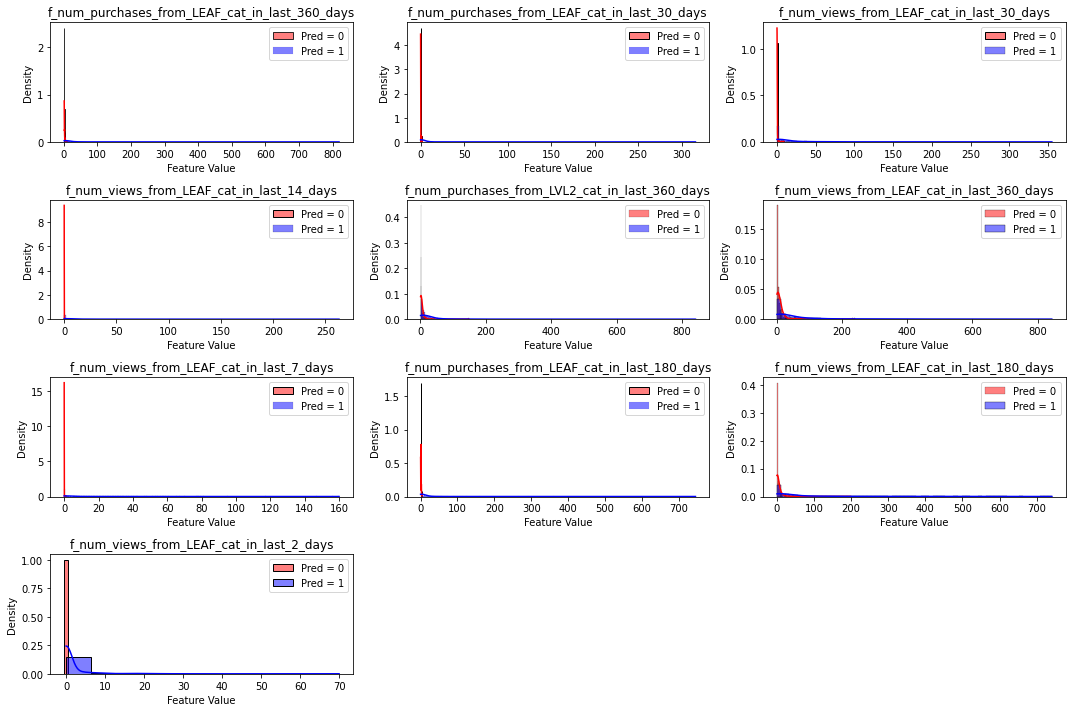

f_num_purchases_from_LEAF_cat_in_last_360_days: t-statistic = -4.7165, p-value = 0.0000
f_num_purchases_from_LEAF_cat_in_last_30_days: t-statistic = -2.8757, p-value = 0.0041
f_num_views_from_LEAF_cat_in_last_30_days: t-statistic = -8.0991, p-value = 0.0000
f_num_views_from_LEAF_cat_in_last_14_days: t-statistic = -7.0854, p-value = 0.0000
f_num_purchases_from_LVL2_cat_in_last_360_days: t-statistic = -6.5158, p-value = 0.0000
f_num_views_from_LEAF_cat_in_last_360_days: t-statistic = -8.5683, p-value = 0.0000
f_num_views_from_LEAF_cat_in_last_7_days: t-statistic = -6.2905, p-value = 0.0000
f_num_purchases_from_LEAF_cat_in_last_180_days: t-statistic = -4.1222, p-value = 0.0000
f_num_views_from_LEAF_cat_in_last_180_days: t-statistic = -8.6536, p-value = 0.0000
f_num_views_from_LEAF_cat_in_last_2_days: t-statistic = -4.9903, p-value = 0.0000


In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Filter for label == 1
label_1_df = eval_df[eval_df['label'] == 1]

# Separate into pred == 0 and pred == 1
pred_0_df = label_1_df[label_1_df['preds'] == 0]
pred_1_df = label_1_df[label_1_df['preds'] == 1]

# Initialize dictionaries to store summary statistics
summary_stats = {}

# Calculate summary statistics for each feature
for feature in features_to_analyze:
    pred_0_mean = pred_0_df[feature].mean()
    pred_0_std = pred_0_df[feature].std()
    pred_1_mean = pred_1_df[feature].mean()
    pred_1_std = pred_1_df[feature].std()
    
    summary_stats[feature] = {
        'Pred = 0 Mean': pred_0_mean,
        'Pred = 0 Std': pred_0_std,
        'Pred = 1 Mean': pred_1_mean,
        'Pred = 1 Std': pred_1_std
    }

# Create a DataFrame from the summary statistics
summary_df = pd.DataFrame(summary_stats).T

# Calculate differences
summary_df['Difference (Mean)'] = summary_df['Pred = 1 Mean'] - summary_df['Pred = 0 Mean']

# Print summary statistics
print(summary_df)

# Visualization
plt.figure(figsize=(15, 10))

for i, feature in enumerate(features_to_analyze):
    plt.subplot(4, 3, i + 1)
    sns.histplot(pred_0_df[feature], color='red', label='Pred = 0', kde=True, stat='density')
    sns.histplot(pred_1_df[feature], color='blue', label='Pred = 1', kde=True, stat='density')
    plt.title(feature)
    plt.xlabel('Feature Value')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

# Optionally perform statistical tests
for feature in features_to_analyze:
    stat, p_value = stats.ttest_ind(pred_0_df[feature].dropna(), pred_1_df[feature].dropna())
    print(f"{feature}: t-statistic = {stat:.4f}, p-value = {p_value:.4f}")


### View to purchase ratio:

In [169]:
import pandas as pd

# Sample DataFrame eval_df initialization (use your actual DataFrame)
# eval_df = pd.DataFrame({
#     'preds': [0, 1, 0, 1, 0],  # Example predictions
#     'label': [1, 1, 1, 1, 1],  # All labels set to 1 for this example
#     'f_num_purchases_from_LEAF_cat_in_last_360_days': [1, 14, 2, 20, 5],
#     'f_num_purchases_from_LEAF_cat_in_last_30_days': [0, 3, 1, 10, 2],
#     'f_num_views_from_LEAF_cat_in_last_30_days': [0, 18, 1, 15, 0],
#     'f_num_views_from_LEAF_cat_in_last_360_days': [0, 66, 3, 20, 8],
#     'LEAF_CATEG_ID': [259104, 28162, 126396, 139973, 19264],
#     'BUYER_ID': [2326, 413827, 2939231, 14754203, 21528843]
# })

# Filter for label == 1 and pred == 0
group_0 = eval_df[(eval_df['label'] == 1) & (eval_df['preds'] == 0)]

# Filter for label == 1 and pred == 1
group_1 = eval_df[(eval_df['label'] == 1) & (eval_df['preds'] == 1)]

# Define the new features to analyze
def calculate_ratios(group):
    # Calculate Recent vs. Long-Term Purchase Ratio
    group['recent_purchase_ratio'] = group['f_num_purchases_from_LEAF_cat_in_last_30_days'] / (
        group['f_num_purchases_from_LEAF_cat_in_last_360_days'].replace(0, -1)
    )
    
    group['recent_view_ratio'] = group['f_num_views_from_LEAF_cat_in_last_30_days'] / (
        group['f_num_views_from_LEAF_cat_in_last_360_days'].replace(0, -1)
    )
    
    # Calculate View-to-Purchase Ratio
    group['view_to_purchase_ratio'] = (
        group['f_num_views_from_LEAF_cat_in_last_30_days'].replace(0, -1) /
        group['f_num_purchases_from_LEAF_cat_in_last_30_days'].replace(0, -1)
    )
    
    return group

# Calculate ratios for each group
group_0 = calculate_ratios(group_0)
group_1 = calculate_ratios(group_1)

# Prepare the results
result_0 = {
    'Mean Recent Purchase Ratio': group_0['recent_purchase_ratio'].mean(),
    'Std Recent Purchase Ratio': group_0['recent_purchase_ratio'].std(),
    'Mean Recent View Ratio': group_0['recent_view_ratio'].mean(),
    'Std Recent View Ratio': group_0['recent_view_ratio'].std(),
    'Mean View-to-Purchase Ratio': group_0['view_to_purchase_ratio'].mean(),
    'Std View-to-Purchase Ratio': group_0['view_to_purchase_ratio'].std(),
}

result_1 = {
    'Mean Recent Purchase Ratio': group_1['recent_purchase_ratio'].mean(),
    'Std Recent Purchase Ratio': group_1['recent_purchase_ratio'].std(),
    'Mean Recent View Ratio': group_1['recent_view_ratio'].mean(),
    'Std Recent View Ratio': group_1['recent_view_ratio'].std(),
    'Mean View-to-Purchase Ratio': group_1['view_to_purchase_ratio'].mean(),
    'Std View-to-Purchase Ratio': group_1['view_to_purchase_ratio'].std(),
}

# Combine results into a DataFrame for better visualization
results_df = pd.DataFrame({
    'Metrics': [
        'Recent Purchase Ratio', 
        'Recent View Ratio', 
        'View-to-Purchase Ratio'
    ],
    'Pred = 0 Mean': [
        result_0['Mean Recent Purchase Ratio'], 
        result_0['Mean Recent View Ratio'], 
        result_0['Mean View-to-Purchase Ratio']
    ],
    'Pred = 0 Std': [
        result_0['Std Recent Purchase Ratio'], 
        result_0['Std Recent View Ratio'], 
        result_0['Std View-to-Purchase Ratio']
    ],
    'Pred = 1 Mean': [
        result_1['Mean Recent Purchase Ratio'], 
        result_1['Mean Recent View Ratio'], 
        result_1['Mean View-to-Purchase Ratio']
    ],
    'Pred = 1 Std': [
        result_1['Std Recent Purchase Ratio'], 
        result_1['Std Recent View Ratio'], 
        result_1['Std View-to-Purchase Ratio']
    ],
})

# Round all numeric columns to 2 decimal places
results_df = results_df.round(2)

# Display the result DataFrame
print("Feature Values for eval_df where label == 1, pred == 0 and pred == 1:")
results_df


Feature Values for eval_df where label == 1, pred == 0 and pred == 1:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,Metrics,Pred = 0 Mean,Pred = 0 Std,Pred = 1 Mean,Pred = 1 Std
0,Recent Purchase Ratio,0.05,0.20,0.21,0.33
1,Recent View Ratio,0.03,0.17,0.28,0.37
2,View-to-Purchase Ratio,1.06,0.84,4.32,29.60


In [170]:
import pandas as pd

# Sample DataFrame eval_df initialization (use your actual DataFrame)
# eval_df = pd.DataFrame({
#     'preds': [0, 1, 0, 1, 0],  # Example predictions
#     'label': [1, 1, 1, 1, 1],  # All labels set to 1 for this example
#     'f_num_purchases_from_LEAF_cat_in_last_360_days': [1, 14, 2, 20, 5],
#     'f_num_purchases_from_LEAF_cat_in_last_30_days': [0, 3, 1, 10, 2],
#     'f_num_views_from_LEAF_cat_in_last_30_days': [0, 18, 1, 15, 0],
#     'f_num_views_from_LEAF_cat_in_last_360_days': [0, 66, 3, 20, 8],
#     'LEAF_CATEG_ID': [259104, 28162, 126396, 139973, 19264],
#     'BUYER_ID': [2326, 413827, 2939231, 14754203, 21528843]
# })

# Filter for label == 1 and pred == 0
group_0 = eval_df[(eval_df['label'] == 0) & (eval_df['preds'] == 0)]

# Filter for label == 1 and pred == 1
group_1 = eval_df[(eval_df['label'] == 0) & (eval_df['preds'] == 1)]

# Define the new features to analyze
def calculate_ratios(group):
    # Calculate Recent vs. Long-Term Purchase Ratio
    group['recent_purchase_ratio'] = group['f_num_purchases_from_LEAF_cat_in_last_30_days'] / (
        group['f_num_purchases_from_LEAF_cat_in_last_360_days'].replace(0, -1)
    )
    
    group['recent_view_ratio'] = group['f_num_views_from_LEAF_cat_in_last_30_days'] / (
        group['f_num_views_from_LEAF_cat_in_last_360_days'].replace(0, -1)
    )
    
    # Calculate View-to-Purchase Ratio
    group['view_to_purchase_ratio'] = (
        group['f_num_views_from_LEAF_cat_in_last_30_days'].replace(0, -1) /
        group['f_num_purchases_from_LEAF_cat_in_last_30_days'].replace(0, -1)
    )
    
    return group

# Calculate ratios for each group
group_0 = calculate_ratios(group_0)
group_1 = calculate_ratios(group_1)

# Prepare the results
result_0 = {
    'Mean Recent Purchase Ratio': group_0['recent_purchase_ratio'].mean(),
    'Std Recent Purchase Ratio': group_0['recent_purchase_ratio'].std(),
    'Mean Recent View Ratio': group_0['recent_view_ratio'].mean(),
    'Std Recent View Ratio': group_0['recent_view_ratio'].std(),
    'Mean View-to-Purchase Ratio': group_0['view_to_purchase_ratio'].mean(),
    'Std View-to-Purchase Ratio': group_0['view_to_purchase_ratio'].std(),
}

result_1 = {
    'Mean Recent Purchase Ratio': group_1['recent_purchase_ratio'].mean(),
    'Std Recent Purchase Ratio': group_1['recent_purchase_ratio'].std(),
    'Mean Recent View Ratio': group_1['recent_view_ratio'].mean(),
    'Std Recent View Ratio': group_1['recent_view_ratio'].std(),
    'Mean View-to-Purchase Ratio': group_1['view_to_purchase_ratio'].mean(),
    'Std View-to-Purchase Ratio': group_1['view_to_purchase_ratio'].std(),
}

# Combine results into a DataFrame for better visualization
results_df = pd.DataFrame({
    'Metrics': [
        'Recent Purchase Ratio', 
        'Recent View Ratio', 
        'View-to-Purchase Ratio'
    ],
    'Pred = 0 Mean': [
        result_0['Mean Recent Purchase Ratio'], 
        result_0['Mean Recent View Ratio'], 
        result_0['Mean View-to-Purchase Ratio']
    ],
    'Pred = 0 Std': [
        result_0['Std Recent Purchase Ratio'], 
        result_0['Std Recent View Ratio'], 
        result_0['Std View-to-Purchase Ratio']
    ],
    'Pred = 1 Mean': [
        result_1['Mean Recent Purchase Ratio'], 
        result_1['Mean Recent View Ratio'], 
        result_1['Mean View-to-Purchase Ratio']
    ],
    'Pred = 1 Std': [
        result_1['Std Recent Purchase Ratio'], 
        result_1['Std Recent View Ratio'], 
        result_1['Std View-to-Purchase Ratio']
    ],
})

# Round all numeric columns to 2 decimal places
results_df = results_df.round(2)

# Display the result DataFrame
print("Feature Values for eval_df where label == 0, pred == 0 and pred == 1:")
results_df


Feature Values for eval_df where label == 0, pred == 0 and pred == 1:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,Metrics,Pred = 0 Mean,Pred = 0 Std,Pred = 1 Mean,Pred = 1 Std
0,Recent Purchase Ratio,0.04,0.20,0.23,0.40
1,Recent View Ratio,0.04,0.18,0.25,0.38
2,View-to-Purchase Ratio,1.07,0.75,1.35,20.57


In [177]:
import pandas as pd

# Sample DataFrame eval_df initialization (use your actual DataFrame)
# eval_df = pd.DataFrame({
#     'preds': [0, 1, 0, 1, 0],  # Example predictions
#     'label': [1, 1, 1, 1, 1],  # All labels set to 1 for this example
#     'f_num_purchases_from_LEAF_cat_in_last_360_days': [1, 14, 2, 20, 5],
#     'f_num_purchases_from_LEAF_cat_in_last_30_days': [0, 3, 1, 10, 2],
#     'f_num_views_from_LEAF_cat_in_last_30_days': [0, 18, 1, 15, 0],
#     'f_num_views_from_LEAF_cat_in_last_360_days': [0, 66, 3, 20, 8],
#     'f_num_purchases_from_LEAF_cat_in_last_180_days': [0, 10, 0, 5, 1],  # New feature
#     'f_num_views_from_LEAF_cat_in_last_180_days': [0, 15, 1, 8, 0],      # New feature
#     'LEAF_CATEG_ID': [259104, 28162, 126396, 139973, 19264],
#     'BUYER_ID': [2326, 413827, 2939231, 14754203, 21528843]
# })

# Filter for label == 1 and pred == 0
group_0 = eval_df[(eval_df['label'] == 1) & (eval_df['preds'] == 0)]

# Filter for label == 1 and pred == 1
group_1 = eval_df[(eval_df['label'] == 1) & (eval_df['preds'] == 1)]

# Define the new features to analyze
def calculate_ratios(group):
    # Calculate Recent vs. Long-Term Purchase Ratio
    group['recent_purchase_ratio'] = group['f_num_purchases_from_LEAF_cat_in_last_30_days'] / (
        group['f_num_purchases_from_LEAF_cat_in_last_360_days'].replace(0, -1)
    )
    
    group['recent_view_ratio'] = group['f_num_views_from_LEAF_cat_in_last_30_days'] / (
        group['f_num_views_from_LEAF_cat_in_last_360_days'].replace(0, -1)
    )
    
    # Calculate View-to-Purchase Ratio
    group['view_to_purchase_ratio'] = (
        group['f_num_views_from_LEAF_cat_in_last_30_days'].replace(0, -1) /
        group['f_num_purchases_from_LEAF_cat_in_last_30_days'].replace(0, -1)
    )
    
    # Calculate metrics for the last 180 days
    group['recent_purchase_ratio_180'] = group['f_num_purchases_from_LEAF_cat_in_last_180_days'] / (
        group['f_num_purchases_from_LEAF_cat_in_last_360_days'].replace(0, -1)
    )
    
    group['recent_view_ratio_180'] = group['f_num_views_from_LEAF_cat_in_last_180_days'] / (
        group['f_num_views_from_LEAF_cat_in_last_360_days'].replace(0, -1)
    )
    
    group['view_to_purchase_ratio_180'] = (
        group['f_num_views_from_LEAF_cat_in_last_180_days'].replace(0, -1) /
        group['f_num_purchases_from_LEAF_cat_in_last_180_days'].replace(0, -1)
    )
    
    return group

# Calculate ratios for each group
group_0 = calculate_ratios(group_0)
group_1 = calculate_ratios(group_1)

# Prepare the results
result_0 = {
    'Mean Recent Purchase Ratio': group_0['recent_purchase_ratio'].mean(),
    'Std Recent Purchase Ratio': group_0['recent_purchase_ratio'].std(),
    'Mean Recent View Ratio': group_0['recent_view_ratio'].mean(),
    'Std Recent View Ratio': group_0['recent_view_ratio'].std(),
    'Mean View-to-Purchase Ratio': group_0['view_to_purchase_ratio'].mean(),
    'Std View-to-Purchase Ratio': group_0['view_to_purchase_ratio'].std(),
    'Mean Recent Purchase Ratio (180 days)': group_0['recent_purchase_ratio_180'].mean(),
    'Std Recent Purchase Ratio (180 days)': group_0['recent_purchase_ratio_180'].std(),
    'Mean Recent View Ratio (180 days)': group_0['recent_view_ratio_180'].mean(),
    'Std Recent View Ratio (180 days)': group_0['recent_view_ratio_180'].std(),
    'Mean View-to-Purchase Ratio (180 days)': group_0['view_to_purchase_ratio_180'].mean(),
    'Std View-to-Purchase Ratio (180 days)': group_0['view_to_purchase_ratio_180'].std(),
}

result_1 = {
    'Mean Recent Purchase Ratio': group_1['recent_purchase_ratio'].mean(),
    'Std Recent Purchase Ratio': group_1['recent_purchase_ratio'].std(),
    'Mean Recent View Ratio': group_1['recent_view_ratio'].mean(),
    'Std Recent View Ratio': group_1['recent_view_ratio'].std(),
    'Mean View-to-Purchase Ratio': group_1['view_to_purchase_ratio'].mean(),
    'Std View-to-Purchase Ratio': group_1['view_to_purchase_ratio'].std(),
    'Mean Recent Purchase Ratio (180 days)': group_1['recent_purchase_ratio_180'].mean(),
    'Std Recent Purchase Ratio (180 days)': group_1['recent_purchase_ratio_180'].std(),
    'Mean Recent View Ratio (180 days)': group_1['recent_view_ratio_180'].mean(),
    'Std Recent View Ratio (180 days)': group_1['recent_view_ratio_180'].std(),
    'Mean View-to-Purchase Ratio (180 days)': group_1['view_to_purchase_ratio_180'].mean(),
    'Std View-to-Purchase Ratio (180 days)': group_1['view_to_purchase_ratio_180'].std(),
}

# Combine results into a DataFrame for better visualization
results_df = pd.DataFrame({
    'Metrics': [
        'Recent Purchase Ratio', 
        'Recent View Ratio', 
        'View-to-Purchase Ratio',
        'Recent Purchase Ratio (180 days)',
        'Recent View Ratio (180 days)',
        'View-to-Purchase Ratio (180 days)'
    ],
    'Pred = 0 Mean': [
        result_0['Mean Recent Purchase Ratio'], 
        result_0['Mean Recent View Ratio'], 
        result_0['Mean View-to-Purchase Ratio'],
        result_0['Mean Recent Purchase Ratio (180 days)'],
        result_0['Mean Recent View Ratio (180 days)'],
        result_0['Mean View-to-Purchase Ratio (180 days)']
    ],
    'Pred = 0 Std': [
        result_0['Std Recent Purchase Ratio'], 
        result_0['Std Recent View Ratio'], 
        result_0['Std View-to-Purchase Ratio'],
        result_0['Std Recent Purchase Ratio (180 days)'],
        result_0['Std Recent View Ratio (180 days)'],
        result_0['Std View-to-Purchase Ratio (180 days)']
    ],
    'Pred = 1 Mean': [
        result_1['Mean Recent Purchase Ratio'], 
        result_1['Mean Recent View Ratio'], 
        result_1['Mean View-to-Purchase Ratio'],
        result_1['Mean Recent Purchase Ratio (180 days)'],
        result_1['Mean Recent View Ratio (180 days)'],
        result_1['Mean View-to-Purchase Ratio (180 days)']
    ],
    'Pred = 1 Std': [
        result_1['Std Recent Purchase Ratio'], 
        result_1['Std Recent View Ratio'], 
        result_1['Std View-to-Purchase Ratio'],
        result_1['Std Recent Purchase Ratio (180 days)'],
        result_1['Std Recent View Ratio (180 days)'],
        result_1['Std View-to-Purchase Ratio (180 days)']
    ],
})

# Round all numeric columns to 2 decimal places
results_df = results_df.round(2)

# Display the result DataFrame
print("Feature Values for eval_df where label == 1, pred == 0 and pred == 1:")
results_df


Feature Values for eval_df where label == 1, pred == 0 and pred == 1:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,Metrics,Pred = 0 Mean,Pred = 0 Std,Pred = 1 Mean,Pred = 1 Std
0,Recent Purchase Ratio,0.05,0.20,0.21,0.33
1,Recent View Ratio,0.03,0.17,0.28,0.37
2,View-to-Purchase Ratio,1.06,0.84,4.32,29.60
3,Recent Purchase Ratio (180 days),0.58,0.47,0.69,0.35
4,Recent View Ratio (180 days),0.41,0.46,0.60,0.44
5,View-to-Purchase Ratio (180 days),3.16,12.13,12.79,49.93


In [178]:
import pandas as pd

# Sample DataFrame eval_df initialization (use your actual DataFrame)
# eval_df = pd.DataFrame({
#     'preds': [0, 1, 0, 1, 0],  # Example predictions
#     'label': [1, 1, 1, 1, 1],  # All labels set to 1 for this example
#     'f_num_purchases_from_LEAF_cat_in_last_360_days': [1, 14, 2, 20, 5],
#     'f_num_purchases_from_LEAF_cat_in_last_30_days': [0, 3, 1, 10, 2],
#     'f_num_views_from_LEAF_cat_in_last_30_days': [0, 18, 1, 15, 0],
#     'f_num_views_from_LEAF_cat_in_last_360_days': [0, 66, 3, 20, 8],
#     'f_num_purchases_from_LEAF_cat_in_last_180_days': [0, 10, 0, 5, 1],  # New feature
#     'f_num_views_from_LEAF_cat_in_last_180_days': [0, 15, 1, 8, 0],      # New feature
#     'LEAF_CATEG_ID': [259104, 28162, 126396, 139973, 19264],
#     'BUYER_ID': [2326, 413827, 2939231, 14754203, 21528843]
# })

# Filter for label == 1 and pred == 0
group_0 = eval_df[(eval_df['label'] ==0) & (eval_df['preds'] == 0)]

# Filter for label == 1 and pred == 1
group_1 = eval_df[(eval_df['label'] == 0) & (eval_df['preds'] == 1)]

# Define the new features to analyze
def calculate_ratios(group):
    # Calculate Recent vs. Long-Term Purchase Ratio
    group['recent_purchase_ratio'] = group['f_num_purchases_from_LEAF_cat_in_last_30_days'] / (
        group['f_num_purchases_from_LEAF_cat_in_last_360_days'].replace(0, -1)
    )
    
    group['recent_view_ratio'] = group['f_num_views_from_LEAF_cat_in_last_30_days'] / (
        group['f_num_views_from_LEAF_cat_in_last_360_days'].replace(0, -1)
    )
    
    # Calculate View-to-Purchase Ratio
    group['view_to_purchase_ratio'] = (
        group['f_num_views_from_LEAF_cat_in_last_30_days'].replace(0, -1) /
        group['f_num_purchases_from_LEAF_cat_in_last_30_days'].replace(0, -1)
    )
    
    # Calculate metrics for the last 180 days
    group['recent_purchase_ratio_180'] = group['f_num_purchases_from_LEAF_cat_in_last_180_days'] / (
        group['f_num_purchases_from_LEAF_cat_in_last_360_days'].replace(0, -1)
    )
    
    group['recent_view_ratio_180'] = group['f_num_views_from_LEAF_cat_in_last_180_days'] / (
        group['f_num_views_from_LEAF_cat_in_last_360_days'].replace(0, -1)
    )
    
    group['view_to_purchase_ratio_180'] = (
        group['f_num_views_from_LEAF_cat_in_last_180_days'].replace(0, -1) /
        group['f_num_purchases_from_LEAF_cat_in_last_180_days'].replace(0, -1)
    )
    
    return group

# Calculate ratios for each group
group_0 = calculate_ratios(group_0)
group_1 = calculate_ratios(group_1)

# Prepare the results
result_0 = {
    'Mean Recent Purchase Ratio': group_0['recent_purchase_ratio'].mean(),
    'Std Recent Purchase Ratio': group_0['recent_purchase_ratio'].std(),
    'Mean Recent View Ratio': group_0['recent_view_ratio'].mean(),
    'Std Recent View Ratio': group_0['recent_view_ratio'].std(),
    'Mean View-to-Purchase Ratio': group_0['view_to_purchase_ratio'].mean(),
    'Std View-to-Purchase Ratio': group_0['view_to_purchase_ratio'].std(),
    'Mean Recent Purchase Ratio (180 days)': group_0['recent_purchase_ratio_180'].mean(),
    'Std Recent Purchase Ratio (180 days)': group_0['recent_purchase_ratio_180'].std(),
    'Mean Recent View Ratio (180 days)': group_0['recent_view_ratio_180'].mean(),
    'Std Recent View Ratio (180 days)': group_0['recent_view_ratio_180'].std(),
    'Mean View-to-Purchase Ratio (180 days)': group_0['view_to_purchase_ratio_180'].mean(),
    'Std View-to-Purchase Ratio (180 days)': group_0['view_to_purchase_ratio_180'].std(),
}

result_1 = {
    'Mean Recent Purchase Ratio': group_1['recent_purchase_ratio'].mean(),
    'Std Recent Purchase Ratio': group_1['recent_purchase_ratio'].std(),
    'Mean Recent View Ratio': group_1['recent_view_ratio'].mean(),
    'Std Recent View Ratio': group_1['recent_view_ratio'].std(),
    'Mean View-to-Purchase Ratio': group_1['view_to_purchase_ratio'].mean(),
    'Std View-to-Purchase Ratio': group_1['view_to_purchase_ratio'].std(),
    'Mean Recent Purchase Ratio (180 days)': group_1['recent_purchase_ratio_180'].mean(),
    'Std Recent Purchase Ratio (180 days)': group_1['recent_purchase_ratio_180'].std(),
    'Mean Recent View Ratio (180 days)': group_1['recent_view_ratio_180'].mean(),
    'Std Recent View Ratio (180 days)': group_1['recent_view_ratio_180'].std(),
    'Mean View-to-Purchase Ratio (180 days)': group_1['view_to_purchase_ratio_180'].mean(),
    'Std View-to-Purchase Ratio (180 days)': group_1['view_to_purchase_ratio_180'].std(),
}

# Combine results into a DataFrame for better visualization
results_df = pd.DataFrame({
    'Metrics': [
        'Recent Purchase Ratio', 
        'Recent View Ratio', 
        'View-to-Purchase Ratio',
        'Recent Purchase Ratio (180 days)',
        'Recent View Ratio (180 days)',
        'View-to-Purchase Ratio (180 days)'
    ],
    'Pred = 0 Mean': [
        result_0['Mean Recent Purchase Ratio'], 
        result_0['Mean Recent View Ratio'], 
        result_0['Mean View-to-Purchase Ratio'],
        result_0['Mean Recent Purchase Ratio (180 days)'],
        result_0['Mean Recent View Ratio (180 days)'],
        result_0['Mean View-to-Purchase Ratio (180 days)']
    ],
    'Pred = 0 Std': [
        result_0['Std Recent Purchase Ratio'], 
        result_0['Std Recent View Ratio'], 
        result_0['Std View-to-Purchase Ratio'],
        result_0['Std Recent Purchase Ratio (180 days)'],
        result_0['Std Recent View Ratio (180 days)'],
        result_0['Std View-to-Purchase Ratio (180 days)']
    ],
    'Pred = 1 Mean': [
        result_1['Mean Recent Purchase Ratio'], 
        result_1['Mean Recent View Ratio'], 
        result_1['Mean View-to-Purchase Ratio'],
        result_1['Mean Recent Purchase Ratio (180 days)'],
        result_1['Mean Recent View Ratio (180 days)'],
        result_1['Mean View-to-Purchase Ratio (180 days)']
    ],
    'Pred = 1 Std': [
        result_1['Std Recent Purchase Ratio'], 
        result_1['Std Recent View Ratio'], 
        result_1['Std View-to-Purchase Ratio'],
        result_1['Std Recent Purchase Ratio (180 days)'],
        result_1['Std Recent View Ratio (180 days)'],
        result_1['Std View-to-Purchase Ratio (180 days)']
    ],
})

# Round all numeric columns to 2 decimal places
results_df = results_df.round(2)

# Display the result DataFrame
print("Feature Values for eval_df where label == 1, pred == 0 and pred == 1:")
results_df


Feature Values for eval_df where label == 1, pred == 0 and pred == 1:


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

,Metrics,Pred = 0 Mean,Pred = 0 Std,Pred = 1 Mean,Pred = 1 Std
0,Recent Purchase Ratio,0.04,0.20,0.23,0.40
1,Recent View Ratio,0.04,0.18,0.25,0.38
2,View-to-Purchase Ratio,1.07,0.75,1.35,20.57
3,Recent Purchase Ratio (180 days),0.57,0.49,0.71,0.41
4,Recent View Ratio (180 days),0.42,0.48,0.62,0.45
5,View-to-Purchase Ratio (180 days),3.21,7.95,14.22,45.78


In [229]:
# Define the features to analyze
features_to_analyze = [
    'f_num_purchases_from_LEAF_cat_in_last_360_days',
    'f_num_purchases_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_14_days',
    'f_num_purchases_from_LVL2_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_7_days',
    'f_time_since_last_view_from_LVL2_cat',
    'f_time_since_last_view_from_LEAF_cat',
    'f_num_purchases_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_2_days'
]

# Initialize a dictionary to store the results
percentages = {}

# Calculate statistics for each feature
for feature in features_to_analyze:
    # Basic counts for -1, 0, and >0 values
    total_count = eval_df[feature].count()  # Total count of non-null values
    count_neg1 = (eval_df[feature] == -1).sum()  # Count of -1
    count_0 = (eval_df[feature] == 0).sum()      # Count of 0
    count_gt0 = (eval_df[feature] > 0).sum()     # Count of >0

    # Calculate percentages and statistics
    percentages[feature] = {
        'Percent == -1': (count_neg1 / total_count) * 100 if total_count > 0 else 0,
        'Percent == 0': (count_0 / total_count) * 100 if total_count > 0 else 0,
        'Percent > 0': (count_gt0 / total_count) * 100 if total_count > 0 else 0,
        'Mean': eval_df[feature].mean(),
        'Std': eval_df[feature].std(),

        'p05': eval_df[feature].quantile(0.05),
        'p10': eval_df[feature].quantile(0.10),
        'p25': eval_df[feature].quantile(0.25),
        'p50': eval_df[feature].quantile(0.50),
        'p75': eval_df[feature].quantile(0.75),
        'p90': eval_df[feature].quantile(0.90),
        'p95': eval_df[feature].quantile(0.95)
    }

# Create a DataFrame for better visualization
percentages_df = pd.DataFrame(percentages).T.reset_index()
percentages_df.columns = [
    'Feature', 'Percent == -1', 'Percent == 0', 'Percent > 0', 
    'Mean', 'Std', 'p05', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95'
]
percentages_df = percentages_df.round(2)

# Display the percentages DataFrame
percentages_df


,Feature,Percent == -1,Percent == 0,Percent > 0,Mean,Std,p05,p10,p25,p50,p75,p90,p95
0,f_num_purchases_from_LEAF_cat_in_last_360_days,0.00,0.00,100.00,2.30,11.92,1.0,1.0,1.0,1.0,2.0,3.0,5.0
1,f_num_purchases_from_LEAF_cat_in_last_30_days,0.00,87.66,12.34,0.27,3.73,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,f_num_views_from_LEAF_cat_in_last_30_days,0.00,82.31,17.69,2.81,15.12,0.0,0.0,0.0,0.0,0.0,4.0,12.0
3,f_num_views_from_LEAF_cat_in_last_14_days,0.00,88.82,11.18,1.36,8.66,0.0,0.0,0.0,0.0,0.0,1.0,5.0
4,f_num_purchases_from_LVL2_cat_in_last_360_days,0.00,0.00,100.00,6.64,25.88,1.0,1.0,1.0,1.0,4.0,11.0,24.0
5,f_num_views_from_LEAF_cat_in_last_360_days,0.00,30.08,69.92,19.09,57.41,0.0,0.0,0.0,4.0,13.0,41.0,84.0
6,f_num_views_from_LEAF_cat_in_last_7_days,0.00,92.88,7.12,0.65,5.16,0.0,0.0,0.0,0.0,0.0,0.0,2.0
7,f_time_since_last_view_from_LVL2_cat,24.04,0.00,75.96,63.21,80.84,-1.0,-1.0,1.0,23.0,107.0,197.0,245.0
8,f_time_since_last_view_from_LEAF_cat,30.08,0.00,69.92,75.41,88.20,-1.0,-1.0,-1.0,37.0,136.0,222.0,261.0
9,f_num_purchases_from_LEAF_cat_in_last_180_days,0.00,35.06,64.94,1.44,9.41,0.0,0.0,0.0,1.0,1.0,2.0,3.0


### Feature distribution by label:

In [237]:
# Define the features to analyze
features_to_analyze = [
    'f_num_purchases_from_LEAF_cat_in_last_360_days',
    'f_num_purchases_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_14_days',
    'f_num_purchases_from_LVL2_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_7_days',
    'f_time_since_last_view_from_LVL2_cat',
    'f_time_since_last_view_from_LEAF_cat',
    'f_num_purchases_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_2_days'
]

# Initialize a dictionary to store the results
percentages = {}

# Calculate statistics for each feature, ensuring label=1 rows come before label=0 rows
for feature in features_to_analyze:
    for label in [1, 0]:  # Process label=1 before label=0
        # Filter by label
        label_data = eval_df[eval_df['label'] == label][feature]
        total_count = label_data.count()  # Total count of non-null values
        count_neg1 = (label_data == -1).sum()  # Count of -1
        count_0 = (label_data == 0).sum()      # Count of 0
        count_gt0 = (label_data > 0).sum()     # Count of >0
        
        # Calculate percentages and statistics
        percentages[f"{feature}_{label}"] = {
            'Percent == -1': (count_neg1 / total_count) * 100 if total_count > 0 else 0,
            'Percent == 0': (count_0 / total_count) * 100 if total_count > 0 else 0,
            'Percent > 0': (count_gt0 / total_count) * 100 if total_count > 0 else 0,
            'Mean': label_data.mean(),
            'Std': label_data.std(),
            'p05': label_data.quantile(0.05),
            'p10': label_data.quantile(0.10),
            'p25': label_data.quantile(0.25),
            'p50': label_data.quantile(0.50),
            'p75': label_data.quantile(0.75),
            'p90': label_data.quantile(0.90),
            'p95': label_data.quantile(0.95)
        }

# Create a DataFrame for better visualization
percentages_df = pd.DataFrame(percentages).T.reset_index()
percentages_df.columns = [
    'Feature', 'Percent == -1', 'Percent == 0', 'Percent > 0', 
    'Mean', 'Std', 'p05', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95'
]
percentages_df = percentages_df.round(2)

# Display the percentages DataFrame
percentages_df


,Feature,Percent == -1,Percent == 0,Percent > 0,Mean,Std,p05,p10,p25,p50,p75,p90,p95
0,f_num_purchases_from_LEAF_cat_in_last_360_days_1,0.00,0.00,100.00,11.17,43.33,1.0,1.0,1.0,2.0,6.00,17.0,34.55
1,f_num_purchases_from_LEAF_cat_in_last_360_days_0,0.00,0.00,100.00,1.68,3.79,1.0,1.0,1.0,1.0,1.00,3.0,4.00
2,f_num_purchases_from_LEAF_cat_in_last_30_days_1,0.00,64.19,35.81,1.98,14.04,0.0,0.0,0.0,0.0,1.00,3.0,5.00
3,f_num_purchases_from_LEAF_cat_in_last_30_days_0,0.00,89.31,10.69,0.15,0.92,0.0,0.0,0.0,0.0,0.00,1.0,1.00
4,f_num_views_from_LEAF_cat_in_last_30_days_1,0.00,56.82,43.18,13.85,36.38,0.0,0.0,0.0,0.0,9.00,41.0,75.65
5,f_num_views_from_LEAF_cat_in_last_30_days_0,0.00,84.10,15.90,2.03,11.93,0.0,0.0,0.0,0.0,0.00,3.0,9.00
6,f_num_views_from_LEAF_cat_in_last_14_days_1,0.00,65.58,34.42,7.49,22.59,0.0,0.0,0.0,0.0,3.00,21.0,44.10
7,f_num_views_from_LEAF_cat_in_last_14_days_0,0.00,90.45,9.55,0.93,6.44,0.0,0.0,0.0,0.0,0.00,0.0,4.00
8,f_num_purchases_from_LVL2_cat_in_last_360_days_1,0.00,0.00,100.00,25.17,66.99,1.0,1.0,2.0,6.0,18.75,54.0,108.10
9,f_num_purchases_from_LVL2_cat_in_last_360_days_0,0.00,0.00,100.00,5.34,19.39,1.0,1.0,1.0,1.0,3.00,9.0,19.00


### FN VS TN

In [238]:
# Define the features to analyze
features_to_analyze = [
    'f_num_purchases_from_LEAF_cat_in_last_360_days',
    'f_num_purchases_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_14_days',
    'f_num_purchases_from_LVL2_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_7_days',
    'f_time_since_last_view_from_LVL2_cat',
    'f_time_since_last_view_from_LEAF_cat',
    'f_num_purchases_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_2_days'
]

# Initialize a dictionary to store the results
percentages = {}

# Calculate statistics for each feature for FN and TN
for feature in features_to_analyze:
    # False Negatives (FN): label == 1 and preds == 0
    fn_data = eval_df[(eval_df['label'] == 1) & (eval_df['preds'] == 0)][feature]
    fn_total_count = fn_data.count()
    fn_count_neg1 = (fn_data == -1).sum()
    fn_count_0 = (fn_data == 0).sum()
    fn_count_gt0 = (fn_data > 0).sum()

    percentages[f"{feature}_FN"] = {
        'Percent == -1': (fn_count_neg1 / fn_total_count) * 100 if fn_total_count > 0 else 0,
        'Percent == 0': (fn_count_0 / fn_total_count) * 100 if fn_total_count > 0 else 0,
        'Percent > 0': (fn_count_gt0 / fn_total_count) * 100 if fn_total_count > 0 else 0,
        'Mean': fn_data.mean(),
        'Std': fn_data.std(),
        'p05': fn_data.quantile(0.05),
        'p10': fn_data.quantile(0.10),
        'p25': fn_data.quantile(0.25),
        'p50': fn_data.quantile(0.50),
        'p75': fn_data.quantile(0.75),
        'p90': fn_data.quantile(0.90),
        'p95': fn_data.quantile(0.95)
    }
    
    # True Negatives (TN): label == 0 and preds == 0
    tn_data = eval_df[(eval_df['label'] == 0) & (eval_df['preds'] == 0)][feature]
    tn_total_count = tn_data.count()
    tn_count_neg1 = (tn_data == -1).sum()
    tn_count_0 = (tn_data == 0).sum()
    tn_count_gt0 = (tn_data > 0).sum()

    percentages[f"{feature}_TN"] = {
        'Percent == -1': (tn_count_neg1 / tn_total_count) * 100 if tn_total_count > 0 else 0,
        'Percent == 0': (tn_count_0 / tn_total_count) * 100 if tn_total_count > 0 else 0,
        'Percent > 0': (tn_count_gt0 / tn_total_count) * 100 if tn_total_count > 0 else 0,
        'Mean': tn_data.mean(),
        'Std': tn_data.std(),
        'p05': tn_data.quantile(0.05),
        'p10': tn_data.quantile(0.10),
        'p25': tn_data.quantile(0.25),
        'p50': tn_data.quantile(0.50),
        'p75': tn_data.quantile(0.75),
        'p90': tn_data.quantile(0.90),
        'p95': tn_data.quantile(0.95)
    }

# Create a DataFrame for better visualization
percentages_df = pd.DataFrame(percentages).T.reset_index()
percentages_df.columns = [
    'Feature', 'Percent == -1', 'Percent == 0', 'Percent > 0', 
    'Mean', 'Std', 'p05', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95'
]
percentages_df = percentages_df.round(2)

# Display the percentages DataFrame
percentages_df


,Feature,Percent == -1,Percent == 0,Percent > 0,Mean,Std,p05,p10,p25,p50,p75,p90,p95
0,f_num_purchases_from_LEAF_cat_in_last_360_days_FN,0.00,0.00,100.00,1.52,1.01,1.0,1.0,1.0,1.0,2.0,3.0,3.6
1,f_num_purchases_from_LEAF_cat_in_last_360_days_TN,0.00,0.00,100.00,1.21,0.67,1.0,1.0,1.0,1.0,1.0,2.0,2.0
2,f_num_purchases_from_LEAF_cat_in_last_30_days_FN,0.00,94.22,5.78,0.06,0.27,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,f_num_purchases_from_LEAF_cat_in_last_30_days_TN,0.00,95.68,4.32,0.05,0.22,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f_num_views_from_LEAF_cat_in_last_30_days_FN,0.00,95.74,4.26,0.16,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,f_num_views_from_LEAF_cat_in_last_30_days_TN,0.00,96.01,3.99,0.14,0.86,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,f_num_views_from_LEAF_cat_in_last_14_days_FN,0.00,99.09,0.91,0.01,0.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,f_num_views_from_LEAF_cat_in_last_14_days_TN,0.00,98.91,1.09,0.03,0.31,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,f_num_purchases_from_LVL2_cat_in_last_360_days_FN,0.00,0.00,100.00,4.73,11.11,1.0,1.0,1.0,2.0,4.0,8.0,16.6
9,f_num_purchases_from_LVL2_cat_in_last_360_days_TN,0.00,0.00,100.00,2.59,6.45,1.0,1.0,1.0,1.0,2.0,4.8,7.0


#### Diff: 

In [245]:
import pandas as pd

# Define the features to analyze
features_to_analyze = [
    'f_num_purchases_from_LEAF_cat_in_last_360_days',
    'f_num_purchases_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_14_days',
    'f_num_purchases_from_LVL2_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_7_days',
    'f_time_since_last_view_from_LVL2_cat',
    'f_time_since_last_view_from_LEAF_cat',
    'f_num_purchases_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_2_days'
]

# Initialize dictionaries to store results
percentages = {}
differences = {}

# Calculate statistics for each feature for FN and TN
for feature in features_to_analyze:
    # False Negatives (FN): label == 1 and preds == 0
    fn_data = eval_df[(eval_df['label'] == 1) & (eval_df['preds'] == 0)][feature]
    fn_total_count = fn_data.count()
    fn_count_neg1 = (fn_data == -1).sum()
    fn_count_0 = (fn_data == 0).sum()
    fn_count_gt0 = (fn_data > 0).sum()

    percentages[f"{feature}_FN"] = {
        'Percent == -1': (fn_count_neg1 / fn_total_count) * 100 if fn_total_count > 0 else 0,
        'Percent == 0': (fn_count_0 / fn_total_count) * 100 if fn_total_count > 0 else 0,
        'Percent > 0': (fn_count_gt0 / fn_total_count) * 100 if fn_total_count > 0 else 0,
        'Mean': fn_data.mean(),
        'Std': fn_data.std(),
        'p05': fn_data.quantile(0.05),
        'p10': fn_data.quantile(0.10),
        'p25': fn_data.quantile(0.25),
        'p50': fn_data.quantile(0.50),
        'p75': fn_data.quantile(0.75),
        'p90': fn_data.quantile(0.90),
        'p95': fn_data.quantile(0.95)
    }
    
    # True Negatives (TN): label == 0 and preds == 0
    tn_data = eval_df[(eval_df['label'] == 0) & (eval_df['preds'] == 0)][feature]
    tn_total_count = tn_data.count()
    tn_count_neg1 = (tn_data == -1).sum()
    tn_count_0 = (tn_data == 0).sum()
    tn_count_gt0 = (tn_data > 0).sum()

    percentages[f"{feature}_TN"] = {
        'Percent == -1': (tn_count_neg1 / tn_total_count) * 100 if tn_total_count > 0 else 0,
        'Percent == 0': (tn_count_0 / tn_total_count) * 100 if tn_total_count > 0 else 0,
        'Percent > 0': (tn_count_gt0 / tn_total_count) * 100 if tn_total_count > 0 else 0,
        'Mean': tn_data.mean(),
        'Std': tn_data.std(),
        'p05': tn_data.quantile(0.05),
        'p10': tn_data.quantile(0.10),
        'p25': tn_data.quantile(0.25),
        'p50': tn_data.quantile(0.50),
        'p75': tn_data.quantile(0.75),
        'p90': tn_data.quantile(0.90),
        'p95': tn_data.quantile(0.95)
    }

    # Calculate differences FN - TN for each metric
    differences[feature] = {
        'Percent == -1': percentages[f"{feature}_FN"]['Percent == -1'] - percentages[f"{feature}_TN"]['Percent == -1'],
        'Percent == 0': percentages[f"{feature}_FN"]['Percent == 0'] - percentages[f"{feature}_TN"]['Percent == 0'],
        'Percent > 0': percentages[f"{feature}_FN"]['Percent > 0'] - percentages[f"{feature}_TN"]['Percent > 0'],
        'Mean': percentages[f"{feature}_FN"]['Mean'] - percentages[f"{feature}_TN"]['Mean'],
        'Std': percentages[f"{feature}_FN"]['Std'] - percentages[f"{feature}_TN"]['Std'],
        'p05': percentages[f"{feature}_FN"]['p05'] - percentages[f"{feature}_TN"]['p05'],
        'p10': percentages[f"{feature}_FN"]['p10'] - percentages[f"{feature}_TN"]['p10'],
        'p25': percentages[f"{feature}_FN"]['p25'] - percentages[f"{feature}_TN"]['p25'],
        'p50': percentages[f"{feature}_FN"]['p50'] - percentages[f"{feature}_TN"]['p50'],
        'p75': percentages[f"{feature}_FN"]['p75'] - percentages[f"{feature}_TN"]['p75'],
        'p90': percentages[f"{feature}_FN"]['p90'] - percentages[f"{feature}_TN"]['p90'],
        'p95': percentages[f"{feature}_FN"]['p95'] - percentages[f"{feature}_TN"]['p95']
    }

# Create DataFrames for better visualization
percentages_df = pd.DataFrame(percentages).T.reset_index()
percentages_df.columns = [
    'Feature', 'Percent == -1', 'Percent == 0', 'Percent > 0', 
    'Mean', 'Std', 'p05', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95'
]
percentages_df = percentages_df.round(2)

# Create a DataFrame for the differences
differences_df = pd.DataFrame(differences).T.reset_index()
differences_df.columns = [
    'Feature', 'Diff Percent == -1', 'Diff Percent == 0', 'Diff Percent > 0',
    'Diff Mean', 'Diff Std', 'Diff p05', 'Diff p10', 'Diff p25', 
    'Diff p50', 'Diff p75', 'Diff p90', 'Diff p95'
]
differences_df = differences_df.round(2)

# Display the DataFrames

print("\nDifferences FN - TN DataFrame:")
differences_df



Differences FN - TN DataFrame:


,Feature,Diff Percent == -1,Diff Percent == 0,Diff Percent > 0,Diff Mean,Diff Std,Diff p05,Diff p10,Diff p25,Diff p50,Diff p75,Diff p90,Diff p95
0,f_num_purchases_from_LEAF_cat_in_last_360_days,0.00,0.00,0.00,0.31,0.34,0.0,0.0,0.0,0.0,1.0,1.0,1.6
1,f_num_purchases_from_LEAF_cat_in_last_30_days,0.00,-1.46,1.46,0.02,0.05,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,f_num_views_from_LEAF_cat_in_last_30_days,0.00,-0.26,0.26,0.02,0.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f_num_views_from_LEAF_cat_in_last_14_days,0.00,0.18,-0.18,-0.02,-0.18,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f_num_purchases_from_LVL2_cat_in_last_360_days,0.00,0.00,0.00,2.14,4.66,0.0,0.0,0.0,1.0,2.0,3.2,9.6
5,f_num_views_from_LEAF_cat_in_last_360_days,0.00,1.45,-1.45,1.23,6.17,0.0,0.0,0.0,0.0,1.0,-1.0,0.6
6,f_num_views_from_LEAF_cat_in_last_7_days,0.00,-0.43,0.43,0.00,-0.02,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,f_time_since_last_view_from_LVL2_cat,-4.83,0.00,4.83,-20.29,-14.56,0.0,0.0,2.0,-20.0,-40.0,-53.0,-41.8
8,f_time_since_last_view_from_LEAF_cat,1.45,0.00,-1.45,-11.25,-6.14,0.0,0.0,0.0,-13.0,-17.0,-19.8,-3.8
9,f_num_purchases_from_LEAF_cat_in_last_180_days,0.00,-5.19,5.19,0.16,0.12,0.0,0.0,0.0,0.0,0.0,1.0,0.0


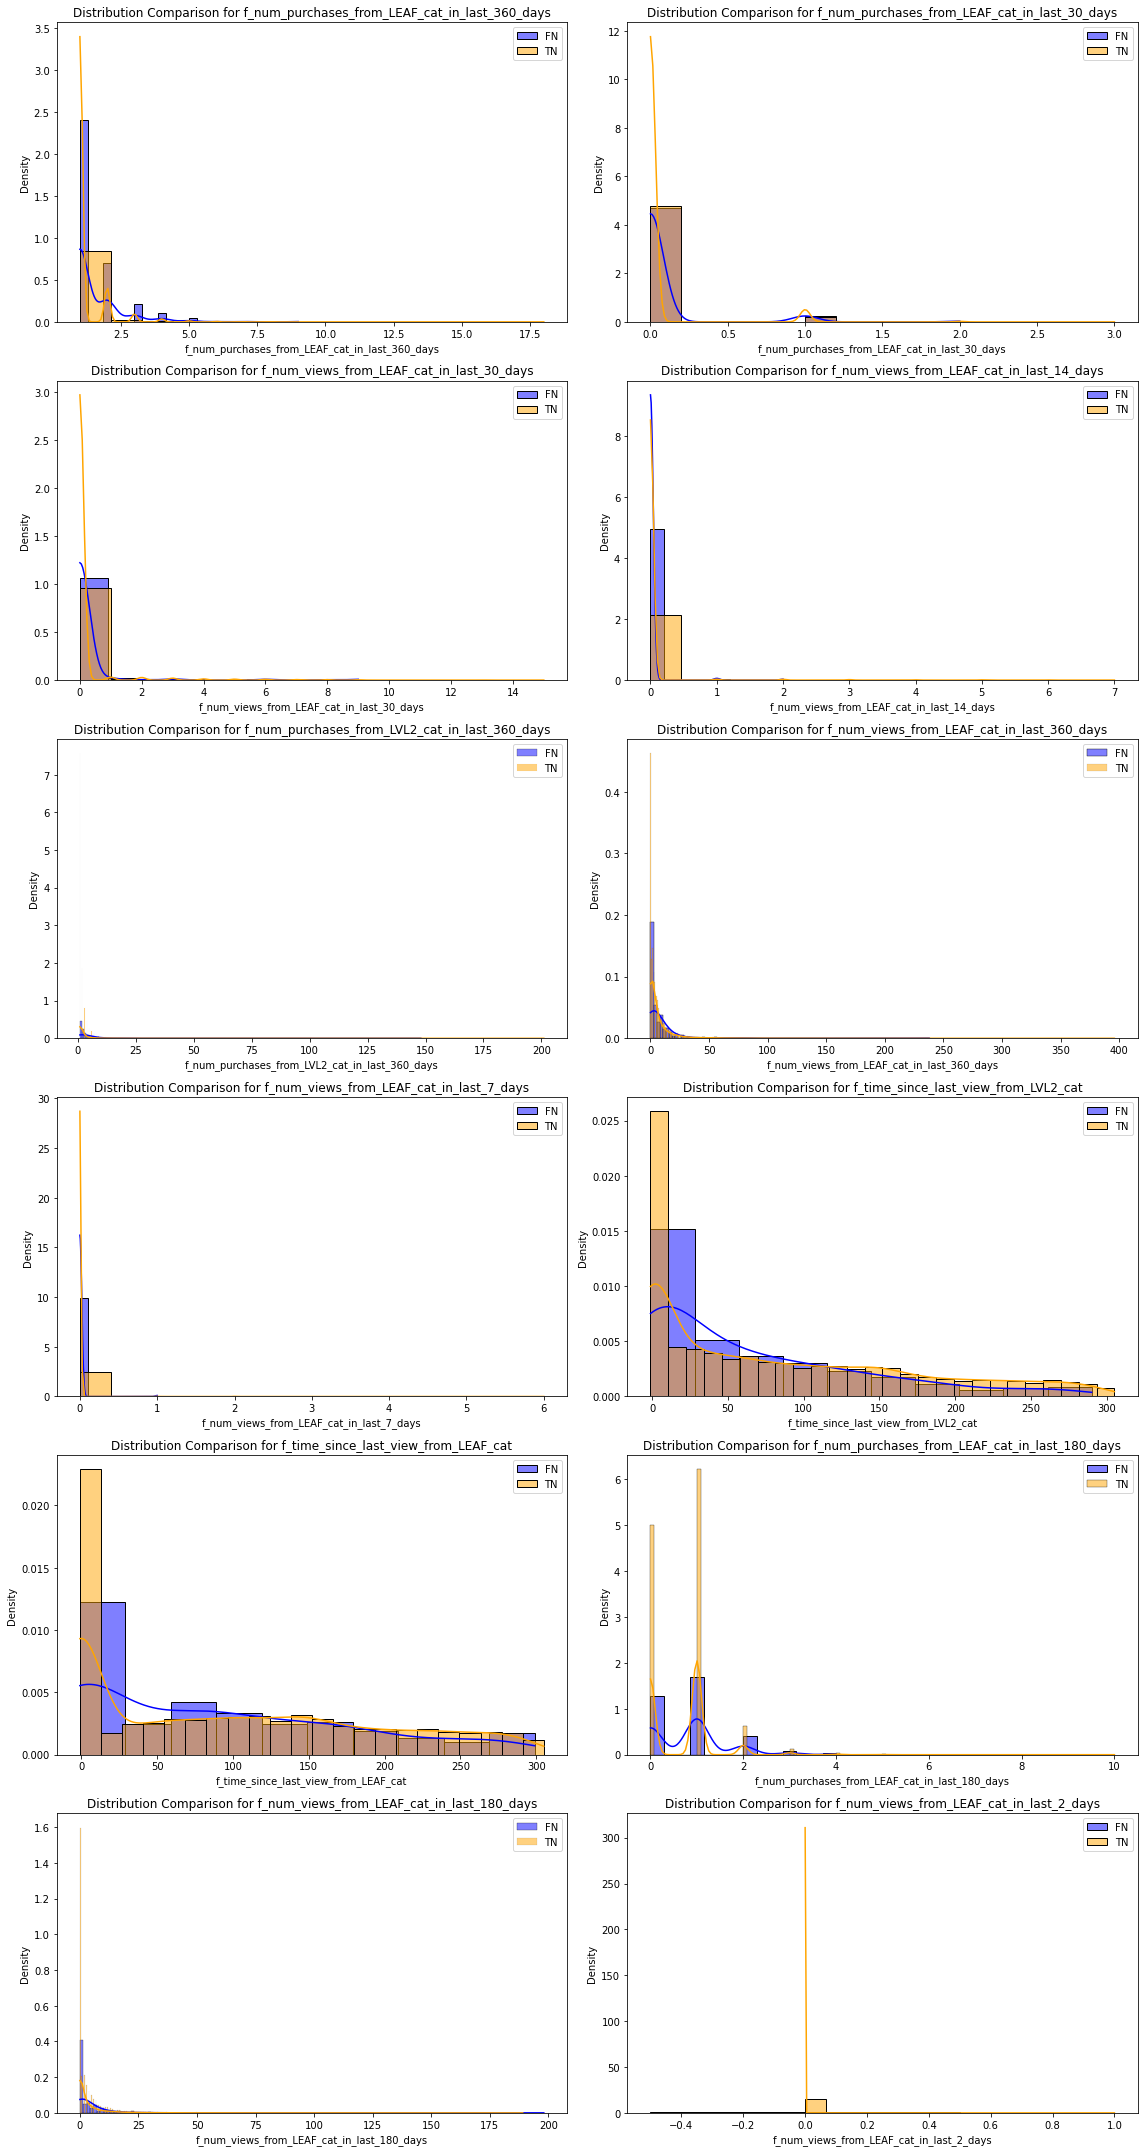

,Feature,FN_5,FN_10,FN_25,FN_50,FN_75,FN_90,FN_95,TN_5,TN_10,...,TN_75,TN_90,TN_95,Diff_5,Diff_10,Diff_25,Diff_50,Diff_75,Diff_90,Diff_95
0,f_num_purchases_from_LEAF_cat_in_last_360_days,1.0,1.0,1.0,1.0,2.0,3.0,3.6,1.0,1.0,...,1.0,2.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,1.6
1,f_num_purchases_from_LEAF_cat_in_last_30_days,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,f_num_views_from_LEAF_cat_in_last_30_days,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f_num_views_from_LEAF_cat_in_last_14_days,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f_num_purchases_from_LVL2_cat_in_last_360_days,1.0,1.0,1.0,2.0,4.0,8.0,16.6,1.0,1.0,...,2.0,4.8,7.0,0.0,0.0,0.0,1.0,2.0,3.2,9.6
5,f_num_views_from_LEAF_cat_in_last_360_days,0.0,0.0,0.0,3.0,9.0,17.0,28.6,0.0,0.0,...,8.0,18.0,28.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.6
6,f_num_views_from_LEAF_cat_in_last_7_days,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,f_time_since_last_view_from_LVL2_cat,-1.0,-1.0,3.0,39.0,105.0,172.0,219.2,-1.0,-1.0,...,145.0,225.0,261.0,0.0,0.0,2.0,-20.0,-40.0,-53.0,-41.8
8,f_time_since_last_view_from_LEAF_cat,-1.0,-1.0,-1.0,73.0,153.0,224.2,268.2,-1.0,-1.0,...,170.0,244.0,272.0,0.0,0.0,0.0,-13.0,-17.0,-19.8,-3.8
9,f_num_purchases_from_LEAF_cat_in_last_180_days,0.0,0.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,...,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [247]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the features to analyze
features_to_analyze = [
    'f_num_purchases_from_LEAF_cat_in_last_360_days',
    'f_num_purchases_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_14_days',
    'f_num_purchases_from_LVL2_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_7_days',
    'f_time_since_last_view_from_LVL2_cat',
    'f_time_since_last_view_from_LEAF_cat',
    'f_num_purchases_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_2_days'
]

# Dictionary to store percentile comparisons
percentile_comparisons = {}

# Set up percentiles to compare
percentiles = [0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95]

# Initialize a figure with 2 columns for side-by-side plots
n_features = len(features_to_analyze)
fig, axes = plt.subplots(n_features // 2 + n_features % 2, 2, figsize=(16, n_features * 2.5))
axes = axes.flatten()

# Calculate percentiles and differences for FN and TN, and plot distributions
for i, feature in enumerate(features_to_analyze):
    fn_data = eval_df[(eval_df['label'] == 1) & (eval_df['preds'] == 0)][feature]
    tn_data = eval_df[(eval_df['label'] == 0) & (eval_df['preds'] == 0)][feature]
    
    # Calculate percentiles for FN and TN
    fn_percentiles = fn_data.quantile(percentiles).to_dict()
    tn_percentiles = tn_data.quantile(percentiles).to_dict()
    
    # Store the percentiles and differences
    percentile_comparisons[feature] = {
        f"FN_{int(p*100)}": fn_percentiles[p] for p in percentiles
    }
    percentile_comparisons[feature].update({
        f"TN_{int(p*100)}": tn_percentiles[p] for p in percentiles
    })
    percentile_comparisons[feature].update({
        f"Diff_{int(p*100)}": fn_percentiles[p] - tn_percentiles[p] for p in percentiles
    })
    
    # Plot the distributions side-by-side
    ax = axes[i]
    sns.histplot(fn_data, color='blue', kde=True, label='FN', stat='density', ax=ax)
    sns.histplot(tn_data, color='orange', kde=True, label='TN', stat='density', ax=ax)
    ax.set_title(f'Distribution Comparison for {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()

# Hide any unused subplots if features_to_analyze count is odd
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Create a DataFrame for the percentile comparisons
percentile_df = pd.DataFrame(percentile_comparisons).T.reset_index()
percentile_df.columns = ['Feature'] + [f"FN_{int(p*100)}" for p in percentiles] + \
                        [f"TN_{int(p*100)}" for p in percentiles] + \
                        [f"Diff_{int(p*100)}" for p in percentiles]
percentile_df = percentile_df.round(2)

# Display the percentile comparisons DataFrame
percentile_df


In [153]:
# Define the top 30 features based on importance order
features_to_analyze = top_30_features  # Use only top features by importance

# Filter the data for cases where label == 1
label_1_df = eval_df[eval_df['label'] == 1]

# Separate data for label == 1 into two groups based on prediction
pred_0 = label_1_df[label_1_df['preds'] == 0]
pred_1 = label_1_df[label_1_df['preds'] == 1]

# Initialize dictionaries to store results
mean_pred_0, mean_pred_1 = {}, {}
std_pred_0, std_pred_1 = {}, {}

# Calculate mean and standard deviation only for values > -1
for feature in features_to_analyze:
    # Filter values > -1 for each feature
    pred_0_filtered = pred_0[feature][pred_0[feature] > -1]
    pred_1_filtered = pred_1[feature][pred_1[feature] > -1]

    # Calculate mean and standard deviation
    mean_pred_0[feature] = pred_0_filtered.mean()
    std_pred_0[feature] = pred_0_filtered.std()
    mean_pred_1[feature] = pred_1_filtered.mean()
    std_pred_1[feature] = pred_1_filtered.std()

# Calculate the difference and ratio between the means
difference = {feature: mean_pred_1[feature] - mean_pred_0[feature] for feature in features_to_analyze}
ratio = {feature: mean_pred_1[feature] / (mean_pred_0[feature] + 1e-10) for feature in features_to_analyze}  # Avoid division by zero

# Create a DataFrame to display results
comparison_df = pd.DataFrame({
    'Feature': features_to_analyze,
    'Mean (Pred = 0)': pd.Series(mean_pred_0),
    'Std (Pred = 0)': pd.Series(std_pred_0),
    'Mean (Pred = 1)': pd.Series(mean_pred_1),
    'Std (Pred = 1)': pd.Series(std_pred_1),
    'Difference': pd.Series(difference),
    'Ratio (Pred = 1 / Pred = 0)': pd.Series(ratio)
})

# Round all numeric columns to 2 decimal places
comparison_df = comparison_df.round(2)

# Sort the DataFrame by Importance based on the original top_30_features order
comparison_df['Importance Order'] = comparison_df['Feature'].apply(lambda x: top_30_features.index(x))
comparison_df.sort_values(by='Importance Order', ascending=True, inplace=True)
comparison_df.reset_index(drop=True, inplace=True)

# Display the comparison DataFrame
comparison_df[['Feature', 'Mean (Pred = 0)', 'Std (Pred = 0)', 'Mean (Pred = 1)', 'Std (Pred = 1)', 'Difference', 'Ratio (Pred = 1 / Pred = 0)']]


,Feature,Mean (Pred = 0),Std (Pred = 0),Mean (Pred = 1),Std (Pred = 1),Difference,Ratio (Pred = 1 / Pred = 0)
0,f_num_purchases_from_LEAF_cat_in_last_360_days,1.52,1.01,14.47,49.78,12.95,9.520000e+00
1,f_num_views_from_LEAF_cat_in_last_30_days,0.16,1.00,18.53,41.12,18.37,1.129100e+02
2,f_max_META_cat_view_propensity_jaccard_sim_in_...,0.90,0.27,0.73,0.44,-0.16,8.200000e-01
3,f_max_LVL2_cat_view_propensity_jaccard_sim_in_...,0.88,0.28,0.73,0.44,-0.15,8.300000e-01
4,f_max_LEAF_cat_view_propensity_jaccard_sim_in_...,0.89,0.25,0.73,0.44,-0.16,8.200000e-01
5,f_max_LEAF_cat_view_propensity_cosine_sim_in_l...,0.69,0.37,0.69,0.45,0.01,1.010000e+00
6,f_num_views_from_LEAF_cat_in_last_14_days,0.01,0.13,10.05,25.68,10.03,8.263500e+02
7,f_num_purchases_from_LVL2_cat_in_last_360_days,4.73,11.11,32.17,76.10,27.44,6.800000e+00
8,f_max_LEAF_cat_view_propensity_jaccard_sim_in_...,0.63,0.35,0.68,0.45,0.06,1.090000e+00
9,f_num_views_from_LEAF_cat_in_last_360_days,8.40,21.40,66.38,122.06,57.98,7.900000e+00


In [236]:
# Define the features to analyze
features_to_analyze = [
    'f_num_purchases_from_LEAF_cat_in_last_360_days',
    'f_num_purchases_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_30_days',
    'f_num_views_from_LEAF_cat_in_last_14_days',
    'f_num_purchases_from_LVL2_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_360_days',
    'f_num_views_from_LEAF_cat_in_last_7_days',
    'f_time_since_last_view_from_LVL2_cat',
    'f_time_since_last_view_from_LEAF_cat',
    'f_num_purchases_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_180_days',
    'f_num_views_from_LEAF_cat_in_last_2_days'
]

# Initialize a dictionary to store the results
percentages = {}

# Calculate statistics for each feature, split by label
for feature in features_to_analyze:
    stats_0 = {}  # To store stats for label=0
    stats_1 = {}  # To store stats for label=1
    
    for label in [0, 1]:
        # Filter by label
        label_data = eval_df[eval_df['label'] == label][feature]
        total_count = label_data.count()  # Total count of non-null values
        count_neg1 = (label_data == -1).sum()  # Count of -1
        count_0 = (label_data == 0).sum()      # Count of 0
        count_gt0 = (label_data > 0).sum()     # Count of >0
        
        # Calculate percentages and statistics
        stats = {
            'Percent == -1': (count_neg1 / total_count) * 100 if total_count > 0 else 0,
            'Percent == 0': (count_0 / total_count) * 100 if total_count > 0 else 0,
            'Percent > 0': (count_gt0 / total_count) * 100 if total_count > 0 else 0,
            'Mean': label_data.mean(),
            'Std': label_data.std(),
            'p02': label_data.quantile(0.02),
            'p05': label_data.quantile(0.05),
            'p10': label_data.quantile(0.10),
            'p25': label_data.quantile(0.25),
            'p50': label_data.quantile(0.50),
            'p75': label_data.quantile(0.75),
            'p90': label_data.quantile(0.90),
            'p95': label_data.quantile(0.95)
        }
        
        # Store stats in dictionary for label 0 and 1
        if label == 0:
            stats_0 = stats
            percentages[f"{feature}_0"] = stats
        else:
            stats_1 = stats
            percentages[f"{feature}_1"] = stats
    
    # Calculate the differences between _1 and _0 statistics
    diff_stats = {key: stats_1[key] - stats_0[key] for key in stats_0.keys()}
    percentages[f"{feature}_diff"] = diff_stats

# Create a DataFrame for better visualization
percentages_df = pd.DataFrame(percentages).T.reset_index()
percentages_df.columns = [
    'Feature', 'Percent == -1', 'Percent == 0', 'Percent > 0', 
    'Mean', 'Std', 'p02', 'p05', 'p10', 'p25', 'p50', 'p75', 'p90', 'p95'
]
percentages_df = percentages_df.round(2)

# Display the percentages DataFrame
percentages_df


,Feature,Percent == -1,Percent == 0,Percent > 0,Mean,Std,p02,p05,p10,p25,p50,p75,p90,p95
0,f_num_purchases_from_LEAF_cat_in_last_360_days_0,0.00,0.00,100.00,1.68,3.79,1.0,1.0,1.0,1.0,1.0,1.00,3.0,4.00
1,f_num_purchases_from_LEAF_cat_in_last_360_days_1,0.00,0.00,100.00,11.17,43.33,1.0,1.0,1.0,1.0,2.0,6.00,17.0,34.55
2,f_num_purchases_from_LEAF_cat_in_last_360_days...,0.00,0.00,0.00,9.48,39.55,0.0,0.0,0.0,0.0,1.0,5.00,14.0,30.55
3,f_num_purchases_from_LEAF_cat_in_last_30_days_0,0.00,89.31,10.69,0.15,0.92,0.0,0.0,0.0,0.0,0.0,0.00,1.0,1.00
4,f_num_purchases_from_LEAF_cat_in_last_30_days_1,0.00,64.19,35.81,1.98,14.04,0.0,0.0,0.0,0.0,0.0,1.00,3.0,5.00
5,f_num_purchases_from_LEAF_cat_in_last_30_days_...,0.00,-25.12,25.12,1.83,13.12,0.0,0.0,0.0,0.0,0.0,1.00,2.0,4.00
6,f_num_views_from_LEAF_cat_in_last_30_days_0,0.00,84.10,15.90,2.03,11.93,0.0,0.0,0.0,0.0,0.0,0.00,3.0,9.00
7,f_num_views_from_LEAF_cat_in_last_30_days_1,0.00,56.82,43.18,13.85,36.38,0.0,0.0,0.0,0.0,0.0,9.00,41.0,75.65
8,f_num_views_from_LEAF_cat_in_last_30_days_diff,0.00,-27.28,27.28,11.82,24.45,0.0,0.0,0.0,0.0,0.0,9.00,38.0,66.65
9,f_num_views_from_LEAF_cat_in_last_14_days_0,0.00,90.45,9.55,0.93,6.44,0.0,0.0,0.0,0.0,0.0,0.00,0.0,4.00


In [234]:
!pwd

/data/shpx/notebooks/olivyatan/purchase_suppression/user_priors


#### Save eval df

In [235]:
eval_df.to_pickle('/data/shpx/notebooks/olivyatan/purchase_suppression/user_priors/eval_df_analyse.pkl')


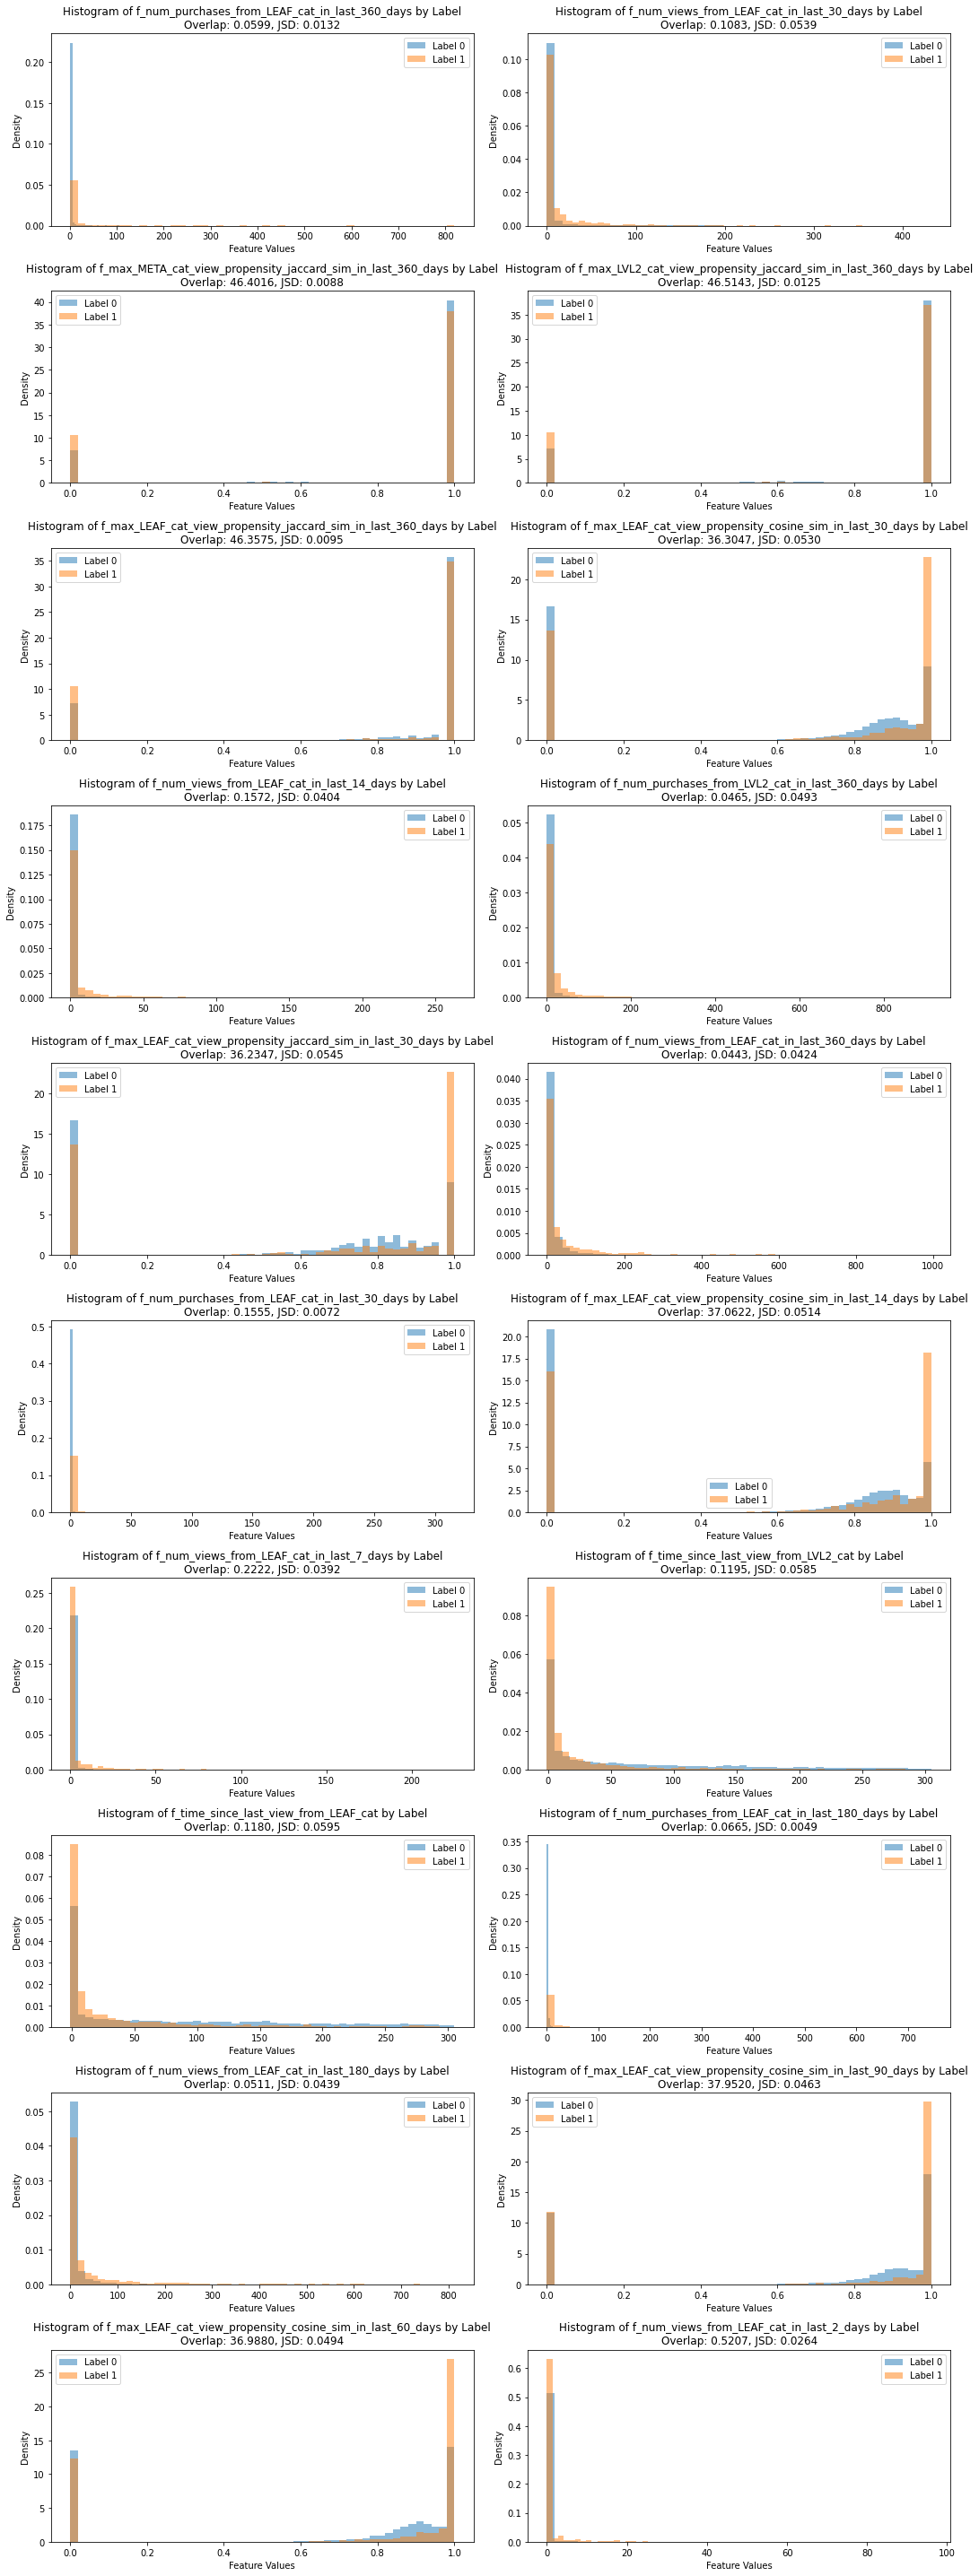

                                         Feature Name  Percent -1  Percent 0  \
0      f_num_purchases_from_LEAF_cat_in_last_360_days    0.000000   0.000000   
1           f_num_views_from_LEAF_cat_in_last_30_days    0.000000  82.310745   
2   f_max_META_cat_view_propensity_jaccard_sim_in_...    0.000000  14.860602   
3   f_max_LVL2_cat_view_propensity_jaccard_sim_in_...    0.000000  14.896215   
4   f_max_LEAF_cat_view_propensity_jaccard_sim_in_...    0.000000  14.860602   
5   f_max_LEAF_cat_view_propensity_cosine_sim_in_l...    0.000000  32.936508   
6           f_num_views_from_LEAF_cat_in_last_14_days    0.000000  88.817664   
7      f_num_purchases_from_LVL2_cat_in_last_360_days    0.000000   0.000000   
8   f_max_LEAF_cat_view_propensity_jaccard_sim_in_...    0.000000  32.936508   
9          f_num_views_from_LEAF_cat_in_last_360_days    0.000000  30.077330   
10      f_num_purchases_from_LEAF_cat_in_last_30_days    0.000000  87.657713   
11  f_max_LEAF_cat_view_propensity_cosin

In [129]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import kl_div
import numpy as np

# Function to calculate the overlap coefficient
def overlap_coefficient(p, q):
    return np.sum(np.minimum(p, q))

# Function to calculate the Jensen-Shannon Divergence
def jensen_shannon_divergence(p, q):
    p = p / np.sum(p)  # Normalize to probabilities
    q = q / np.sum(q)  # Normalize to probabilities
    m = 0.5 * (p + q)  # Average distribution
    return 0.5 * (kl_div(p, m).sum() + kl_div(q, m).sum())

top_30_features = feature_order[0:30]  # Select the top 30 features

# Initialize a list to store the results
results = []

# Set the number of columns for the plots
n_cols = 2
n_rows = (len(top_30_features) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Create a figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

for idx, feature_name in enumerate(top_30_features):
    # Calculate counts
    total_count = eval_df[feature_name].count()  # Counts non-NaN values
    count_na = eval_df[feature_name].isna().sum()  # Count NaN values
    count_minus_one = (eval_df[feature_name] == -1).sum()
    count_zero = (eval_df[feature_name] == 0).sum()
    count_above_zero = (eval_df[feature_name] > 0).sum()
    
    # Calculate percentages
    percent_minus_one = (count_minus_one / total_count) * 100 if total_count > 0 else 0
    percent_zero = (count_zero / total_count) * 100 if total_count > 0 else 0
    percent_above_zero = (count_above_zero / total_count) * 100 if total_count > 0 else 0
    percent_na = (count_na / (total_count + count_na)) * 100 if (total_count + count_na) > 0 else 0  # Percentage of NaNs
    
    # Calculate average value excluding NaNs, -1, and 0
    average_value = eval_df[eval_df[feature_name] > 0][feature_name].mean()
    
    # Append the results to the list
    results.append({
        'Feature Name': feature_name,
        'Percent -1': percent_minus_one,
        'Percent 0': percent_zero,
        'Percent > 0': percent_above_zero,
        'Percent NA': percent_na,
        'Average Value (excluding -1 and 0)': average_value
    })

    # Plot histogram per label on the corresponding subplot
    hist_data = {}
    for label in [0, 1]:  # Loop through each label
        subset = eval_df[eval_df['label'] == label]  # Replace 'label' with your actual label column name
        hist_data[label], bin_edges = np.histogram(subset[feature_name], bins=50, density=True)
        axes[idx].hist(subset[feature_name], bins=bin_edges, alpha=0.5, label=f'Label {label}', density=True)

    # Calculate overlap and divergence
    overlap = overlap_coefficient(hist_data[0], hist_data[1])
    divergence = jensen_shannon_divergence(hist_data[0], hist_data[1])
    
    axes[idx].set_title(f'Histogram of {feature_name} by Label\nOverlap: {overlap:.4f}, JSD: {divergence:.4f}')
    axes[idx].set_xlabel('Feature Values')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()
    axes[idx].grid(False)  # Optionally disable the grid

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Print the results
print(results_df)


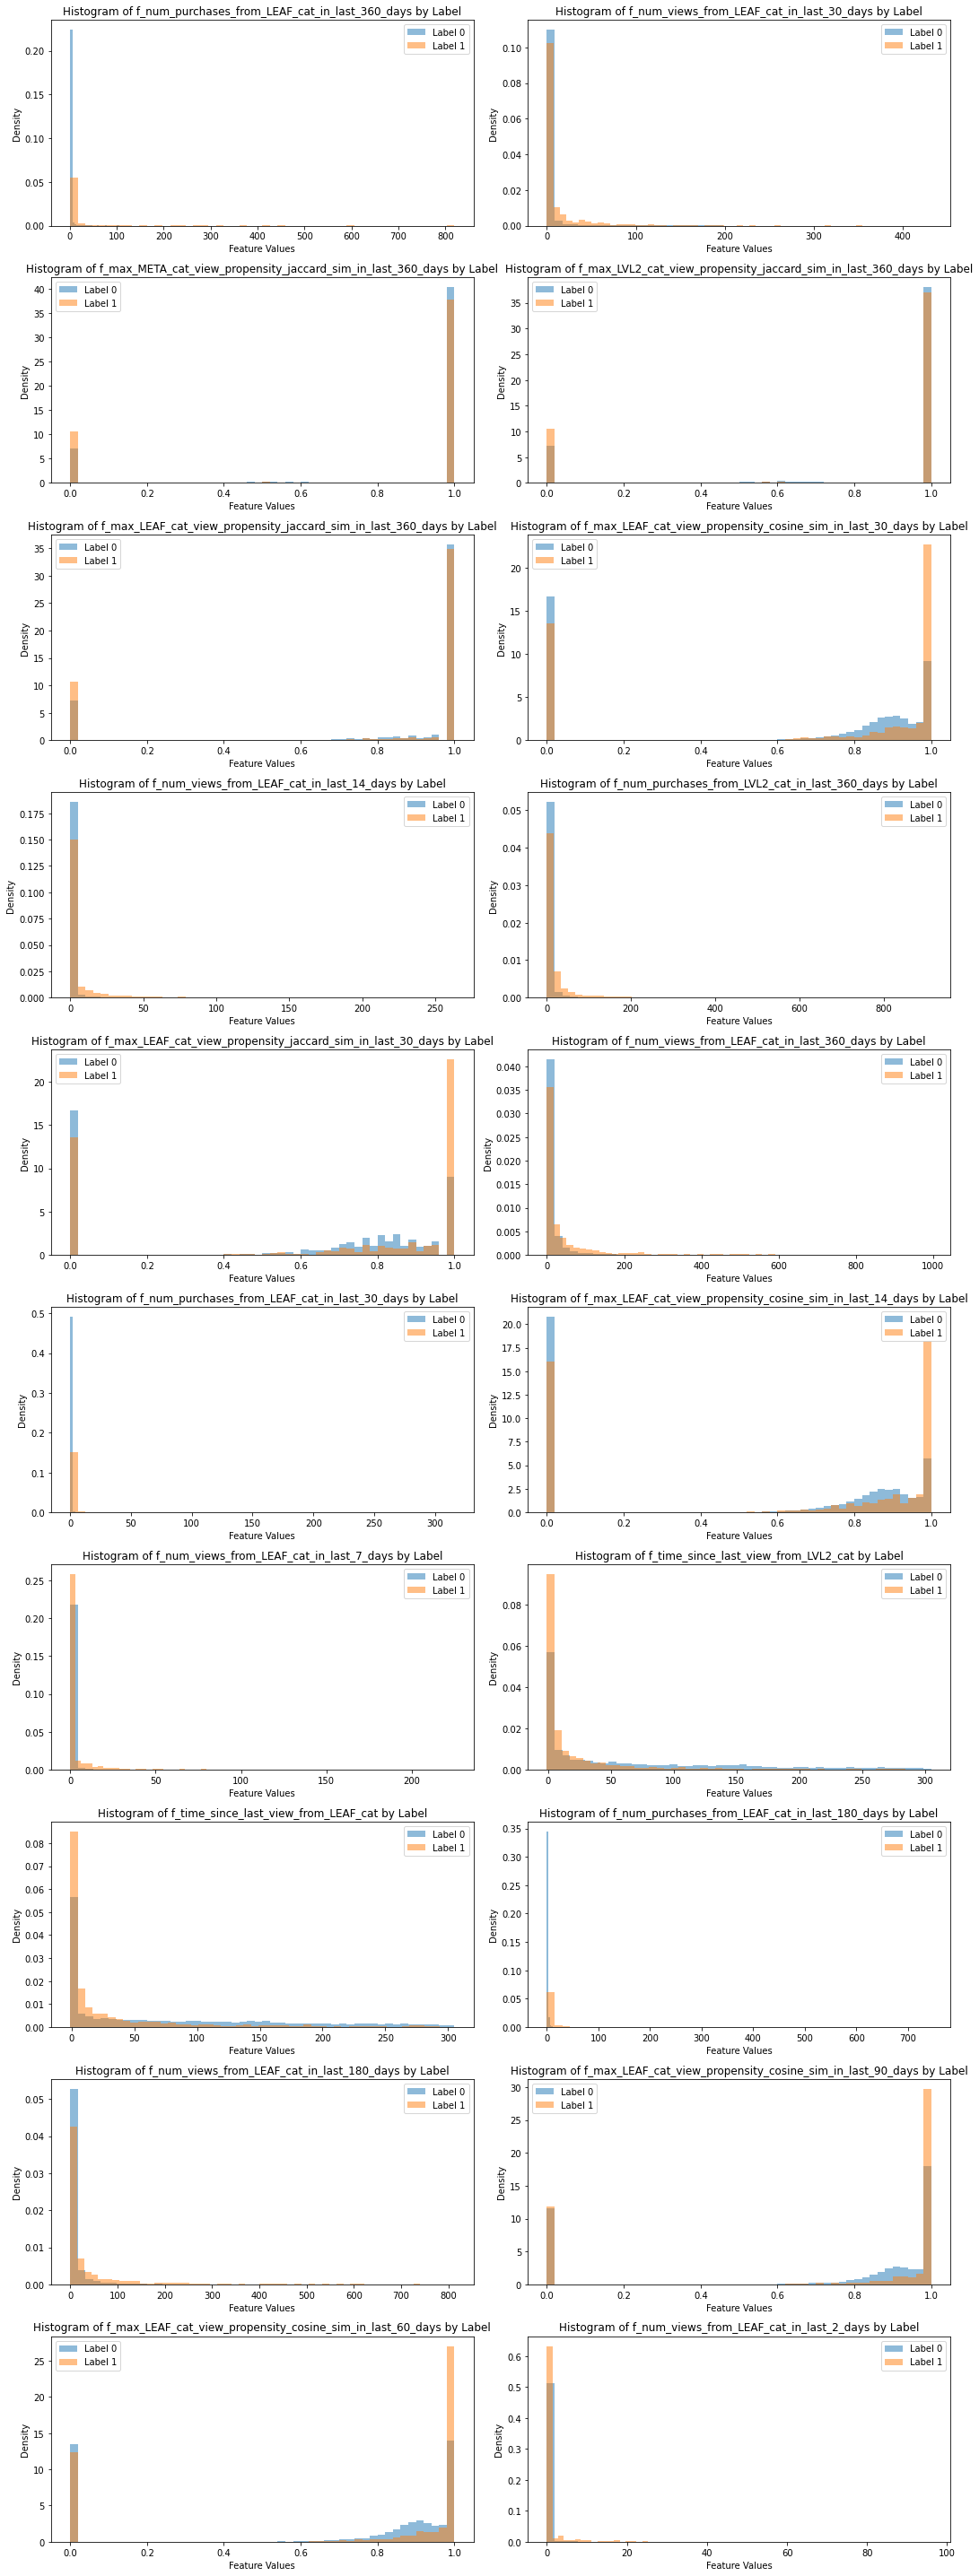

                                         Feature Name  Percent -1  Percent 0  \
0      f_num_purchases_from_LEAF_cat_in_last_360_days    0.000000   0.000000   
1           f_num_views_from_LEAF_cat_in_last_30_days    0.000000  82.310745   
2   f_max_META_cat_view_propensity_jaccard_sim_in_...    0.000000  14.860602   
3   f_max_LVL2_cat_view_propensity_jaccard_sim_in_...    0.000000  14.896215   
4   f_max_LEAF_cat_view_propensity_jaccard_sim_in_...    0.000000  14.860602   
5   f_max_LEAF_cat_view_propensity_cosine_sim_in_l...    0.000000  32.936508   
6           f_num_views_from_LEAF_cat_in_last_14_days    0.000000  88.817664   
7      f_num_purchases_from_LVL2_cat_in_last_360_days    0.000000   0.000000   
8   f_max_LEAF_cat_view_propensity_jaccard_sim_in_...    0.000000  32.936508   
9          f_num_views_from_LEAF_cat_in_last_360_days    0.000000  30.077330   
10      f_num_purchases_from_LEAF_cat_in_last_30_days    0.000000  87.657713   
11  f_max_LEAF_cat_view_propensity_cosin

In [130]:
import pandas as pd
import matplotlib.pyplot as plt

top_30_features = feature_order[0:30]  # Select the top 30 features

# Initialize a list to store the results
results = []

# Set the number of columns for the plots
n_cols = 2
n_rows = (len(top_30_features) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Create a figure and axes for subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
axes = axes.flatten()  # Flatten the 2D array of axes to 1D

for idx, feature_name in enumerate(top_30_features):
    # Calculate counts
    total_count = eval_df[feature_name].count()  # Counts non-NaN values
    count_na = eval_df[feature_name].isna().sum()  # Count NaN values
    count_minus_one = (eval_df[feature_name] == -1).sum()
    count_zero = (eval_df[feature_name] == 0).sum()
    count_above_zero = (eval_df[feature_name] > 0).sum()
    
    # Calculate percentages
    percent_minus_one = (count_minus_one / total_count) * 100 if total_count > 0 else 0
    percent_zero = (count_zero / total_count) * 100 if total_count > 0 else 0
    percent_above_zero = (count_above_zero / total_count) * 100 if total_count > 0 else 0
    percent_na = (count_na / (total_count + count_na)) * 100 if (total_count + count_na) > 0 else 0  # Percentage of NaNs
    
    # Calculate average value excluding NaNs, -1, and 0
    average_value = eval_df[eval_df[feature_name] > 0][feature_name].mean()
    
    # Append the results to the list
    results.append({
        'Feature Name': feature_name,
        'Percent -1': percent_minus_one,
        'Percent 0': percent_zero,
        'Percent > 0': percent_above_zero,
        'Percent NA': percent_na,
        'Average Value (excluding -1 and 0)': average_value
    })
    
    # Plot histogram per label on the corresponding subplot
    for label in [0, 1]:  # Loop through each label
        subset = eval_df[eval_df['label'] == label]  # Replace 'label' with your actual label column name
        axes[idx].hist(subset[feature_name], bins=50, alpha=0.5, label=f'Label {label}', density=True)

    axes[idx].set_title(f'Histogram of {feature_name} by Label')
    axes[idx].set_xlabel('Feature Values')
    axes[idx].set_ylabel('Density')
    axes[idx].legend()
    axes[idx].grid(False)  # Optionally disable the grid

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Print the results
print(results_df) 


#### Eval data new model:

In [101]:
import pandas as pd
from IPython.display import display, HTML

top_30_features = feature_order[0:30]  # Select the top 30 features

# Initialize a list to store the results
results = []

for feature_name in top_30_features:
    # Calculate counts
    total_count = eval_df[feature_name].count()  # Counts non-NaN values
    count_minus_one = (eval_df[feature_name] == -1).sum()
    count_zero = (eval_df[feature_name] == 0).sum()
    count_above_zero = (eval_df[feature_name] > 0).sum()
    
    # Calculate percentages
    percent_minus_one = (count_minus_one / total_count) * 100 if total_count > 0 else 0
    percent_zero = (count_zero / total_count) * 100 if total_count > 0 else 0
    percent_above_zero = (count_above_zero / total_count) * 100 if total_count > 0 else 0
    
    # Calculate average value excluding NaNs, -1, and 0
    average_value = eval_df[eval_df[feature_name] > 0][feature_name].mean()
    
    # Append the results to the list
    results.append({
        'Feature Name': feature_name,
        'Percent -1': percent_minus_one,
        'Percent 0': percent_zero,
        'Percent > 0': percent_above_zero,
        'Average Value (excluding -1 and 0)': average_value
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results)

# Display the results with smaller font size for the "Feature Name" column
results_html = results_df.to_html(escape=False, index=False)
results_html = results_html.replace('<th>', '<th style="font-size: 10px;">')  # Adjust font size as needed
display(HTML(results_html))


Feature Name,Percent -1,Percent 0,Percent > 0,Average Value (excluding -1 and 0)
f_num_views_from_LEAF_cat_in_last_30_days,0.000000,82.051413,17.948587,17.194271
f_max_LEAF_cat_view_propensity_cosine_sim_in_last_30_days,0.000000,32.323747,67.676253,0.904276
f_max_num_views_between_purchases_in_LEAF_cat,0.000000,47.620260,52.379740,16.175607
f_max_META_cat_view_propensity_jaccard_sim_in_last_60_days,0.000000,26.256045,73.743955,0.862417
f_max_LEAF_cat_view_propensity_cosine_sim_in_last_14_days,0.000000,40.386867,59.613133,0.883726
f_time_since_last_view_from_LEAF_cat,29.854925,0.000000,70.145075,107.921698
f_mean_num_views_between_purchases_in_LEAF_cat,0.000000,47.620260,52.379740,11.900819
f_num_purchases_from_LVL2_cat_in_last_60_days,0.000000,67.248664,32.751336,4.504352
f_num_views_from_LEAF_cat_in_last_60_days,0.000000,72.471367,27.528633,20.691198
f_entropy_for_META_cat_views,19.368796,80.183253,0.447951,0.683255


#### new model:

In [132]:
import pandas as pd

# First, filter the DataFrame for label == 1 (True class)
filtered_df = eval_df[eval_df['label'] == 1]

# Split into two groups based on preds
group_0 = filtered_df[filtered_df['preds'] == 0]  # False Negatives
group_1 = filtered_df[filtered_df['preds'] == 1]  # True Positives

# Initialize a list to store the results
results = []

# Get the top 30 features from feature_order
top_30_features = feature_order[0:30]

# Calculate statistics for each of the top 30 features
for feature in top_30_features:
    # Calculate means for each group, excluding -1 and 0 values
    mean_0 = group_0[group_0[feature] > -1][feature].mean() if not group_0.empty else None
    mean_1 = group_1[group_1[feature] > -1][feature].mean() if not group_1.empty else None
    
    # Append results to the list
    results.append({
        'Feature Name': feature,
        'Mean (preds = 0)': mean_0,  # For False Negatives
        'Mean (preds = 1)': mean_1,  # For True Positives
        'Difference': (mean_1 - mean_0) if mean_0 is not None and mean_1 is not None else None
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the title and the results
print("Feature differences where Label == 1 and preds is 0 or 1")
results_df


Feature differences where Label == 1 and preds is 0 or 1


,Feature Name,Mean (preds = 0),Mean (preds = 1),Difference
0,f_num_purchases_from_LEAF_cat_in_last_360_days,1.519757,14.468262,12.948505
1,f_num_views_from_LEAF_cat_in_last_30_days,0.164134,18.531738,18.367604
2,f_max_META_cat_view_propensity_jaccard_sim_in_...,0.895758,0.730884,-0.164874
3,f_max_LVL2_cat_view_propensity_jaccard_sim_in_...,0.878106,0.728410,-0.149697
4,f_max_LEAF_cat_view_propensity_jaccard_sim_in_...,0.892716,0.730060,-0.162656
5,f_max_LEAF_cat_view_propensity_cosine_sim_in_l...,0.686010,0.693581,0.007571
6,f_num_views_from_LEAF_cat_in_last_14_days,0.012158,10.046826,10.034668
7,f_num_purchases_from_LVL2_cat_in_last_360_days,4.729483,32.171696,27.442213
8,f_max_LEAF_cat_view_propensity_jaccard_sim_in_...,0.626996,0.682621,0.055625
9,f_num_views_from_LEAF_cat_in_last_360_days,8.401216,66.377732,57.976516


In [135]:
import pandas as pd

# First, filter the DataFrame for label == 1 (True class)
filtered_df = eval_df[eval_df['label'] == 1]

# Split into two groups based on preds
group_0 = filtered_df[filtered_df['preds'] == 0]  # False Negatives
group_1 = filtered_df[filtered_df['preds'] == 1]  # True Positives

# Initialize a list to store the results
results = []

# Get the top 30 features from feature_order
top_30_features = feature_order[0:30]

# Calculate statistics for each of the top 30 features
for feature in top_30_features:
    # Calculate means and standard deviations for each group, excluding -1 and 0 values
    mean_0 = group_0[group_0[feature] > -1][feature].mean() if not group_0.empty else None
    mean_1 = group_1[group_1[feature] > -1][feature].mean() if not group_1.empty else None
    std_0 = group_0[group_0[feature] > -1][feature].std() if not group_0.empty else None
    std_1 = group_1[group_1[feature] > -1][feature].std() if not group_1.empty else None

    # Append results to the list
    results.append({
        'Feature Name': feature,
        'Mean (preds = 0)': mean_0,  # For False Negatives
        'Mean (preds = 1)': mean_1,  # For True Positives
        'Std (preds = 0)': std_0,    # Standard deviation for False Negatives
        'Std (preds = 1)': std_1,    # Standard deviation for True Positives
        'Difference in Means': (mean_1 - mean_0) if mean_0 is not None and mean_1 is not None else None
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the title and the results
print("Feature differences where Label == 1 and preds is 0 or 1")
results_df


Feature differences where Label == 1 and preds is 0 or 1


,Feature Name,Mean (preds = 0),Mean (preds = 1),Std (preds = 0),Std (preds = 1),Difference in Means
0,f_num_purchases_from_LEAF_cat_in_last_360_days,1.519757,14.468262,1.012305,49.780050,12.948505
1,f_num_views_from_LEAF_cat_in_last_30_days,0.164134,18.531738,0.995626,41.120444,18.367604
2,f_max_META_cat_view_propensity_jaccard_sim_in_...,0.895758,0.730884,0.272253,0.440872,-0.164874
3,f_max_LVL2_cat_view_propensity_jaccard_sim_in_...,0.878106,0.728410,0.277805,0.441426,-0.149697
4,f_max_LEAF_cat_view_propensity_jaccard_sim_in_...,0.892716,0.730060,0.250042,0.439063,-0.162656
5,f_max_LEAF_cat_view_propensity_cosine_sim_in_l...,0.686010,0.693581,0.372199,0.447393,0.007571
6,f_num_views_from_LEAF_cat_in_last_14_days,0.012158,10.046826,0.134701,25.681683,10.034668
7,f_num_purchases_from_LVL2_cat_in_last_360_days,4.729483,32.171696,11.106871,76.096832,27.442213
8,f_max_LEAF_cat_view_propensity_jaccard_sim_in_...,0.626996,0.682621,0.350980,0.445364,0.055625
9,f_num_views_from_LEAF_cat_in_last_360_days,8.401216,66.377732,21.400296,122.060691,57.976516


In [134]:
import pandas as pd

# First, filter the DataFrame for label == 1 (True class)
filtered_df = eval_df[eval_df['label'] == 0]

# Split into two groups based on preds
group_0 = filtered_df[filtered_df['preds'] == 0]  # False Negatives
group_1 = filtered_df[filtered_df['preds'] == 1]  # True Positives

# Initialize a list to store the results
results = []

# Get the top 30 features from feature_order
top_30_features = feature_order[0:30]

# Calculate statistics for each of the top 30 features
for feature in top_30_features:
    # Calculate means for each group, excluding -1 and 0 values
    mean_0 = group_0[group_0[feature] > -1][feature].mean() if not group_0.empty else None
    mean_1 = group_1[group_1[feature] > -1][feature].mean() if not group_1.empty else None
    
    # Append results to the list
    results.append({
        'Feature Name': feature,
        'Mean (preds = 0)': mean_0,  # For False Negatives
        'Mean (preds = 1)': mean_1,  # For True Positives
        'Difference': (mean_1 - mean_0) if mean_0 is not None and mean_1 is not None else None
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the title and the results
print("Feature differences where Label == 0 and preds is 0 or 1")
results_df


Feature differences where Label == 0 and preds is 0 or 1


,Feature Name,Mean (preds = 0),Mean (preds = 1),Difference
0,f_num_purchases_from_LEAF_cat_in_last_360_days,1.211639,2.992154,1.780514
1,f_num_views_from_LEAF_cat_in_last_30_days,0.139318,7.311584,7.172266
2,f_max_META_cat_view_propensity_jaccard_sim_in_...,0.850853,0.782364,-0.068489
3,f_max_LVL2_cat_view_propensity_jaccard_sim_in_...,0.825707,0.778629,-0.047077
4,f_max_LEAF_cat_view_propensity_jaccard_sim_in_...,0.849496,0.780084,-0.069412
5,f_max_LEAF_cat_view_propensity_cosine_sim_in_l...,0.562192,0.706324,0.144132
6,f_num_views_from_LEAF_cat_in_last_14_days,0.027657,3.443320,3.415664
7,f_num_purchases_from_LVL2_cat_in_last_360_days,2.591067,13.012595,10.421528
8,f_max_LEAF_cat_view_propensity_jaccard_sim_in_...,0.514598,0.690429,0.175831
9,f_num_views_from_LEAF_cat_in_last_360_days,7.171707,43.704316,36.532608


In [136]:
import pandas as pd

# First, filter the DataFrame for label == 1 (True class)
filtered_df = eval_df[eval_df['label'] == 0]

# Split into two groups based on preds
group_0 = filtered_df[filtered_df['preds'] == 0]  # False Negatives
group_1 = filtered_df[filtered_df['preds'] == 1]  # True Positives

# Initialize a list to store the results
results = []

# Get the top 30 features from feature_order
top_30_features = feature_order[0:30]

# Calculate statistics for each of the top 30 features
for feature in top_30_features:
    # Calculate means and standard deviations for each group, excluding -1 and 0 values
    mean_0 = group_0[group_0[feature] > -1][feature].mean() if not group_0.empty else None
    mean_1 = group_1[group_1[feature] > -1][feature].mean() if not group_1.empty else None
    std_0 = group_0[group_0[feature] > -1][feature].std() if not group_0.empty else None
    std_1 = group_1[group_1[feature] > -1][feature].std() if not group_1.empty else None

    # Append results to the list
    results.append({
        'Feature Name': feature,
        'Mean (preds = 0)': mean_0,  # For False Negatives
        'Mean (preds = 1)': mean_1,  # For True Positives
        'Std (preds = 0)': std_0,    # Standard deviation for False Negatives
        'Std (preds = 1)': std_1,    # Standard deviation for True Positives
        'Difference in Means': (mean_1 - mean_0) if mean_0 is not None and mean_1 is not None else None
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the title and the results
print("Feature differences where Label == 0 and preds is 0 or 1")
results_df


Feature differences where Label == 0 and preds is 0 or 1


,Feature Name,Mean (preds = 0),Mean (preds = 1),Std (preds = 0),Std (preds = 1),Difference in Means
0,f_num_purchases_from_LEAF_cat_in_last_360_days,1.211639,2.992154,0.674854,7.127326,1.780514
1,f_num_views_from_LEAF_cat_in_last_30_days,0.139318,7.311584,0.863375,22.367046,7.172266
2,f_max_META_cat_view_propensity_jaccard_sim_in_...,0.850853,0.782364,0.335797,0.409944,-0.068489
3,f_max_LVL2_cat_view_propensity_jaccard_sim_in_...,0.825707,0.778629,0.342070,0.411008,-0.047077
4,f_max_LEAF_cat_view_propensity_jaccard_sim_in_...,0.849496,0.780084,0.323129,0.407717,-0.069412
5,f_max_LEAF_cat_view_propensity_cosine_sim_in_l...,0.562192,0.706324,0.422994,0.437230,0.144132
6,f_num_views_from_LEAF_cat_in_last_14_days,0.027657,3.443320,0.310023,12.192210,3.415664
7,f_num_purchases_from_LVL2_cat_in_last_360_days,2.591067,13.012595,6.445662,35.065214,10.421528
8,f_max_LEAF_cat_view_propensity_jaccard_sim_in_...,0.514598,0.690429,0.394795,0.433196,0.175831
9,f_num_views_from_LEAF_cat_in_last_360_days,7.171707,43.704316,15.229092,91.051568,36.532608


In [104]:
import pandas as pd

# Assuming eval_df contains your data and the top 30 features
# Filter the DataFrame for cases where preds == 1 (predicted positive)
filtered_df = eval_df[eval_df['preds_new'] == 1]

# Split into two groups: False Positives (label == 0) and True Positives (label == 1)
group_fp = filtered_df[filtered_df['label'] == 0]  # False Positives
group_tp = filtered_df[filtered_df['label'] == 1]  # True Positives

# Initialize a list to store the results
results = []

# Calculate statistics for each of the top 30 features
top_30_features = feature_order[0:30]  # Assuming feature_order is your list of top 30 features

for feature in top_30_features:
    # Calculate means excluding -1 (if necessary for your case)
    mean_fp = group_fp[group_fp[feature] > -1][feature].mean() if not group_fp.empty else None
    mean_tp = group_tp[group_tp[feature] > -1][feature].mean() if not group_tp.empty else None
    
    # Append results to the list
    results.append({
        'Feature Name': feature,
        'Mean (False Positives, label = 0)': mean_fp,
        'Mean (True Positives, label = 1)': mean_tp,
        'Difference': (mean_tp - mean_fp) if mean_fp is not None and mean_tp is not None else None
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Print the title and the results
print("Feature differences where preds == 1 (False Positives vs True Positives)")
results_df


Feature differences where preds == 1 (False Positives vs True Positives)


,Feature Name,"Mean (False Positives, label = 0)","Mean (True Positives, label = 1)",Difference
0,f_num_views_from_LEAF_cat_in_last_30_days,7.060212,19.691617,12.631404
1,f_max_LEAF_cat_view_propensity_cosine_sim_in_l...,0.657374,0.689146,0.031772
2,f_max_num_views_between_purchases_in_LEAF_cat,19.168558,29.385230,10.216672
3,f_max_META_cat_view_propensity_jaccard_sim_in_...,0.695231,0.712179,0.016948
4,f_max_LEAF_cat_view_propensity_cosine_sim_in_l...,0.589499,0.638478,0.048979
5,f_time_since_last_view_from_LEAF_cat,32.640416,19.641100,-12.999317
6,f_mean_num_views_between_purchases_in_LEAF_cat,14.119098,17.886591,3.767493
7,f_num_purchases_from_LVL2_cat_in_last_60_days,2.941984,8.582834,5.640850
8,f_num_views_from_LEAF_cat_in_last_60_days,13.237555,31.205589,17.968034
9,f_entropy_for_META_cat_views,0.004573,0.004667,0.000094


In [137]:
import pandas as pd

# Initialize a list to store the results
results = []

# Get the top 20 features from feature_order
top_20_features = feature_order[:20]

# Calculate statistics for each of the top 20 features
for feature in top_20_features:
    # Calculate mean and standard deviation for label 0, excluding -1 and 0 values
    mean_label_0 = eval_df[eval_df['label'] == 0][eval_df[feature] > -1][feature].mean()
    std_label_0 = eval_df[eval_df['label'] == 0][eval_df[feature] > -1][feature].std()
    
    # Calculate mean and standard deviation for label 1, excluding -1 and 0 values
    mean_label_1 = eval_df[eval_df['label'] == 1][eval_df[feature] > -1][feature].mean()
    std_label_1 = eval_df[eval_df['label'] == 1][eval_df[feature] > -1][feature].std()
    
    # Append results to the list
    results.append({
        'Feature Name': feature,
        'Mean (label = 0)': mean_label_0,  # Mean for Label 0
        'Std (label = 0)': std_label_0,    # Std deviation for Label 0
        'Mean (label = 1)': mean_label_1,  # Mean for Label 1
        'Std (label = 1)': std_label_1,    # Std deviation for Label 1
        'Difference in Means': (mean_label_1 - mean_label_0) if mean_label_0 is not None and mean_label_1 is not None else None
    })

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

# Print the title and the results
print("Feature statistics per label (0 and 1) for top 20 features")
results_df


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Feature statistics per label (0 and 1) for top 20 features


,Feature Name,Mean (label = 0),Std (label = 0),Mean (label = 1),Std (label = 1),Difference in Means
0,f_num_purchases_from_LEAF_cat_in_last_360_days,1.681150,3.787371,11.165891,43.332482,9.484742
1,f_num_views_from_LEAF_cat_in_last_30_days,2.030600,11.934787,13.847287,36.382876,11.816687
2,f_max_META_cat_view_propensity_jaccard_sim_in_...,0.832793,0.358110,0.772933,0.410838,-0.059859
3,f_max_LVL2_cat_view_propensity_jaccard_sim_in_...,0.813293,0.362110,0.766588,0.411122,-0.046705
4,f_max_LEAF_cat_view_propensity_jaccard_sim_in_...,0.831193,0.348771,0.771543,0.405601,-0.059650
5,f_max_LEAF_cat_view_propensity_cosine_sim_in_l...,0.600199,0.431482,0.691650,0.429342,0.091452
6,f_num_views_from_LEAF_cat_in_last_14_days,0.928346,6.444239,7.487597,22.591119,6.559251
7,f_num_purchases_from_LVL2_cat_in_last_360_days,5.339159,19.387092,25.172868,66.987340,19.833709
8,f_max_LEAF_cat_view_propensity_jaccard_sim_in_...,0.560963,0.412603,0.668435,0.423861,0.107471
9,f_num_views_from_LEAF_cat_in_last_360_days,16.805129,51.143928,51.591473,108.865714,34.786344


In [16]:
#eval df with pred results 
eval_df.to_parquet('/data/shpx/data/olivyatan/traindf_vi_preds_51024.parquet') 

In [ ]:
if session:
    session.stop()